In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Flatten, GRU
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    gru_1 = GRU(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(gru_1)
    gru_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    gru_1_dropout = Dropout(0.3)(gru_1_LRelu)
    gru_2 = GRU(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(gru_1_dropout)
    batch_norm2 = tf.keras.layers.BatchNormalization()(gru_2)
    gru_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    gru_2_dropout = Dropout(0.3)(gru_2_LRelu)
    output_dense = Dense(n_features, activation=None)(gru_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AAPL"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    0.910714    0.912946    0.845982    0.872768    0.742829   
6    2000-01-11    0.856585    0.887277    0.808036    0.828125    0.704832   
7    2000-01-12    0.848214    0.852679    0.772321    0.778460    0.662562   
8    2000-01-13    0.843610    0.881696    0.825893    0.863839    0.735229   
9    2000-01-14    0.892857    0.912946    0.887277    0.896763    0.763252   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  132.160004  132.429993  130.779999  130.960007  129.209290   
5279 2020-12-24  131.320007  133.460007  131.100006  131.970001  130.205780   
5280 2020-12-28  133.990005  137.339996  133.509995  136.690002  134.862686   
5281 2020-12-29  138.050003  138.789993  134.339996  134.869995  133.066986   
5282 2020-12-30  135.580002  135.990005  133.399994  133.720001  131.932373   

          Volume          Ma  
5      505064000    0.915960  
6      441548800    0.890625  
7      976068800    0.873214  
8     1032684800    0.843192  
9      390376000    0.846317  
...          ...         ...  
5278    88223700  128.656000  
5279    54930100  129.286002  
5280   124486200  129.940002  
5281   121047300  131.946002  
5282    96452100  133.274002  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru (GRU)                   (None, 5, 10)             570       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                             

Time for epoch 53 is 0.940039873123169 sec Generator Loss: 0.9098111987113953,  Discriminator_loss: 1.2674381732940674
Time for epoch 54 is 0.9339654445648193 sec Generator Loss: 0.929494321346283,  Discriminator_loss: 1.2600783109664917
Time for epoch 55 is 0.9045202732086182 sec Generator Loss: 0.91270512342453,  Discriminator_loss: 1.2714436054229736
Time for epoch 56 is 1.0479865074157715 sec Generator Loss: 0.9293809533119202,  Discriminator_loss: 1.2583134174346924
Time for epoch 57 is 0.938955545425415 sec Generator Loss: 0.908305823802948,  Discriminator_loss: 1.2682791948318481
Time for epoch 58 is 0.9891061782836914 sec Generator Loss: 0.9109440445899963,  Discriminator_loss: 1.2712565660476685
Time for epoch 59 is 0.9687595367431641 sec Generator Loss: 0.9117082357406616,  Discriminator_loss: 1.2654659748077393
Time for epoch 60 is 0.9434115886688232 sec Generator Loss: 0.9127692580223083,  Discriminator_loss: 1.2691160440444946
Time for epoch 61 is 0.9524617195129395 sec Ge

Time for epoch 122 is 0.8950746059417725 sec Generator Loss: 0.8788315653800964,  Discriminator_loss: 1.293811559677124
Time for epoch 123 is 0.8721206188201904 sec Generator Loss: 0.8806425929069519,  Discriminator_loss: 1.2921708822250366
Time for epoch 124 is 0.8978846073150635 sec Generator Loss: 0.8798283934593201,  Discriminator_loss: 1.3018277883529663
Time for epoch 125 is 0.9705555438995361 sec Generator Loss: 0.8746998906135559,  Discriminator_loss: 1.2898752689361572
Time for epoch 126 is 0.8327317237854004 sec Generator Loss: 0.8709038496017456,  Discriminator_loss: 1.291863203048706
Time for epoch 127 is 0.8149616718292236 sec Generator Loss: 0.8733912706375122,  Discriminator_loss: 1.297348141670227
Time for epoch 128 is 1.0174071788787842 sec Generator Loss: 0.8713322877883911,  Discriminator_loss: 1.2977439165115356
Time for epoch 129 is 0.9123737812042236 sec Generator Loss: 0.8781307339668274,  Discriminator_loss: 1.2991238832473755
Time for epoch 130 is 0.83694434165

Time for epoch 190 is 0.815495491027832 sec Generator Loss: 0.8592787384986877,  Discriminator_loss: 1.3055379390716553
Time for epoch 191 is 0.8713443279266357 sec Generator Loss: 0.8766047954559326,  Discriminator_loss: 1.296185851097107
Time for epoch 192 is 0.8307788372039795 sec Generator Loss: 0.8649616837501526,  Discriminator_loss: 1.2964977025985718
Time for epoch 193 is 0.8370263576507568 sec Generator Loss: 0.8745022416114807,  Discriminator_loss: 1.3030474185943604
Time for epoch 194 is 0.8525848388671875 sec Generator Loss: 0.854861855506897,  Discriminator_loss: 1.308042049407959
Time for epoch 195 is 0.815561056137085 sec Generator Loss: 0.8645341396331787,  Discriminator_loss: 1.3004995584487915
Time for epoch 196 is 0.8223562240600586 sec Generator Loss: 0.8644750714302063,  Discriminator_loss: 1.3035744428634644
Time for epoch 197 is 0.8726568222045898 sec Generator Loss: 0.8660793900489807,  Discriminator_loss: 1.298869252204895
Time for epoch 198 is 0.82756090164184

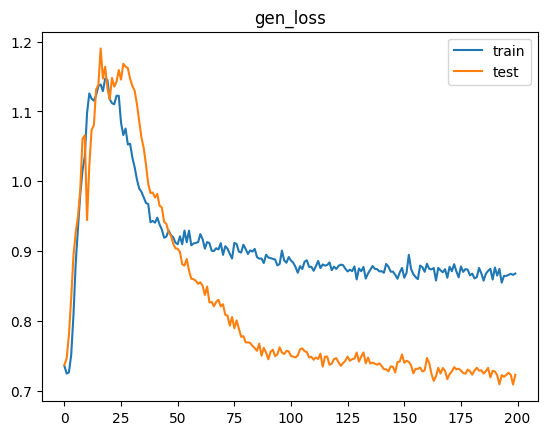

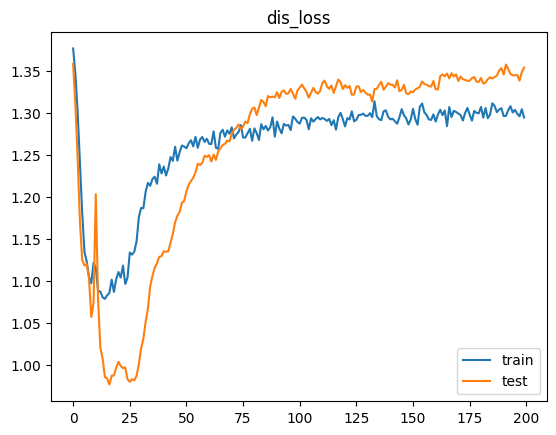

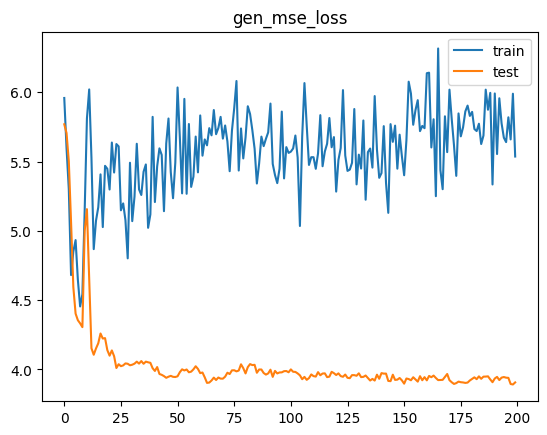

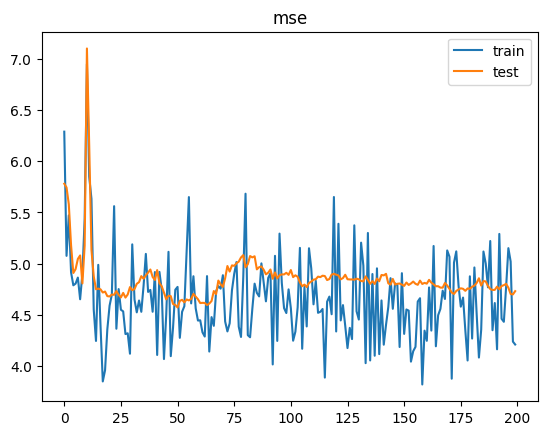

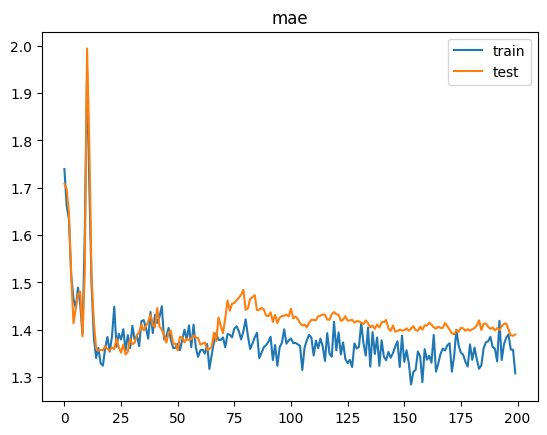

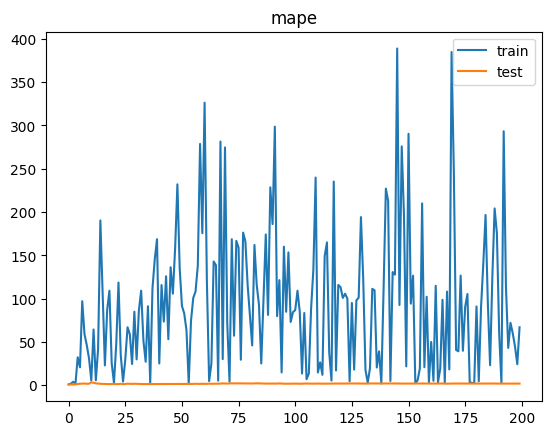

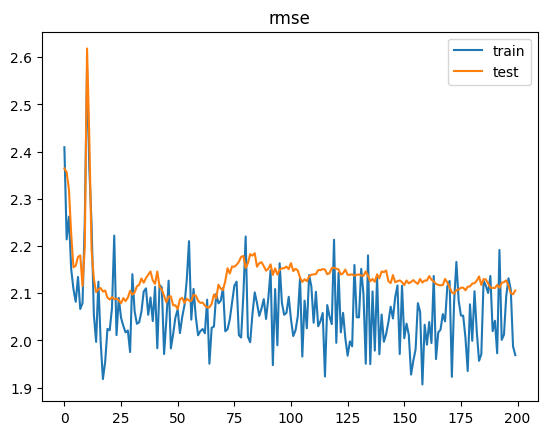

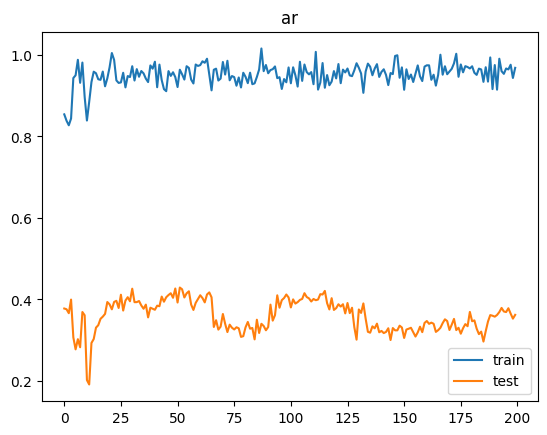

2/2 [==============================] - 0s 3ms/step


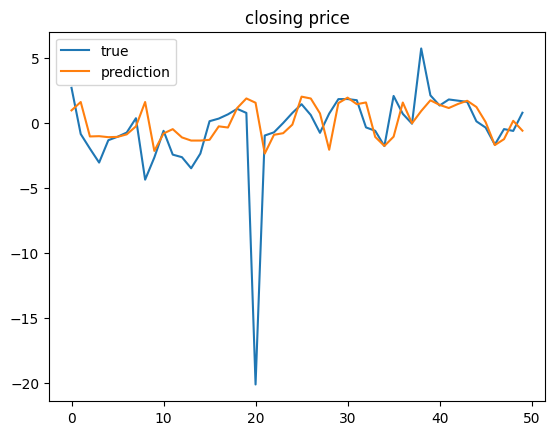

[MSE Baseline] train: 4.656551708632863  test: 4.679867713895856
Delta time with epochs = 200: 0:03:07.820349
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 gru_3 (GRU)   

Time for epoch 52 is 0.8492517471313477 sec Generator Loss: 1.0101617574691772,  Discriminator_loss: 1.2044715881347656
Time for epoch 53 is 0.8619322776794434 sec Generator Loss: 0.9926593899726868,  Discriminator_loss: 1.2193442583084106
Time for epoch 54 is 0.8324594497680664 sec Generator Loss: 0.9668474197387695,  Discriminator_loss: 1.2162493467330933
Time for epoch 55 is 0.8331770896911621 sec Generator Loss: 0.9719140529632568,  Discriminator_loss: 1.2135757207870483
Time for epoch 56 is 0.8330292701721191 sec Generator Loss: 0.9681746959686279,  Discriminator_loss: 1.2305917739868164
Time for epoch 57 is 0.8648946285247803 sec Generator Loss: 0.9589930772781372,  Discriminator_loss: 1.2248291969299316
Time for epoch 58 is 0.8179159164428711 sec Generator Loss: 0.9399694204330444,  Discriminator_loss: 1.2558536529541016
Time for epoch 59 is 0.8446018695831299 sec Generator Loss: 0.9507188200950623,  Discriminator_loss: 1.2387380599975586
Time for epoch 60 is 0.8173232078552246 

Time for epoch 121 is 0.8632972240447998 sec Generator Loss: 0.8627755641937256,  Discriminator_loss: 1.298241376876831
Time for epoch 122 is 0.91929030418396 sec Generator Loss: 0.8780332207679749,  Discriminator_loss: 1.28743577003479
Time for epoch 123 is 0.8781929016113281 sec Generator Loss: 0.8642054796218872,  Discriminator_loss: 1.298588514328003
Time for epoch 124 is 0.9039750099182129 sec Generator Loss: 0.866943359375,  Discriminator_loss: 1.3008666038513184
Time for epoch 125 is 0.8887567520141602 sec Generator Loss: 0.8676372170448303,  Discriminator_loss: 1.2919561862945557
Time for epoch 126 is 0.842200517654419 sec Generator Loss: 0.8652380108833313,  Discriminator_loss: 1.2966327667236328
Time for epoch 127 is 0.844841480255127 sec Generator Loss: 0.8654113411903381,  Discriminator_loss: 1.2977573871612549
Time for epoch 128 is 0.8427965641021729 sec Generator Loss: 0.8630874156951904,  Discriminator_loss: 1.2987955808639526
Time for epoch 129 is 0.8234543800354004 sec

Time for epoch 190 is 0.8286914825439453 sec Generator Loss: 0.8528634905815125,  Discriminator_loss: 1.2928087711334229
Time for epoch 191 is 0.9205515384674072 sec Generator Loss: 0.8565187454223633,  Discriminator_loss: 1.3022326231002808
Time for epoch 192 is 0.9223954677581787 sec Generator Loss: 0.8688428997993469,  Discriminator_loss: 1.2890219688415527
Time for epoch 193 is 0.8664274215698242 sec Generator Loss: 0.8656232357025146,  Discriminator_loss: 1.2946879863739014
Time for epoch 194 is 0.8508124351501465 sec Generator Loss: 0.8561983108520508,  Discriminator_loss: 1.2980542182922363
Time for epoch 195 is 0.8245563507080078 sec Generator Loss: 0.8562783002853394,  Discriminator_loss: 1.3104966878890991
Time for epoch 196 is 0.76460862159729 sec Generator Loss: 0.8538451194763184,  Discriminator_loss: 1.3019956350326538
Time for epoch 197 is 0.7942514419555664 sec Generator Loss: 0.8521968722343445,  Discriminator_loss: 1.2935837507247925
Time for epoch 198 is 0.8014266490

Time for epoch 258 is 0.7906427383422852 sec Generator Loss: 0.8539918661117554,  Discriminator_loss: 1.300557017326355
Time for epoch 259 is 0.7936282157897949 sec Generator Loss: 0.8458927869796753,  Discriminator_loss: 1.312351107597351
Time for epoch 260 is 0.8122458457946777 sec Generator Loss: 0.8426378965377808,  Discriminator_loss: 1.3067928552627563
Time for epoch 261 is 0.8150467872619629 sec Generator Loss: 0.8450139760971069,  Discriminator_loss: 1.3046650886535645
Time for epoch 262 is 0.7953870296478271 sec Generator Loss: 0.8520455360412598,  Discriminator_loss: 1.311625361442566
Time for epoch 263 is 0.7922163009643555 sec Generator Loss: 0.8467051386833191,  Discriminator_loss: 1.3082393407821655
Time for epoch 264 is 0.787473201751709 sec Generator Loss: 0.8503872752189636,  Discriminator_loss: 1.3103889226913452
Time for epoch 265 is 0.7834823131561279 sec Generator Loss: 0.8383459448814392,  Discriminator_loss: 1.3151788711547852
Time for epoch 266 is 0.810351848602

Time for epoch 327 is 0.7979967594146729 sec Generator Loss: 0.837645411491394,  Discriminator_loss: 1.3170710802078247
Time for epoch 328 is 0.7904558181762695 sec Generator Loss: 0.8382118344306946,  Discriminator_loss: 1.3219878673553467
Time for epoch 329 is 0.7846739292144775 sec Generator Loss: 0.8526769876480103,  Discriminator_loss: 1.3037749528884888
Time for epoch 330 is 0.8069360256195068 sec Generator Loss: 0.8486275672912598,  Discriminator_loss: 1.3097988367080688
Time for epoch 331 is 0.8245208263397217 sec Generator Loss: 0.8521133065223694,  Discriminator_loss: 1.3110568523406982
Time for epoch 332 is 0.8124136924743652 sec Generator Loss: 0.8447033762931824,  Discriminator_loss: 1.3213074207305908
Time for epoch 333 is 0.7917649745941162 sec Generator Loss: 0.8417084217071533,  Discriminator_loss: 1.3123277425765991
Time for epoch 334 is 0.7939531803131104 sec Generator Loss: 0.8387383222579956,  Discriminator_loss: 1.320304274559021
Time for epoch 335 is 0.7835257053

Time for epoch 396 is 0.7729015350341797 sec Generator Loss: 0.8471862077713013,  Discriminator_loss: 1.3094520568847656
Time for epoch 397 is 0.764063835144043 sec Generator Loss: 0.8477424383163452,  Discriminator_loss: 1.3198617696762085
Time for epoch 398 is 0.7792699337005615 sec Generator Loss: 0.8470337986946106,  Discriminator_loss: 1.3107144832611084
Time for epoch 399 is 0.7666277885437012 sec Generator Loss: 0.8489629626274109,  Discriminator_loss: 1.3122005462646484
Time for epoch 400 is 0.7546260356903076 sec Generator Loss: 0.8566921353340149,  Discriminator_loss: 1.3095245361328125
Time for epoch 401 is 0.7643322944641113 sec Generator Loss: 0.8585906028747559,  Discriminator_loss: 1.3032262325286865
Time for epoch 402 is 0.815995454788208 sec Generator Loss: 0.8496512174606323,  Discriminator_loss: 1.311478614807129
Time for epoch 403 is 0.8058366775512695 sec Generator Loss: 0.8461058139801025,  Discriminator_loss: 1.3097784519195557
Time for epoch 404 is 0.79380750656

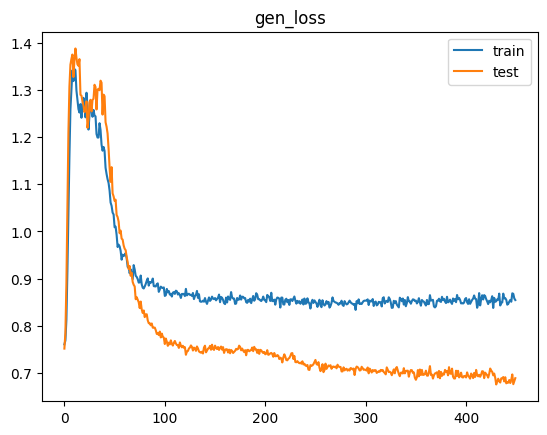

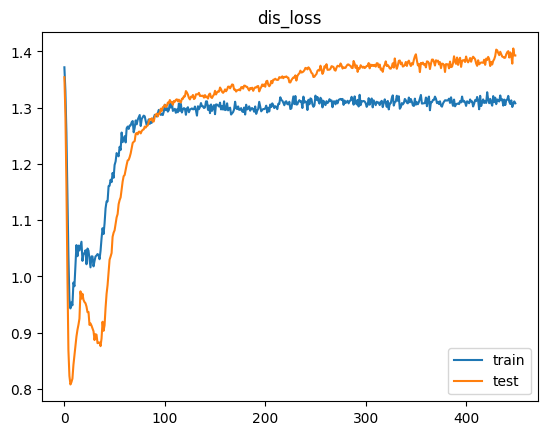

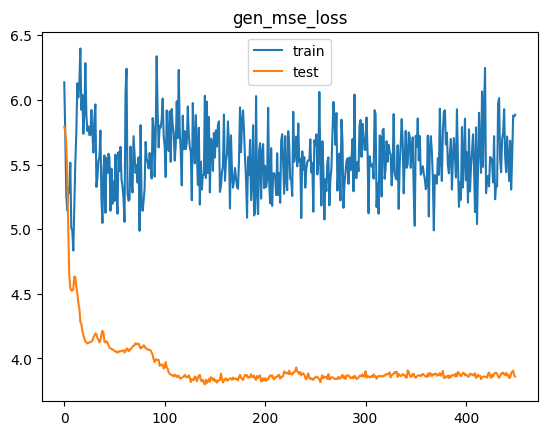

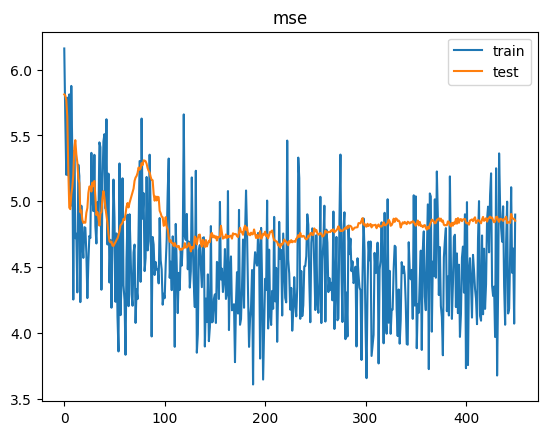

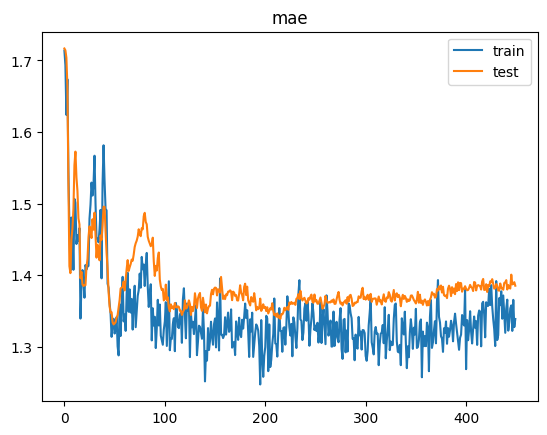

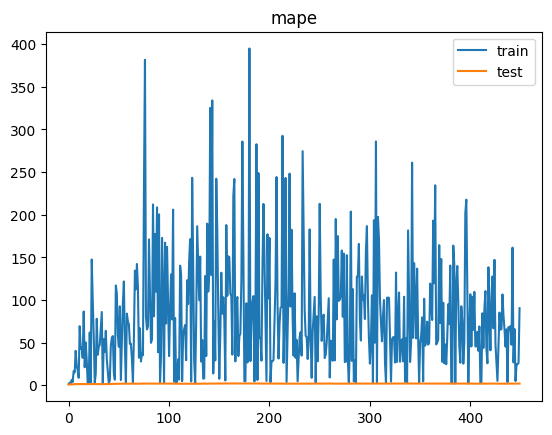

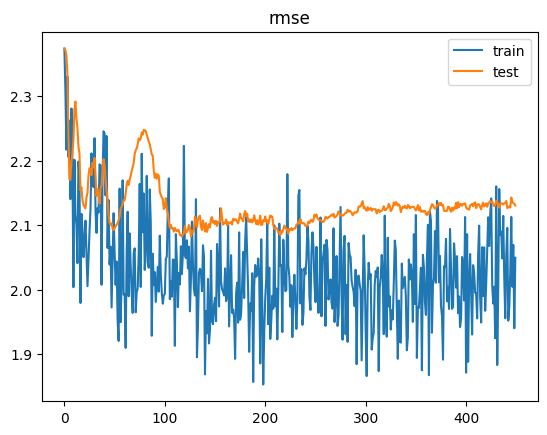

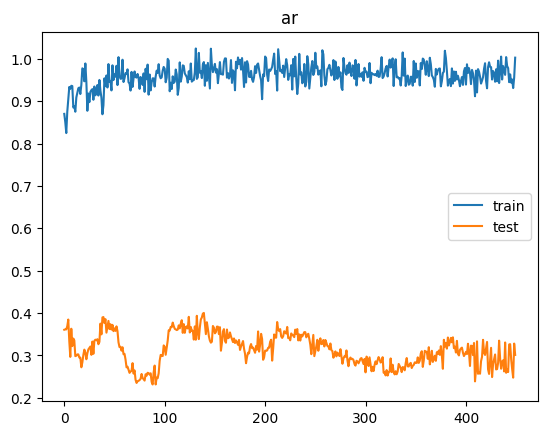

2/2 [==============================] - 0s 3ms/step


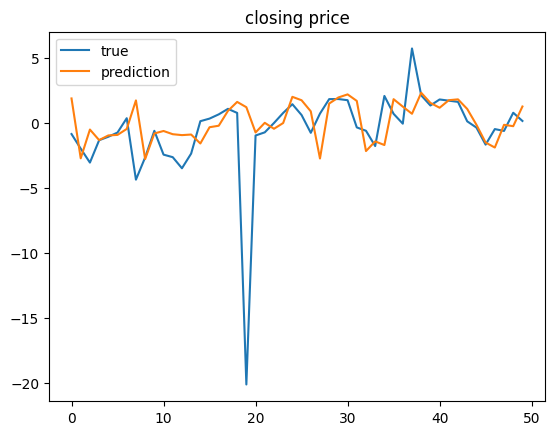

[MSE Baseline] train: 4.080509662206671  test: 4.6881765064049805
Delta time with epochs = 450: 0:06:20.421434
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_4 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_5 (GRU)  

Time for epoch 52 is 0.7922420501708984 sec Generator Loss: 1.010454535484314,  Discriminator_loss: 1.1867514848709106
Time for epoch 53 is 0.7799577713012695 sec Generator Loss: 0.9941026568412781,  Discriminator_loss: 1.2023096084594727
Time for epoch 54 is 0.7738375663757324 sec Generator Loss: 0.990905225276947,  Discriminator_loss: 1.205865740776062
Time for epoch 55 is 0.771503210067749 sec Generator Loss: 0.9982589483261108,  Discriminator_loss: 1.2075886726379395
Time for epoch 56 is 0.7673869132995605 sec Generator Loss: 0.9899688959121704,  Discriminator_loss: 1.2021198272705078
Time for epoch 57 is 0.7700004577636719 sec Generator Loss: 0.9788753986358643,  Discriminator_loss: 1.2098115682601929
Time for epoch 58 is 0.7682478427886963 sec Generator Loss: 0.9679742455482483,  Discriminator_loss: 1.2131396532058716
Time for epoch 59 is 0.7801287174224854 sec Generator Loss: 0.9841725826263428,  Discriminator_loss: 1.216539978981018
Time for epoch 60 is 0.7846484184265137 sec G

Time for epoch 121 is 0.8205597400665283 sec Generator Loss: 0.842411458492279,  Discriminator_loss: 1.320288062095642
Time for epoch 122 is 0.8231799602508545 sec Generator Loss: 0.8448774814605713,  Discriminator_loss: 1.3105076551437378
Time for epoch 123 is 0.8127779960632324 sec Generator Loss: 0.8445923328399658,  Discriminator_loss: 1.3190845251083374
Time for epoch 124 is 0.826535701751709 sec Generator Loss: 0.8400664925575256,  Discriminator_loss: 1.3193187713623047
Time for epoch 125 is 0.8349564075469971 sec Generator Loss: 0.8482065200805664,  Discriminator_loss: 1.3191657066345215
Time for epoch 126 is 0.8163046836853027 sec Generator Loss: 0.8491979837417603,  Discriminator_loss: 1.3184491395950317
Time for epoch 127 is 0.8069088459014893 sec Generator Loss: 0.8409947752952576,  Discriminator_loss: 1.3191964626312256
Time for epoch 128 is 0.8159244060516357 sec Generator Loss: 0.8475945591926575,  Discriminator_loss: 1.314315915107727
Time for epoch 129 is 0.825270175933

Time for epoch 189 is 0.8033909797668457 sec Generator Loss: 0.8497921824455261,  Discriminator_loss: 1.3072835206985474
Time for epoch 190 is 1.2868709564208984 sec Generator Loss: 0.8511746525764465,  Discriminator_loss: 1.3143560886383057
Time for epoch 191 is 0.8176712989807129 sec Generator Loss: 0.8387932181358337,  Discriminator_loss: 1.3176120519638062
Time for epoch 192 is 0.8175313472747803 sec Generator Loss: 0.8490551114082336,  Discriminator_loss: 1.3054115772247314
Time for epoch 193 is 0.8035955429077148 sec Generator Loss: 0.8512545228004456,  Discriminator_loss: 1.3137476444244385
Time for epoch 194 is 0.8030271530151367 sec Generator Loss: 0.8420894742012024,  Discriminator_loss: 1.3090847730636597
Time for epoch 195 is 0.8126876354217529 sec Generator Loss: 0.845601499080658,  Discriminator_loss: 1.315003514289856
Time for epoch 196 is 0.8327219486236572 sec Generator Loss: 0.8645644187927246,  Discriminator_loss: 1.299533724784851
Time for epoch 197 is 0.87435269355

Time for epoch 257 is 0.7880523204803467 sec Generator Loss: 0.8357340693473816,  Discriminator_loss: 1.3238575458526611
Time for epoch 258 is 0.7687621116638184 sec Generator Loss: 0.8435894846916199,  Discriminator_loss: 1.3166409730911255
Time for epoch 259 is 0.7717485427856445 sec Generator Loss: 0.8464761972427368,  Discriminator_loss: 1.326595664024353
Time for epoch 260 is 0.7554986476898193 sec Generator Loss: 0.841338038444519,  Discriminator_loss: 1.3128615617752075
Time for epoch 261 is 0.7769508361816406 sec Generator Loss: 0.8425008058547974,  Discriminator_loss: 1.3180698156356812
Time for epoch 262 is 0.7699069976806641 sec Generator Loss: 0.8344473838806152,  Discriminator_loss: 1.3248515129089355
Time for epoch 263 is 0.7528574466705322 sec Generator Loss: 0.8451415300369263,  Discriminator_loss: 1.3086597919464111
Time for epoch 264 is 0.7543120384216309 sec Generator Loss: 0.846065104007721,  Discriminator_loss: 1.316030502319336
Time for epoch 265 is 0.798022031784

Time for epoch 326 is 0.793670654296875 sec Generator Loss: 0.8554832339286804,  Discriminator_loss: 1.3035149574279785
Time for epoch 327 is 0.7924439907073975 sec Generator Loss: 0.8604902029037476,  Discriminator_loss: 1.3025362491607666
Time for epoch 328 is 0.7935168743133545 sec Generator Loss: 0.8580284118652344,  Discriminator_loss: 1.30418860912323
Time for epoch 329 is 0.8115065097808838 sec Generator Loss: 0.860213041305542,  Discriminator_loss: 1.300196647644043
Time for epoch 330 is 0.8143577575683594 sec Generator Loss: 0.8468425273895264,  Discriminator_loss: 1.3149064779281616
Time for epoch 331 is 0.7883377075195312 sec Generator Loss: 0.8607689738273621,  Discriminator_loss: 1.3035943508148193
Time for epoch 332 is 0.8276515007019043 sec Generator Loss: 0.8624160289764404,  Discriminator_loss: 1.3046436309814453
Time for epoch 333 is 0.816429853439331 sec Generator Loss: 0.8511614203453064,  Discriminator_loss: 1.312123417854309
Time for epoch 334 is 0.802279710769653

Time for epoch 394 is 0.7956380844116211 sec Generator Loss: 0.8459686040878296,  Discriminator_loss: 1.31818687915802
Time for epoch 395 is 0.8062770366668701 sec Generator Loss: 0.8625465035438538,  Discriminator_loss: 1.3000942468643188
Time for epoch 396 is 0.7959184646606445 sec Generator Loss: 0.8654882907867432,  Discriminator_loss: 1.3060449361801147
Time for epoch 397 is 0.8312010765075684 sec Generator Loss: 0.8518491387367249,  Discriminator_loss: 1.311769962310791
Time for epoch 398 is 0.7860686779022217 sec Generator Loss: 0.8442805409431458,  Discriminator_loss: 1.3122024536132812
Time for epoch 399 is 0.796302080154419 sec Generator Loss: 0.8531181216239929,  Discriminator_loss: 1.305952787399292
Time for epoch 400 is 0.7917845249176025 sec Generator Loss: 0.8578172326087952,  Discriminator_loss: 1.3055334091186523
Time for epoch 401 is 0.7831571102142334 sec Generator Loss: 0.8680554032325745,  Discriminator_loss: 1.2932703495025635
Time for epoch 402 is 0.7963027954101

Time for epoch 463 is 0.7922186851501465 sec Generator Loss: 0.861269474029541,  Discriminator_loss: 1.2999203205108643
Time for epoch 464 is 0.793612003326416 sec Generator Loss: 0.8500348925590515,  Discriminator_loss: 1.3077820539474487
Time for epoch 465 is 0.7946643829345703 sec Generator Loss: 0.8566065430641174,  Discriminator_loss: 1.3039542436599731
Time for epoch 466 is 0.792853593826294 sec Generator Loss: 0.8574643731117249,  Discriminator_loss: 1.2978453636169434
Time for epoch 467 is 0.8085813522338867 sec Generator Loss: 0.8665255904197693,  Discriminator_loss: 1.303004264831543
Time for epoch 468 is 0.8182694911956787 sec Generator Loss: 0.8643861413002014,  Discriminator_loss: 1.308800220489502
Time for epoch 469 is 0.7894468307495117 sec Generator Loss: 0.8574901819229126,  Discriminator_loss: 1.3047523498535156
Time for epoch 470 is 0.7895181179046631 sec Generator Loss: 0.8720667958259583,  Discriminator_loss: 1.3018914461135864
Time for epoch 471 is 0.7883770465850

Time for epoch 531 is 0.7735021114349365 sec Generator Loss: 0.8673515915870667,  Discriminator_loss: 1.310912013053894
Time for epoch 532 is 0.8030445575714111 sec Generator Loss: 0.8830161690711975,  Discriminator_loss: 1.2805931568145752
Time for epoch 533 is 0.7815403938293457 sec Generator Loss: 0.8679377436637878,  Discriminator_loss: 1.3071136474609375
Time for epoch 534 is 0.7580523490905762 sec Generator Loss: 0.8757646083831787,  Discriminator_loss: 1.2946221828460693
Time for epoch 535 is 0.7553000450134277 sec Generator Loss: 0.8714257478713989,  Discriminator_loss: 1.3049957752227783
Time for epoch 536 is 0.73002028465271 sec Generator Loss: 0.8614069223403931,  Discriminator_loss: 1.3072788715362549
Time for epoch 537 is 0.7384088039398193 sec Generator Loss: 0.8734585046768188,  Discriminator_loss: 1.3040401935577393
Time for epoch 538 is 0.8107199668884277 sec Generator Loss: 0.8684192299842834,  Discriminator_loss: 1.2978153228759766
Time for epoch 539 is 0.75600504875

Time for epoch 599 is 0.7565147876739502 sec Generator Loss: 0.8845074772834778,  Discriminator_loss: 1.2910640239715576
Time for epoch 600 is 0.762162446975708 sec Generator Loss: 0.8803247213363647,  Discriminator_loss: 1.2931606769561768
Time for epoch 601 is 0.7635118961334229 sec Generator Loss: 0.8725584149360657,  Discriminator_loss: 1.294276237487793
Time for epoch 602 is 0.8111639022827148 sec Generator Loss: 0.8648717403411865,  Discriminator_loss: 1.3006768226623535
Time for epoch 603 is 0.7663578987121582 sec Generator Loss: 0.8755273818969727,  Discriminator_loss: 1.2839394807815552
Time for epoch 604 is 0.756981611251831 sec Generator Loss: 0.8761287927627563,  Discriminator_loss: 1.297158122062683
Time for epoch 605 is 0.7676229476928711 sec Generator Loss: 0.8770644664764404,  Discriminator_loss: 1.3029690980911255
Time for epoch 606 is 0.7791032791137695 sec Generator Loss: 0.8777461051940918,  Discriminator_loss: 1.2979012727737427
Time for epoch 607 is 0.754010200500

Time for epoch 667 is 0.7586042881011963 sec Generator Loss: 0.8846170902252197,  Discriminator_loss: 1.2878851890563965
Time for epoch 668 is 0.7651374340057373 sec Generator Loss: 0.8815094828605652,  Discriminator_loss: 1.2965048551559448
Time for epoch 669 is 0.7568809986114502 sec Generator Loss: 0.8746297359466553,  Discriminator_loss: 1.2882214784622192
Time for epoch 670 is 0.7552711963653564 sec Generator Loss: 0.8804391026496887,  Discriminator_loss: 1.29190194606781
Time for epoch 671 is 0.7606754302978516 sec Generator Loss: 0.8760292530059814,  Discriminator_loss: 1.3069161176681519
Time for epoch 672 is 0.7859969139099121 sec Generator Loss: 0.8704179525375366,  Discriminator_loss: 1.3004305362701416
Time for epoch 673 is 0.770256757736206 sec Generator Loss: 0.8802846074104309,  Discriminator_loss: 1.290270209312439
Time for epoch 674 is 0.7487835884094238 sec Generator Loss: 0.8618108034133911,  Discriminator_loss: 1.3010326623916626
Time for epoch 675 is 0.767011880874

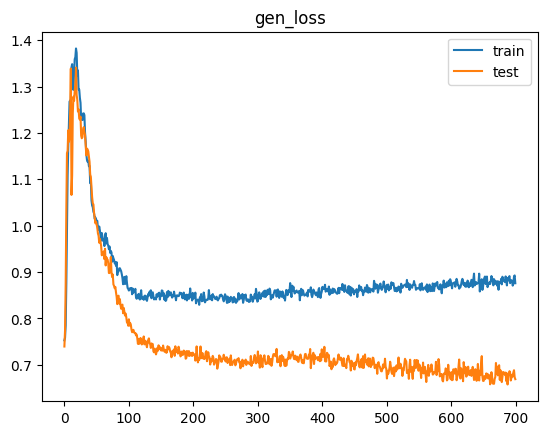

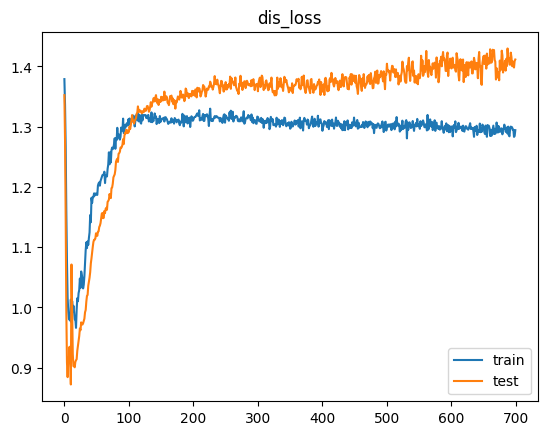

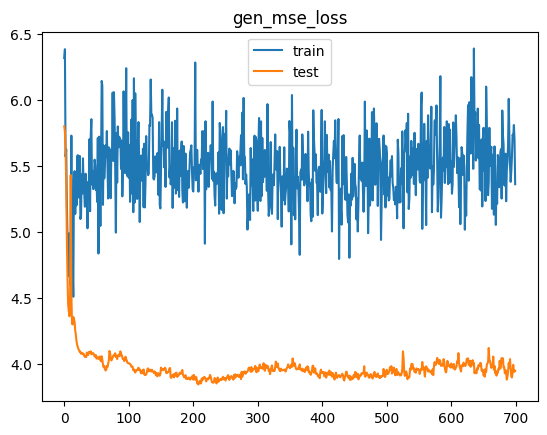

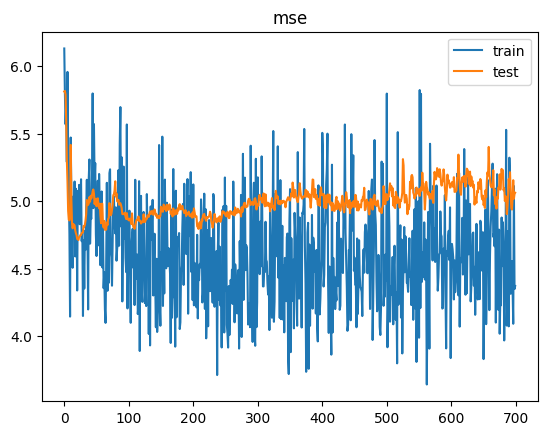

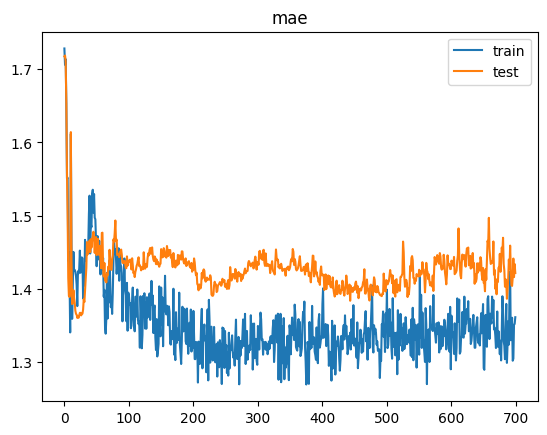

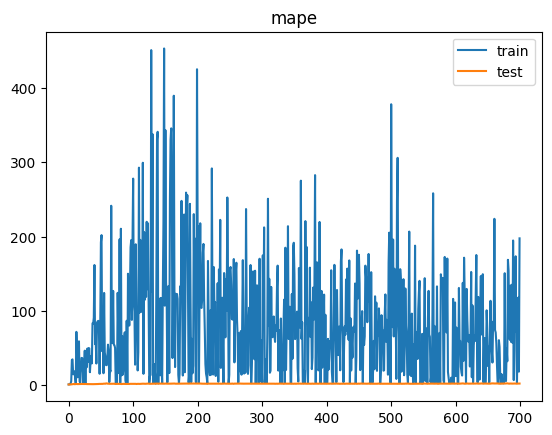

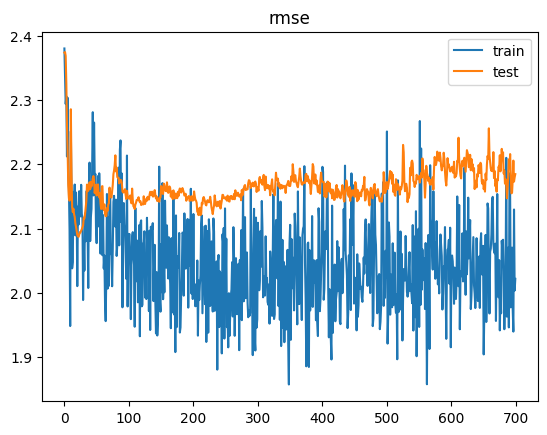

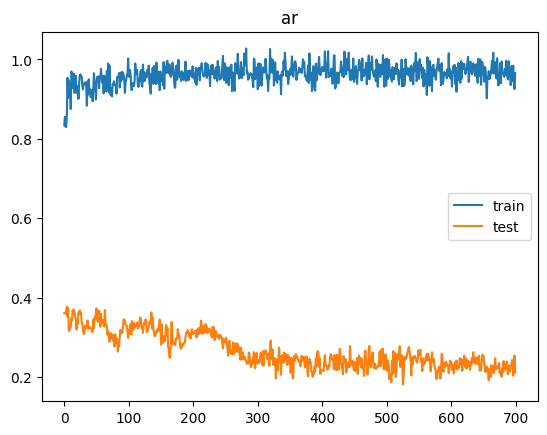

2/2 [==============================] - 0s 2ms/step


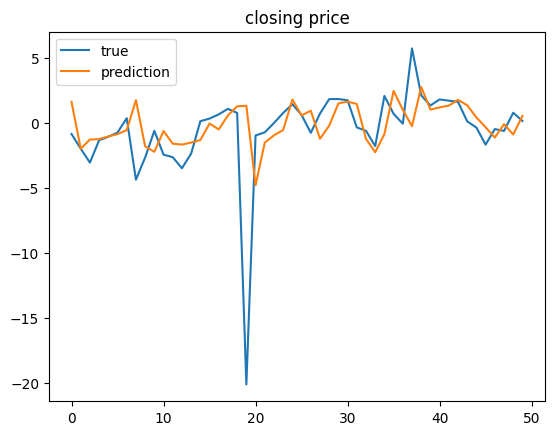

[MSE Baseline] train: 4.446062281711862  test: 4.6881765064049805
Delta time with epochs = 700: 0:09:29.891745
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_6 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_7 (GRU)  

Time for epoch 53 is 0.7619738578796387 sec Generator Loss: 0.9189941883087158,  Discriminator_loss: 1.2568345069885254
Time for epoch 54 is 0.8274581432342529 sec Generator Loss: 0.9104536175727844,  Discriminator_loss: 1.266964316368103
Time for epoch 55 is 0.8217170238494873 sec Generator Loss: 0.9179652333259583,  Discriminator_loss: 1.2668166160583496
Time for epoch 56 is 0.8133547306060791 sec Generator Loss: 0.9219756722450256,  Discriminator_loss: 1.2525243759155273
Time for epoch 57 is 0.7980594635009766 sec Generator Loss: 0.9173381328582764,  Discriminator_loss: 1.2639492750167847
Time for epoch 58 is 0.7888987064361572 sec Generator Loss: 0.911439061164856,  Discriminator_loss: 1.2584797143936157
Time for epoch 59 is 0.8023521900177002 sec Generator Loss: 0.9006849527359009,  Discriminator_loss: 1.2634893655776978
Time for epoch 60 is 0.8408124446868896 sec Generator Loss: 0.9144476652145386,  Discriminator_loss: 1.2633683681488037
Time for epoch 61 is 0.808509111404419 sec

Time for epoch 122 is 0.7714829444885254 sec Generator Loss: 0.8711274266242981,  Discriminator_loss: 1.3009296655654907
Time for epoch 123 is 0.7559425830841064 sec Generator Loss: 0.8707366585731506,  Discriminator_loss: 1.3052399158477783
Time for epoch 124 is 0.7941734790802002 sec Generator Loss: 0.86971116065979,  Discriminator_loss: 1.2989474534988403
Time for epoch 125 is 0.7645065784454346 sec Generator Loss: 0.8660872578620911,  Discriminator_loss: 1.2995952367782593
Time for epoch 126 is 0.7788655757904053 sec Generator Loss: 0.8762269616127014,  Discriminator_loss: 1.3020254373550415
Time for epoch 127 is 0.7616677284240723 sec Generator Loss: 0.8745869994163513,  Discriminator_loss: 1.3021315336227417
Time for epoch 128 is 0.7589890956878662 sec Generator Loss: 0.863914430141449,  Discriminator_loss: 1.307976484298706
Time for epoch 129 is 0.7666969299316406 sec Generator Loss: 0.858101487159729,  Discriminator_loss: 1.2993323802947998
Time for epoch 130 is 0.7596352100372

Time for epoch 191 is 0.8523256778717041 sec Generator Loss: 0.8643184304237366,  Discriminator_loss: 1.3000918626785278
Time for epoch 192 is 0.7987403869628906 sec Generator Loss: 0.8607978224754333,  Discriminator_loss: 1.3024715185165405
Time for epoch 193 is 0.7604444026947021 sec Generator Loss: 0.8678971529006958,  Discriminator_loss: 1.3011372089385986
Time for epoch 194 is 0.7857441902160645 sec Generator Loss: 0.8696491122245789,  Discriminator_loss: 1.2908225059509277
Time for epoch 195 is 0.7665250301361084 sec Generator Loss: 0.8806494474411011,  Discriminator_loss: 1.2892663478851318
Time for epoch 196 is 0.7562878131866455 sec Generator Loss: 0.8649865984916687,  Discriminator_loss: 1.3065663576126099
Time for epoch 197 is 0.7515144348144531 sec Generator Loss: 0.8639155030250549,  Discriminator_loss: 1.29721999168396
Time for epoch 198 is 0.7450847625732422 sec Generator Loss: 0.8640192747116089,  Discriminator_loss: 1.3017656803131104
Time for epoch 199 is 0.7530405521

Time for epoch 259 is 0.768967866897583 sec Generator Loss: 0.8713445067405701,  Discriminator_loss: 1.3026247024536133
Time for epoch 260 is 0.7578141689300537 sec Generator Loss: 0.8795567750930786,  Discriminator_loss: 1.2926386594772339
Time for epoch 261 is 0.7857809066772461 sec Generator Loss: 0.8713876605033875,  Discriminator_loss: 1.2975467443466187
Time for epoch 262 is 0.7544698715209961 sec Generator Loss: 0.8767248392105103,  Discriminator_loss: 1.2906241416931152
Time for epoch 263 is 0.743671178817749 sec Generator Loss: 0.8691498637199402,  Discriminator_loss: 1.295709252357483
Time for epoch 264 is 0.7496356964111328 sec Generator Loss: 0.8761770129203796,  Discriminator_loss: 1.287446141242981
Time for epoch 265 is 0.7796056270599365 sec Generator Loss: 0.8734833002090454,  Discriminator_loss: 1.2961183786392212
Time for epoch 266 is 0.7653050422668457 sec Generator Loss: 0.8611301183700562,  Discriminator_loss: 1.3131608963012695
Time for epoch 267 is 0.763105392456

Time for epoch 328 is 0.7575578689575195 sec Generator Loss: 0.8837171196937561,  Discriminator_loss: 1.2804356813430786
Time for epoch 329 is 0.759119987487793 sec Generator Loss: 0.8806909918785095,  Discriminator_loss: 1.2894024848937988
Time for epoch 330 is 0.7878992557525635 sec Generator Loss: 0.8764799237251282,  Discriminator_loss: 1.2927860021591187
Time for epoch 331 is 0.7893974781036377 sec Generator Loss: 0.8826974630355835,  Discriminator_loss: 1.2812269926071167
Time for epoch 332 is 0.7453410625457764 sec Generator Loss: 0.8893680572509766,  Discriminator_loss: 1.2917050123214722
Time for epoch 333 is 0.7569870948791504 sec Generator Loss: 0.878905177116394,  Discriminator_loss: 1.2932651042938232
Time for epoch 334 is 0.770601749420166 sec Generator Loss: 0.8735264539718628,  Discriminator_loss: 1.2818855047225952
Time for epoch 335 is 0.7830567359924316 sec Generator Loss: 0.8926495909690857,  Discriminator_loss: 1.2816189527511597
Time for epoch 336 is 0.77233147621

Time for epoch 397 is 0.7479288578033447 sec Generator Loss: 0.888820230960846,  Discriminator_loss: 1.285899043083191
Time for epoch 398 is 0.7617876529693604 sec Generator Loss: 0.8923776745796204,  Discriminator_loss: 1.2769012451171875
Time for epoch 399 is 0.7524218559265137 sec Generator Loss: 0.8982000350952148,  Discriminator_loss: 1.278928279876709
Time for epoch 400 is 0.7698535919189453 sec Generator Loss: 0.9018577933311462,  Discriminator_loss: 1.2789760828018188
Time for epoch 401 is 0.7804806232452393 sec Generator Loss: 0.9025364518165588,  Discriminator_loss: 1.2696679830551147
Time for epoch 402 is 0.7616231441497803 sec Generator Loss: 0.8983830809593201,  Discriminator_loss: 1.2722688913345337
Time for epoch 403 is 0.7595412731170654 sec Generator Loss: 0.9019951820373535,  Discriminator_loss: 1.2747544050216675
Time for epoch 404 is 0.7599925994873047 sec Generator Loss: 0.9046456217765808,  Discriminator_loss: 1.2661559581756592
Time for epoch 405 is 0.75375390052

Time for epoch 465 is 0.760185956954956 sec Generator Loss: 0.916246771812439,  Discriminator_loss: 1.267671823501587
Time for epoch 466 is 0.7485778331756592 sec Generator Loss: 0.9097469449043274,  Discriminator_loss: 1.2698566913604736
Time for epoch 467 is 0.7761404514312744 sec Generator Loss: 0.907340943813324,  Discriminator_loss: 1.2625954151153564
Time for epoch 468 is 0.757549524307251 sec Generator Loss: 0.9031789302825928,  Discriminator_loss: 1.27138352394104
Time for epoch 469 is 0.756462574005127 sec Generator Loss: 0.9101957082748413,  Discriminator_loss: 1.2743141651153564
Time for epoch 470 is 0.7754349708557129 sec Generator Loss: 0.9110116362571716,  Discriminator_loss: 1.2654857635498047
Time for epoch 471 is 0.784285306930542 sec Generator Loss: 0.9035203456878662,  Discriminator_loss: 1.2799867391586304
Time for epoch 472 is 0.7581663131713867 sec Generator Loss: 0.9129385948181152,  Discriminator_loss: 1.2704665660858154
Time for epoch 473 is 0.7591755390167236 

Time for epoch 534 is 0.8053264617919922 sec Generator Loss: 0.9127694368362427,  Discriminator_loss: 1.2608327865600586
Time for epoch 535 is 0.8336808681488037 sec Generator Loss: 0.9120345115661621,  Discriminator_loss: 1.264136552810669
Time for epoch 536 is 0.8524646759033203 sec Generator Loss: 0.9220510125160217,  Discriminator_loss: 1.258757472038269
Time for epoch 537 is 0.8314480781555176 sec Generator Loss: 0.9087928533554077,  Discriminator_loss: 1.2719089984893799
Time for epoch 538 is 0.8314990997314453 sec Generator Loss: 0.9175336956977844,  Discriminator_loss: 1.2551056146621704
Time for epoch 539 is 0.7902343273162842 sec Generator Loss: 0.9261804223060608,  Discriminator_loss: 1.2534795999526978
Time for epoch 540 is 0.7653522491455078 sec Generator Loss: 0.9143186807632446,  Discriminator_loss: 1.264643907546997
Time for epoch 541 is 0.7724020481109619 sec Generator Loss: 0.9017899632453918,  Discriminator_loss: 1.2696716785430908
Time for epoch 542 is 0.77278232574

Time for epoch 602 is 0.8543574810028076 sec Generator Loss: 0.9234170317649841,  Discriminator_loss: 1.2639803886413574
Time for epoch 603 is 0.8884828090667725 sec Generator Loss: 0.9231592416763306,  Discriminator_loss: 1.2596830129623413
Time for epoch 604 is 0.8360226154327393 sec Generator Loss: 0.9257672429084778,  Discriminator_loss: 1.256736397743225
Time for epoch 605 is 0.8633067607879639 sec Generator Loss: 0.9105755686759949,  Discriminator_loss: 1.2579623460769653
Time for epoch 606 is 0.890791654586792 sec Generator Loss: 0.9205690026283264,  Discriminator_loss: 1.261719822883606
Time for epoch 607 is 0.8266894817352295 sec Generator Loss: 0.9169825911521912,  Discriminator_loss: 1.2678344249725342
Time for epoch 608 is 0.8901987075805664 sec Generator Loss: 0.9220898747444153,  Discriminator_loss: 1.2524863481521606
Time for epoch 609 is 1.0460631847381592 sec Generator Loss: 0.921432614326477,  Discriminator_loss: 1.2592158317565918
Time for epoch 610 is 0.963182687759

Time for epoch 670 is 0.8513078689575195 sec Generator Loss: 0.934678852558136,  Discriminator_loss: 1.2517690658569336
Time for epoch 671 is 0.8576984405517578 sec Generator Loss: 0.9336389303207397,  Discriminator_loss: 1.2570499181747437
Time for epoch 672 is 0.8861668109893799 sec Generator Loss: 0.9232447743415833,  Discriminator_loss: 1.2596848011016846
Time for epoch 673 is 0.8573470115661621 sec Generator Loss: 0.9231767654418945,  Discriminator_loss: 1.2612063884735107
Time for epoch 674 is 0.8563380241394043 sec Generator Loss: 0.9284368753433228,  Discriminator_loss: 1.2535619735717773
Time for epoch 675 is 0.8398678302764893 sec Generator Loss: 0.9307370185852051,  Discriminator_loss: 1.2609294652938843
Time for epoch 676 is 0.8445379734039307 sec Generator Loss: 0.9378706216812134,  Discriminator_loss: 1.2468047142028809
Time for epoch 677 is 0.8716447353363037 sec Generator Loss: 0.938759982585907,  Discriminator_loss: 1.2547297477722168
Time for epoch 678 is 0.8639552593

Time for epoch 738 is 0.8788642883300781 sec Generator Loss: 0.9251953363418579,  Discriminator_loss: 1.259829044342041
Time for epoch 739 is 0.856177806854248 sec Generator Loss: 0.9596593379974365,  Discriminator_loss: 1.2414593696594238
Time for epoch 740 is 0.8119618892669678 sec Generator Loss: 0.930334746837616,  Discriminator_loss: 1.259786605834961
Time for epoch 741 is 0.791424036026001 sec Generator Loss: 0.9387893676757812,  Discriminator_loss: 1.2485016584396362
Time for epoch 742 is 0.7920536994934082 sec Generator Loss: 0.9373815059661865,  Discriminator_loss: 1.2519407272338867
Time for epoch 743 is 0.7884976863861084 sec Generator Loss: 0.9281150102615356,  Discriminator_loss: 1.264935851097107
Time for epoch 744 is 0.8254773616790771 sec Generator Loss: 0.9268903732299805,  Discriminator_loss: 1.2628967761993408
Time for epoch 745 is 0.8117728233337402 sec Generator Loss: 0.9225935339927673,  Discriminator_loss: 1.2549630403518677
Time for epoch 746 is 0.82356333732604

Time for epoch 806 is 0.8633325099945068 sec Generator Loss: 0.9353903532028198,  Discriminator_loss: 1.264492154121399
Time for epoch 807 is 0.8520114421844482 sec Generator Loss: 0.9452407956123352,  Discriminator_loss: 1.232067346572876
Time for epoch 808 is 0.8346397876739502 sec Generator Loss: 0.940527081489563,  Discriminator_loss: 1.2448714971542358
Time for epoch 809 is 0.8267796039581299 sec Generator Loss: 0.9259803295135498,  Discriminator_loss: 1.2548552751541138
Time for epoch 810 is 0.8695676326751709 sec Generator Loss: 0.9410982131958008,  Discriminator_loss: 1.2507845163345337
Time for epoch 811 is 0.846125602722168 sec Generator Loss: 0.9428481459617615,  Discriminator_loss: 1.2511351108551025
Time for epoch 812 is 0.90338134765625 sec Generator Loss: 0.9389185309410095,  Discriminator_loss: 1.2551895380020142
Time for epoch 813 is 0.844484806060791 sec Generator Loss: 0.926171600818634,  Discriminator_loss: 1.2646211385726929
Time for epoch 814 is 0.854423999786377 

Time for epoch 875 is 0.8636739253997803 sec Generator Loss: 0.9370402693748474,  Discriminator_loss: 1.2493667602539062
Time for epoch 876 is 0.8249721527099609 sec Generator Loss: 0.9397057294845581,  Discriminator_loss: 1.2515853643417358
Time for epoch 877 is 0.8511002063751221 sec Generator Loss: 0.9461351037025452,  Discriminator_loss: 1.2449216842651367
Time for epoch 878 is 0.8224196434020996 sec Generator Loss: 0.9249933362007141,  Discriminator_loss: 1.2605031728744507
Time for epoch 879 is 0.8375716209411621 sec Generator Loss: 0.9443243741989136,  Discriminator_loss: 1.2499068975448608
Time for epoch 880 is 0.8369746208190918 sec Generator Loss: 0.9269545078277588,  Discriminator_loss: 1.2514148950576782
Time for epoch 881 is 0.864213228225708 sec Generator Loss: 0.9433230757713318,  Discriminator_loss: 1.2435574531555176
Time for epoch 882 is 0.8421504497528076 sec Generator Loss: 0.9327967166900635,  Discriminator_loss: 1.253688931465149
Time for epoch 883 is 0.8747537136

Time for epoch 943 is 0.852039098739624 sec Generator Loss: 0.9476332664489746,  Discriminator_loss: 1.2423231601715088
Time for epoch 944 is 0.8585410118103027 sec Generator Loss: 0.9481450915336609,  Discriminator_loss: 1.2503412961959839
Time for epoch 945 is 0.8556034564971924 sec Generator Loss: 0.9286929368972778,  Discriminator_loss: 1.2513562440872192
Time for epoch 946 is 0.8775303363800049 sec Generator Loss: 0.9345483779907227,  Discriminator_loss: 1.252974033355713
Time for epoch 947 is 0.8639082908630371 sec Generator Loss: 0.9358866214752197,  Discriminator_loss: 1.2504819631576538
Time for epoch 948 is 0.8564870357513428 sec Generator Loss: 0.9525377750396729,  Discriminator_loss: 1.2441943883895874
Time for epoch 949 is 0.9034631252288818 sec Generator Loss: 0.9304376244544983,  Discriminator_loss: 1.25876784324646
Time for epoch 950 is 0.8642911911010742 sec Generator Loss: 0.9390403032302856,  Discriminator_loss: 1.2489091157913208


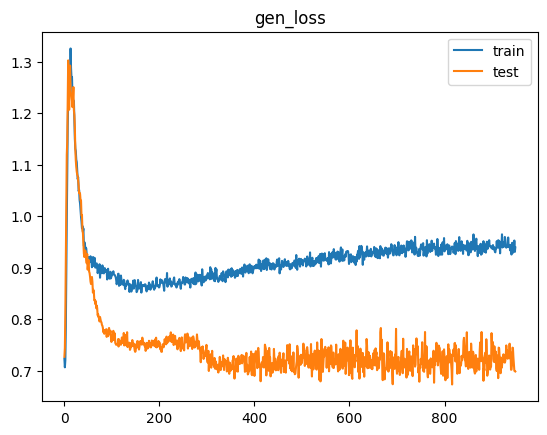

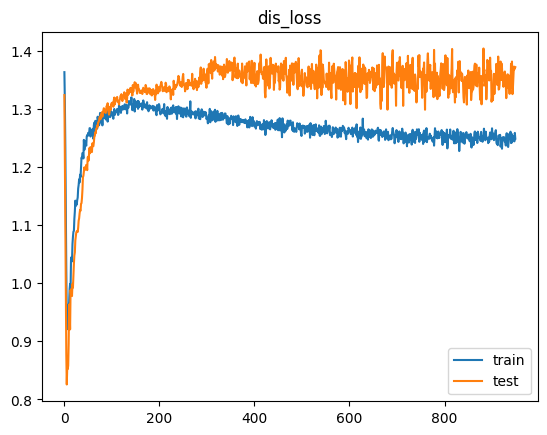

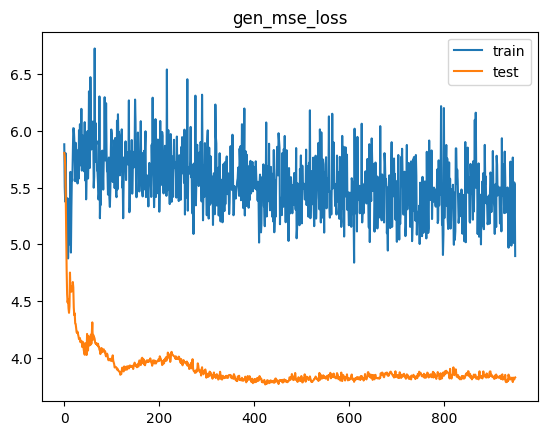

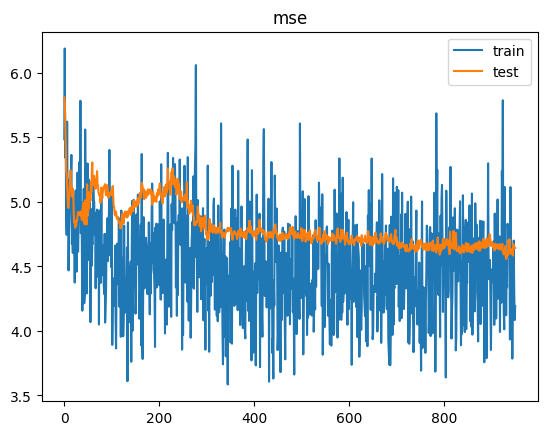

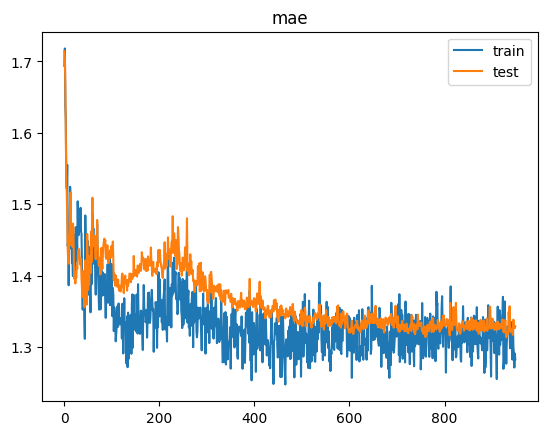

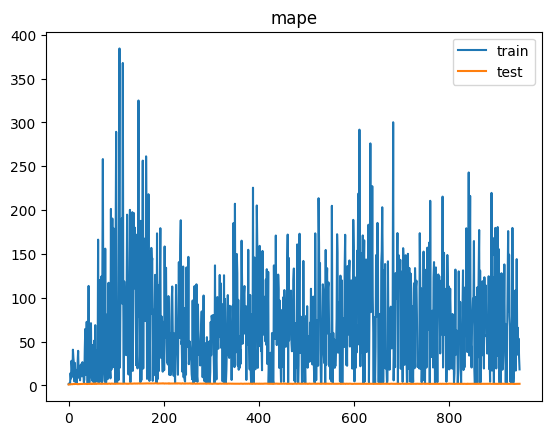

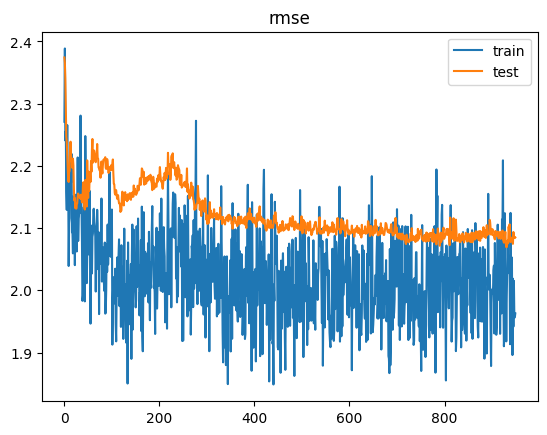

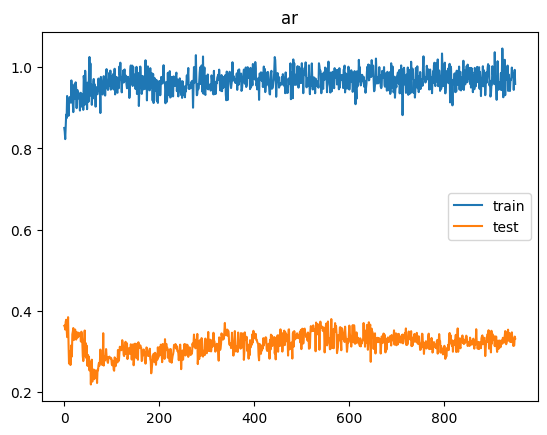

2/2 [==============================] - 0s 3ms/step


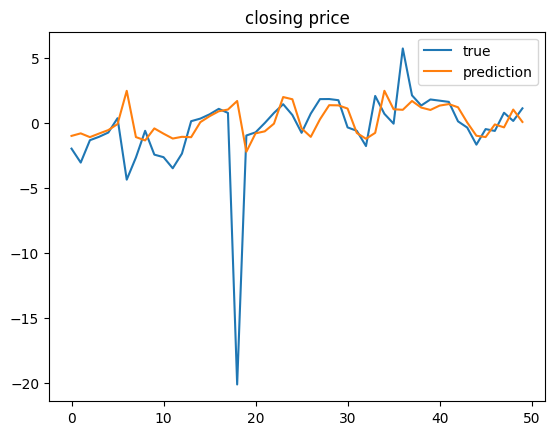

[MSE Baseline] train: 4.138392001952317  test: 4.68758521157695
Delta time with epochs = 950: 0:12:58.870518
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_9 (GRU)    

Time for epoch 53 is 0.8655571937561035 sec Generator Loss: 1.0186896324157715,  Discriminator_loss: 1.2010645866394043
Time for epoch 54 is 0.8670511245727539 sec Generator Loss: 1.0298422574996948,  Discriminator_loss: 1.202136516571045
Time for epoch 55 is 0.9019582271575928 sec Generator Loss: 0.999557614326477,  Discriminator_loss: 1.2146581411361694
Time for epoch 56 is 0.9801895618438721 sec Generator Loss: 0.9990448355674744,  Discriminator_loss: 1.2254563570022583
Time for epoch 57 is 0.9196474552154541 sec Generator Loss: 0.974659264087677,  Discriminator_loss: 1.232911467552185
Time for epoch 58 is 0.9899818897247314 sec Generator Loss: 0.9960128664970398,  Discriminator_loss: 1.2187165021896362
Time for epoch 59 is 0.8987617492675781 sec Generator Loss: 0.9836245775222778,  Discriminator_loss: 1.2248567342758179
Time for epoch 60 is 0.8432691097259521 sec Generator Loss: 0.9820947051048279,  Discriminator_loss: 1.2242244482040405
Time for epoch 61 is 0.8736507892608643 sec 

Time for epoch 122 is 0.8583402633666992 sec Generator Loss: 0.8962785601615906,  Discriminator_loss: 1.286799669265747
Time for epoch 123 is 0.8268921375274658 sec Generator Loss: 0.88982754945755,  Discriminator_loss: 1.2967109680175781
Time for epoch 124 is 0.8696193695068359 sec Generator Loss: 0.8861538767814636,  Discriminator_loss: 1.284595012664795
Time for epoch 125 is 0.8801357746124268 sec Generator Loss: 0.9025430679321289,  Discriminator_loss: 1.2870815992355347
Time for epoch 126 is 0.8546602725982666 sec Generator Loss: 0.910959780216217,  Discriminator_loss: 1.2738654613494873
Time for epoch 127 is 0.8509280681610107 sec Generator Loss: 0.8842694759368896,  Discriminator_loss: 1.2925972938537598
Time for epoch 128 is 0.8698468208312988 sec Generator Loss: 0.8915945291519165,  Discriminator_loss: 1.294424295425415
Time for epoch 129 is 0.8845014572143555 sec Generator Loss: 0.9032240509986877,  Discriminator_loss: 1.2895487546920776
Time for epoch 130 is 0.86551165580749

Time for epoch 191 is 0.8751065731048584 sec Generator Loss: 0.8926815390586853,  Discriminator_loss: 1.2908202409744263
Time for epoch 192 is 0.8371396064758301 sec Generator Loss: 0.8956570625305176,  Discriminator_loss: 1.2843843698501587
Time for epoch 193 is 0.8615238666534424 sec Generator Loss: 0.8933318257331848,  Discriminator_loss: 1.2897216081619263
Time for epoch 194 is 0.8530585765838623 sec Generator Loss: 0.8798927068710327,  Discriminator_loss: 1.28879976272583
Time for epoch 195 is 0.845142126083374 sec Generator Loss: 0.90044105052948,  Discriminator_loss: 1.2765201330184937
Time for epoch 196 is 0.8972606658935547 sec Generator Loss: 0.8791147470474243,  Discriminator_loss: 1.3043653964996338
Time for epoch 197 is 0.8709521293640137 sec Generator Loss: 0.892147421836853,  Discriminator_loss: 1.2835192680358887
Time for epoch 198 is 0.8406116962432861 sec Generator Loss: 0.8917680978775024,  Discriminator_loss: 1.289520502090454
Time for epoch 199 is 0.856000185012817

Time for epoch 260 is 0.8985297679901123 sec Generator Loss: 0.8895928263664246,  Discriminator_loss: 1.28741455078125
Time for epoch 261 is 0.8671765327453613 sec Generator Loss: 0.8917985558509827,  Discriminator_loss: 1.2795305252075195
Time for epoch 262 is 0.8797786235809326 sec Generator Loss: 0.8997554183006287,  Discriminator_loss: 1.2848583459854126
Time for epoch 263 is 0.8898098468780518 sec Generator Loss: 0.9073748588562012,  Discriminator_loss: 1.2751002311706543
Time for epoch 264 is 0.891718864440918 sec Generator Loss: 0.9086281657218933,  Discriminator_loss: 1.2705219984054565
Time for epoch 265 is 0.8446249961853027 sec Generator Loss: 0.8975878357887268,  Discriminator_loss: 1.2824997901916504
Time for epoch 266 is 0.8521475791931152 sec Generator Loss: 0.894965648651123,  Discriminator_loss: 1.2868765592575073
Time for epoch 267 is 0.8646535873413086 sec Generator Loss: 0.8884807825088501,  Discriminator_loss: 1.2865304946899414
Time for epoch 268 is 0.901128768920

Time for epoch 329 is 0.8780076503753662 sec Generator Loss: 0.9025276303291321,  Discriminator_loss: 1.2747077941894531
Time for epoch 330 is 0.8911244869232178 sec Generator Loss: 0.9060274958610535,  Discriminator_loss: 1.278344988822937
Time for epoch 331 is 0.8690731525421143 sec Generator Loss: 0.9051697254180908,  Discriminator_loss: 1.2836453914642334
Time for epoch 332 is 0.8752086162567139 sec Generator Loss: 0.8967874646186829,  Discriminator_loss: 1.2815438508987427
Time for epoch 333 is 0.8483436107635498 sec Generator Loss: 0.9088029861450195,  Discriminator_loss: 1.280558705329895
Time for epoch 334 is 0.8900039196014404 sec Generator Loss: 0.8907219767570496,  Discriminator_loss: 1.2870951890945435
Time for epoch 335 is 0.8912551403045654 sec Generator Loss: 0.8900321125984192,  Discriminator_loss: 1.284009575843811
Time for epoch 336 is 0.8426151275634766 sec Generator Loss: 0.9029147028923035,  Discriminator_loss: 1.2851862907409668
Time for epoch 337 is 0.85788774490

Time for epoch 398 is 1.0758347511291504 sec Generator Loss: 0.8897350430488586,  Discriminator_loss: 1.296933650970459
Time for epoch 399 is 1.0078372955322266 sec Generator Loss: 0.901291012763977,  Discriminator_loss: 1.2834757566452026
Time for epoch 400 is 0.8319387435913086 sec Generator Loss: 0.8946609497070312,  Discriminator_loss: 1.2890195846557617
Time for epoch 401 is 0.858877420425415 sec Generator Loss: 0.8701140880584717,  Discriminator_loss: 1.3018583059310913
Time for epoch 402 is 0.8466551303863525 sec Generator Loss: 0.8763291239738464,  Discriminator_loss: 1.2911945581436157
Time for epoch 403 is 0.8833110332489014 sec Generator Loss: 0.898151159286499,  Discriminator_loss: 1.2899366617202759
Time for epoch 404 is 0.8522989749908447 sec Generator Loss: 0.869366466999054,  Discriminator_loss: 1.2997617721557617
Time for epoch 405 is 0.872298002243042 sec Generator Loss: 0.881333589553833,  Discriminator_loss: 1.2967220544815063
Time for epoch 406 is 0.841229438781738

Time for epoch 467 is 0.9324984550476074 sec Generator Loss: 0.8777734041213989,  Discriminator_loss: 1.290084719657898
Time for epoch 468 is 0.9050617218017578 sec Generator Loss: 0.8749955892562866,  Discriminator_loss: 1.3051307201385498
Time for epoch 469 is 0.8750855922698975 sec Generator Loss: 0.8794831037521362,  Discriminator_loss: 1.302240014076233
Time for epoch 470 is 0.9171276092529297 sec Generator Loss: 0.882905900478363,  Discriminator_loss: 1.2919553518295288
Time for epoch 471 is 0.8786256313323975 sec Generator Loss: 0.8889283537864685,  Discriminator_loss: 1.2956700325012207
Time for epoch 472 is 0.8682076930999756 sec Generator Loss: 0.879306972026825,  Discriminator_loss: 1.2902313470840454
Time for epoch 473 is 0.8978779315948486 sec Generator Loss: 0.8900503516197205,  Discriminator_loss: 1.2930251359939575
Time for epoch 474 is 0.8723316192626953 sec Generator Loss: 0.8839101195335388,  Discriminator_loss: 1.2979638576507568
Time for epoch 475 is 0.878937005996

Time for epoch 536 is 0.9055371284484863 sec Generator Loss: 0.8892239928245544,  Discriminator_loss: 1.2996281385421753
Time for epoch 537 is 0.9433145523071289 sec Generator Loss: 0.8707951307296753,  Discriminator_loss: 1.3020585775375366
Time for epoch 538 is 1.0780229568481445 sec Generator Loss: 0.867270290851593,  Discriminator_loss: 1.3027349710464478
Time for epoch 539 is 0.9197592735290527 sec Generator Loss: 0.8651090264320374,  Discriminator_loss: 1.3048895597457886
Time for epoch 540 is 0.8569283485412598 sec Generator Loss: 0.8870202302932739,  Discriminator_loss: 1.2897709608078003
Time for epoch 541 is 0.8869202136993408 sec Generator Loss: 0.8741483688354492,  Discriminator_loss: 1.2986109256744385
Time for epoch 542 is 0.9322853088378906 sec Generator Loss: 0.8704473376274109,  Discriminator_loss: 1.30062735080719
Time for epoch 543 is 0.866765022277832 sec Generator Loss: 0.8757092356681824,  Discriminator_loss: 1.2938915491104126
Time for epoch 544 is 0.891851425170

Time for epoch 604 is 0.9365513324737549 sec Generator Loss: 0.8706450462341309,  Discriminator_loss: 1.3044555187225342
Time for epoch 605 is 0.8564519882202148 sec Generator Loss: 0.8877205848693848,  Discriminator_loss: 1.2883036136627197
Time for epoch 606 is 0.8548107147216797 sec Generator Loss: 0.8810641765594482,  Discriminator_loss: 1.2950479984283447
Time for epoch 607 is 0.8641641139984131 sec Generator Loss: 0.8914688229560852,  Discriminator_loss: 1.2916206121444702
Time for epoch 608 is 0.8875560760498047 sec Generator Loss: 0.8743545413017273,  Discriminator_loss: 1.3056153059005737
Time for epoch 609 is 0.9341127872467041 sec Generator Loss: 0.8685125112533569,  Discriminator_loss: 1.3042737245559692
Time for epoch 610 is 0.8958351612091064 sec Generator Loss: 0.8830736875534058,  Discriminator_loss: 1.302897334098816
Time for epoch 611 is 0.9083631038665771 sec Generator Loss: 0.8806469440460205,  Discriminator_loss: 1.297899842262268
Time for epoch 612 is 0.9233775138

Time for epoch 672 is 0.8593649864196777 sec Generator Loss: 0.8887314200401306,  Discriminator_loss: 1.2931867837905884
Time for epoch 673 is 0.8767571449279785 sec Generator Loss: 0.8819054961204529,  Discriminator_loss: 1.2959873676300049
Time for epoch 674 is 0.8363232612609863 sec Generator Loss: 0.8774582743644714,  Discriminator_loss: 1.296539545059204
Time for epoch 675 is 0.8461456298828125 sec Generator Loss: 0.8847723007202148,  Discriminator_loss: 1.2952769994735718
Time for epoch 676 is 0.8433628082275391 sec Generator Loss: 0.8971540331840515,  Discriminator_loss: 1.2859352827072144
Time for epoch 677 is 0.8398067951202393 sec Generator Loss: 0.8941538333892822,  Discriminator_loss: 1.29121732711792
Time for epoch 678 is 0.8693006038665771 sec Generator Loss: 0.8717430233955383,  Discriminator_loss: 1.3037338256835938
Time for epoch 679 is 0.8450419902801514 sec Generator Loss: 0.8914126753807068,  Discriminator_loss: 1.2961227893829346
Time for epoch 680 is 0.84471225738

Time for epoch 740 is 1.0062737464904785 sec Generator Loss: 0.8858547806739807,  Discriminator_loss: 1.3080546855926514
Time for epoch 741 is 1.0175111293792725 sec Generator Loss: 0.8965093493461609,  Discriminator_loss: 1.2964204549789429
Time for epoch 742 is 0.9613378047943115 sec Generator Loss: 0.8852225542068481,  Discriminator_loss: 1.2959216833114624
Time for epoch 743 is 0.9276943206787109 sec Generator Loss: 0.8898903727531433,  Discriminator_loss: 1.291314721107483
Time for epoch 744 is 0.8573634624481201 sec Generator Loss: 0.8761934638023376,  Discriminator_loss: 1.294866681098938
Time for epoch 745 is 0.8722529411315918 sec Generator Loss: 0.866664707660675,  Discriminator_loss: 1.3016279935836792
Time for epoch 746 is 0.8425827026367188 sec Generator Loss: 0.8741967082023621,  Discriminator_loss: 1.2950881719589233
Time for epoch 747 is 0.8817484378814697 sec Generator Loss: 0.884766697883606,  Discriminator_loss: 1.297982096672058
Time for epoch 748 is 0.8536713123321

Time for epoch 809 is 0.8987014293670654 sec Generator Loss: 0.8907808661460876,  Discriminator_loss: 1.299436092376709
Time for epoch 810 is 0.9466049671173096 sec Generator Loss: 0.8721665143966675,  Discriminator_loss: 1.3033342361450195
Time for epoch 811 is 0.8830537796020508 sec Generator Loss: 0.881803035736084,  Discriminator_loss: 1.3039686679840088
Time for epoch 812 is 0.852776050567627 sec Generator Loss: 0.903545081615448,  Discriminator_loss: 1.2873488664627075
Time for epoch 813 is 0.8911657333374023 sec Generator Loss: 0.8881918787956238,  Discriminator_loss: 1.2916866540908813
Time for epoch 814 is 0.84810471534729 sec Generator Loss: 0.9011915326118469,  Discriminator_loss: 1.2885241508483887
Time for epoch 815 is 0.875995397567749 sec Generator Loss: 0.8921434283256531,  Discriminator_loss: 1.2899750471115112
Time for epoch 816 is 0.8489794731140137 sec Generator Loss: 0.8951534628868103,  Discriminator_loss: 1.2809072732925415
Time for epoch 817 is 0.902618408203125

Time for epoch 877 is 0.8265001773834229 sec Generator Loss: 0.9058907628059387,  Discriminator_loss: 1.2829883098602295
Time for epoch 878 is 0.8552751541137695 sec Generator Loss: 0.8986685872077942,  Discriminator_loss: 1.2883843183517456
Time for epoch 879 is 0.8605477809906006 sec Generator Loss: 0.9013945460319519,  Discriminator_loss: 1.2877919673919678
Time for epoch 880 is 0.8447575569152832 sec Generator Loss: 0.9007478356361389,  Discriminator_loss: 1.2925444841384888
Time for epoch 881 is 0.8590219020843506 sec Generator Loss: 0.8929212689399719,  Discriminator_loss: 1.288341999053955
Time for epoch 882 is 0.8289752006530762 sec Generator Loss: 0.8886508345603943,  Discriminator_loss: 1.2916526794433594
Time for epoch 883 is 0.8560819625854492 sec Generator Loss: 0.8976766467094421,  Discriminator_loss: 1.2844536304473877
Time for epoch 884 is 0.8638041019439697 sec Generator Loss: 0.8914852738380432,  Discriminator_loss: 1.2899528741836548
Time for epoch 885 is 0.856272220

Time for epoch 945 is 0.8096907138824463 sec Generator Loss: 0.8845974206924438,  Discriminator_loss: 1.291585087776184
Time for epoch 946 is 0.796144962310791 sec Generator Loss: 0.8892784714698792,  Discriminator_loss: 1.2910866737365723
Time for epoch 947 is 0.8103141784667969 sec Generator Loss: 0.9021226167678833,  Discriminator_loss: 1.2826076745986938
Time for epoch 948 is 0.8180174827575684 sec Generator Loss: 0.8954329490661621,  Discriminator_loss: 1.2870213985443115
Time for epoch 949 is 0.7895200252532959 sec Generator Loss: 0.9054269194602966,  Discriminator_loss: 1.2824242115020752
Time for epoch 950 is 0.8178231716156006 sec Generator Loss: 0.8838288187980652,  Discriminator_loss: 1.2883049249649048
Time for epoch 951 is 0.8519065380096436 sec Generator Loss: 0.8982765078544617,  Discriminator_loss: 1.2920645475387573
Time for epoch 952 is 0.8460087776184082 sec Generator Loss: 0.9078567028045654,  Discriminator_loss: 1.2862892150878906
Time for epoch 953 is 0.8494884967

Time for epoch 1013 is 0.7938756942749023 sec Generator Loss: 0.9069874286651611,  Discriminator_loss: 1.2899125814437866
Time for epoch 1014 is 0.7953438758850098 sec Generator Loss: 0.9009209275245667,  Discriminator_loss: 1.2819545269012451
Time for epoch 1015 is 0.8015508651733398 sec Generator Loss: 0.91020268201828,  Discriminator_loss: 1.2784043550491333
Time for epoch 1016 is 0.7847545146942139 sec Generator Loss: 0.8987529277801514,  Discriminator_loss: 1.284093976020813
Time for epoch 1017 is 0.7772071361541748 sec Generator Loss: 0.9003282785415649,  Discriminator_loss: 1.280043601989746
Time for epoch 1018 is 0.7583389282226562 sec Generator Loss: 0.9057101011276245,  Discriminator_loss: 1.289278268814087
Time for epoch 1019 is 0.7615747451782227 sec Generator Loss: 0.9045378565788269,  Discriminator_loss: 1.2810413837432861
Time for epoch 1020 is 0.7902913093566895 sec Generator Loss: 0.9089229106903076,  Discriminator_loss: 1.277351975440979
Time for epoch 1021 is 0.79374

Time for epoch 1081 is 0.8003804683685303 sec Generator Loss: 0.8961656093597412,  Discriminator_loss: 1.279320240020752
Time for epoch 1082 is 0.7979812622070312 sec Generator Loss: 0.9016445875167847,  Discriminator_loss: 1.2900594472885132
Time for epoch 1083 is 0.8049376010894775 sec Generator Loss: 0.9177243113517761,  Discriminator_loss: 1.2751466035842896
Time for epoch 1084 is 0.8263251781463623 sec Generator Loss: 0.9002461433410645,  Discriminator_loss: 1.288079023361206
Time for epoch 1085 is 0.8027687072753906 sec Generator Loss: 0.8968861699104309,  Discriminator_loss: 1.2844926118850708
Time for epoch 1086 is 0.8159503936767578 sec Generator Loss: 0.9071095585823059,  Discriminator_loss: 1.2801448106765747
Time for epoch 1087 is 0.8003747463226318 sec Generator Loss: 0.9079751372337341,  Discriminator_loss: 1.2790278196334839
Time for epoch 1088 is 0.804922342300415 sec Generator Loss: 0.9067398905754089,  Discriminator_loss: 1.2833569049835205
Time for epoch 1089 is 0.79

Time for epoch 1149 is 0.8195850849151611 sec Generator Loss: 0.9033604264259338,  Discriminator_loss: 1.2838573455810547
Time for epoch 1150 is 0.8399851322174072 sec Generator Loss: 0.8920970559120178,  Discriminator_loss: 1.2883912324905396
Time for epoch 1151 is 0.7888991832733154 sec Generator Loss: 0.9137126803398132,  Discriminator_loss: 1.2762866020202637
Time for epoch 1152 is 0.7980532646179199 sec Generator Loss: 0.8933330178260803,  Discriminator_loss: 1.2838789224624634
Time for epoch 1153 is 0.787905216217041 sec Generator Loss: 0.9152835607528687,  Discriminator_loss: 1.2727009057998657
Time for epoch 1154 is 0.7932488918304443 sec Generator Loss: 0.9109097719192505,  Discriminator_loss: 1.2832671403884888
Time for epoch 1155 is 0.7933266162872314 sec Generator Loss: 0.9076243042945862,  Discriminator_loss: 1.284205436706543
Time for epoch 1156 is 0.8404748439788818 sec Generator Loss: 0.9108866453170776,  Discriminator_loss: 1.2798500061035156
Time for epoch 1157 is 0.8

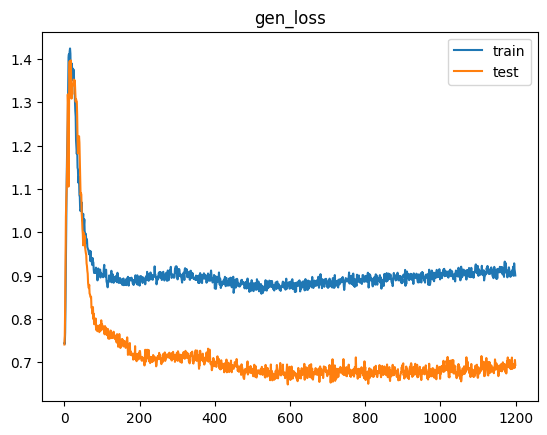

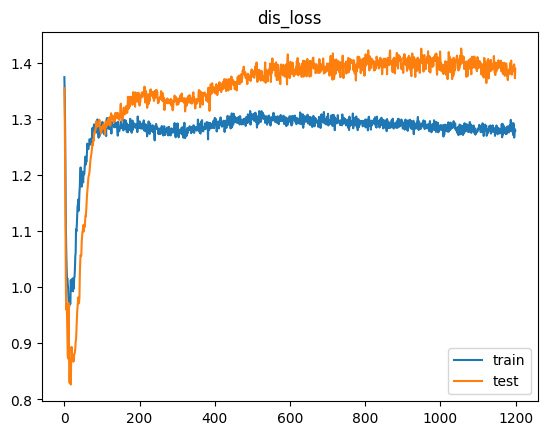

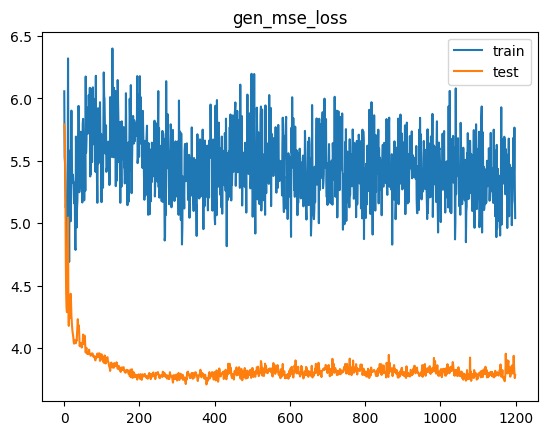

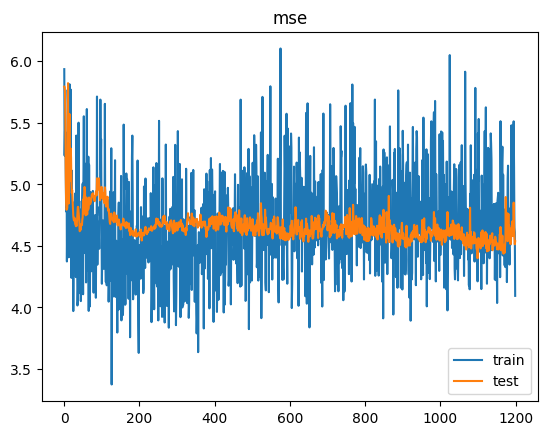

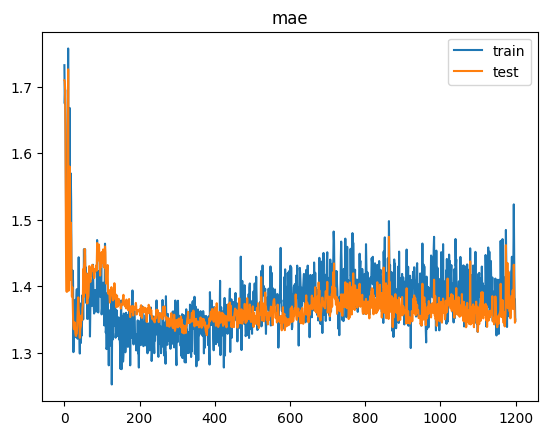

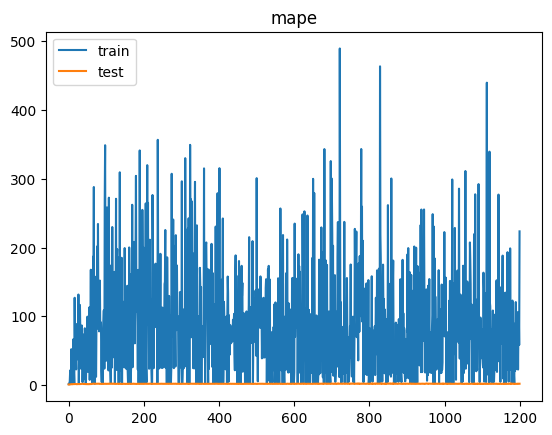

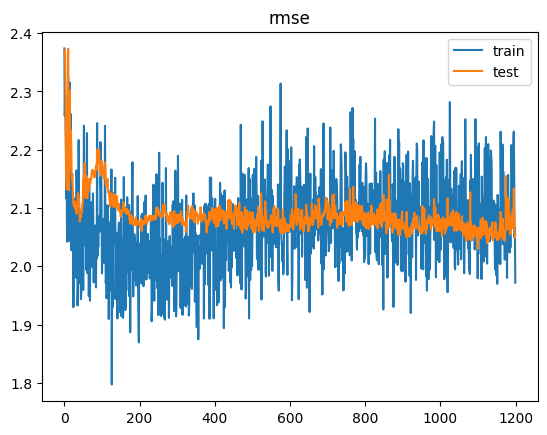

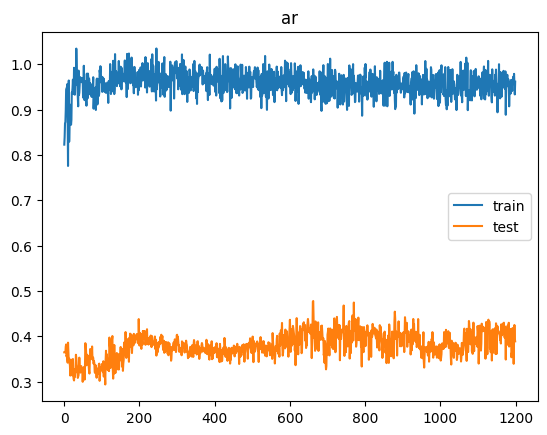

2/2 [==============================] - 0s 3ms/step


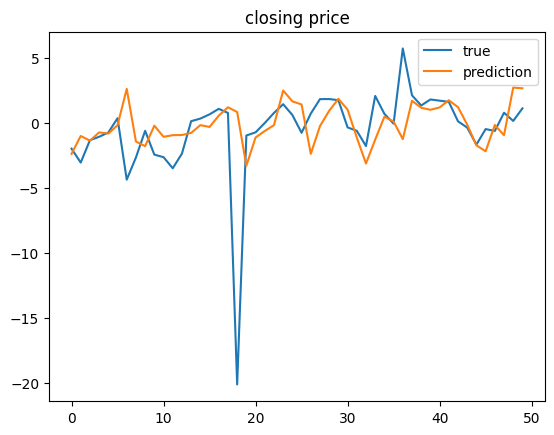

[MSE Baseline] train: 4.431854741539605  test: 4.68758521157695
Delta time with epochs = 1200: 0:17:20.403379
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_10 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_11 (GRU)  

Time for epoch 53 is 0.8155491352081299 sec Generator Loss: 0.9447218775749207,  Discriminator_loss: 1.232011318206787
Time for epoch 54 is 0.869746208190918 sec Generator Loss: 0.9476202726364136,  Discriminator_loss: 1.2339401245117188
Time for epoch 55 is 0.8098647594451904 sec Generator Loss: 0.9427787661552429,  Discriminator_loss: 1.23263680934906
Time for epoch 56 is 0.8118586540222168 sec Generator Loss: 0.9291460514068604,  Discriminator_loss: 1.2407653331756592
Time for epoch 57 is 0.8103756904602051 sec Generator Loss: 0.9332748651504517,  Discriminator_loss: 1.239035725593567
Time for epoch 58 is 0.8065712451934814 sec Generator Loss: 0.9322468042373657,  Discriminator_loss: 1.2283148765563965
Time for epoch 59 is 0.8185410499572754 sec Generator Loss: 0.9385606646537781,  Discriminator_loss: 1.2486823797225952
Time for epoch 60 is 0.8171656131744385 sec Generator Loss: 0.9270819425582886,  Discriminator_loss: 1.2377891540527344
Time for epoch 61 is 0.8109619617462158 sec G

Time for epoch 122 is 0.8699808120727539 sec Generator Loss: 0.8537683486938477,  Discriminator_loss: 1.3043098449707031
Time for epoch 123 is 0.8672137260437012 sec Generator Loss: 0.8410980701446533,  Discriminator_loss: 1.3098387718200684
Time for epoch 124 is 0.8480172157287598 sec Generator Loss: 0.853550136089325,  Discriminator_loss: 1.3139057159423828
Time for epoch 125 is 0.857980489730835 sec Generator Loss: 0.8586056232452393,  Discriminator_loss: 1.3003774881362915
Time for epoch 126 is 0.8926327228546143 sec Generator Loss: 0.8539721965789795,  Discriminator_loss: 1.3085854053497314
Time for epoch 127 is 0.8506364822387695 sec Generator Loss: 0.8512865900993347,  Discriminator_loss: 1.3038617372512817
Time for epoch 128 is 0.8378753662109375 sec Generator Loss: 0.8578090071678162,  Discriminator_loss: 1.3144304752349854
Time for epoch 129 is 0.8568212985992432 sec Generator Loss: 0.8620232939720154,  Discriminator_loss: 1.2985128164291382
Time for epoch 130 is 0.8477084636

Time for epoch 190 is 0.865614652633667 sec Generator Loss: 0.8532946705818176,  Discriminator_loss: 1.2983444929122925
Time for epoch 191 is 0.8914749622344971 sec Generator Loss: 0.8492085933685303,  Discriminator_loss: 1.3144433498382568
Time for epoch 192 is 0.9935324192047119 sec Generator Loss: 0.8657834529876709,  Discriminator_loss: 1.3044168949127197
Time for epoch 193 is 1.0477509498596191 sec Generator Loss: 0.8578730821609497,  Discriminator_loss: 1.288962483406067
Time for epoch 194 is 0.8990151882171631 sec Generator Loss: 0.8549947738647461,  Discriminator_loss: 1.2981979846954346
Time for epoch 195 is 0.8603811264038086 sec Generator Loss: 0.8677513599395752,  Discriminator_loss: 1.303019404411316
Time for epoch 196 is 0.893662691116333 sec Generator Loss: 0.8609058260917664,  Discriminator_loss: 1.3011112213134766
Time for epoch 197 is 0.8829760551452637 sec Generator Loss: 0.8736878633499146,  Discriminator_loss: 1.292000412940979
Time for epoch 198 is 0.8847510814666

Time for epoch 258 is 0.8553242683410645 sec Generator Loss: 0.8676842451095581,  Discriminator_loss: 1.2904062271118164
Time for epoch 259 is 0.8671133518218994 sec Generator Loss: 0.8742658495903015,  Discriminator_loss: 1.296099305152893
Time for epoch 260 is 0.8602442741394043 sec Generator Loss: 0.8610469698905945,  Discriminator_loss: 1.3091682195663452
Time for epoch 261 is 0.8956129550933838 sec Generator Loss: 0.8698967099189758,  Discriminator_loss: 1.2979588508605957
Time for epoch 262 is 0.8628544807434082 sec Generator Loss: 0.8666709661483765,  Discriminator_loss: 1.298897385597229
Time for epoch 263 is 0.8116128444671631 sec Generator Loss: 0.8701863288879395,  Discriminator_loss: 1.2934156656265259
Time for epoch 264 is 0.8472082614898682 sec Generator Loss: 0.874148428440094,  Discriminator_loss: 1.2912366390228271
Time for epoch 265 is 0.8217206001281738 sec Generator Loss: 0.8672856092453003,  Discriminator_loss: 1.301530122756958
Time for epoch 266 is 0.809530019760

Time for epoch 326 is 0.8539414405822754 sec Generator Loss: 0.8834670186042786,  Discriminator_loss: 1.2898025512695312
Time for epoch 327 is 0.8590471744537354 sec Generator Loss: 0.8796505928039551,  Discriminator_loss: 1.2847267389297485
Time for epoch 328 is 0.8647251129150391 sec Generator Loss: 0.8835389614105225,  Discriminator_loss: 1.2887979745864868
Time for epoch 329 is 0.8552987575531006 sec Generator Loss: 0.8808158040046692,  Discriminator_loss: 1.2948719263076782
Time for epoch 330 is 0.8604538440704346 sec Generator Loss: 0.8753357529640198,  Discriminator_loss: 1.2919230461120605
Time for epoch 331 is 0.8485360145568848 sec Generator Loss: 0.869473934173584,  Discriminator_loss: 1.307619333267212
Time for epoch 332 is 0.8615846633911133 sec Generator Loss: 0.8791393637657166,  Discriminator_loss: 1.2947118282318115
Time for epoch 333 is 0.8739569187164307 sec Generator Loss: 0.8792548775672913,  Discriminator_loss: 1.291421890258789
Time for epoch 334 is 0.81428122520

Time for epoch 394 is 0.8927628993988037 sec Generator Loss: 0.8793463110923767,  Discriminator_loss: 1.2928811311721802
Time for epoch 395 is 0.8769631385803223 sec Generator Loss: 0.8833929896354675,  Discriminator_loss: 1.2859573364257812
Time for epoch 396 is 0.8891377449035645 sec Generator Loss: 0.8869425654411316,  Discriminator_loss: 1.2853055000305176
Time for epoch 397 is 0.8978722095489502 sec Generator Loss: 0.8861219882965088,  Discriminator_loss: 1.287304162979126
Time for epoch 398 is 0.9067668914794922 sec Generator Loss: 0.8868570923805237,  Discriminator_loss: 1.2871650457382202
Time for epoch 399 is 0.8905577659606934 sec Generator Loss: 0.893356204032898,  Discriminator_loss: 1.2893105745315552
Time for epoch 400 is 0.8902978897094727 sec Generator Loss: 0.8807174563407898,  Discriminator_loss: 1.2910701036453247
Time for epoch 401 is 0.851792573928833 sec Generator Loss: 0.886885941028595,  Discriminator_loss: 1.2939828634262085
Time for epoch 402 is 0.887880086898

Time for epoch 462 is 0.9752202033996582 sec Generator Loss: 0.8840929865837097,  Discriminator_loss: 1.2888985872268677
Time for epoch 463 is 0.9791867733001709 sec Generator Loss: 0.896508514881134,  Discriminator_loss: 1.2816189527511597
Time for epoch 464 is 0.9497256278991699 sec Generator Loss: 0.8860374093055725,  Discriminator_loss: 1.294341802597046
Time for epoch 465 is 0.9330441951751709 sec Generator Loss: 0.8875523805618286,  Discriminator_loss: 1.2879101037979126
Time for epoch 466 is 0.9652409553527832 sec Generator Loss: 0.8860459923744202,  Discriminator_loss: 1.2969430685043335
Time for epoch 467 is 0.9185144901275635 sec Generator Loss: 0.8796421885490417,  Discriminator_loss: 1.292925238609314
Time for epoch 468 is 0.9059867858886719 sec Generator Loss: 0.8757522702217102,  Discriminator_loss: 1.3032569885253906
Time for epoch 469 is 0.9482765197753906 sec Generator Loss: 0.8872745633125305,  Discriminator_loss: 1.2970155477523804
Time for epoch 470 is 0.95156025886

Time for epoch 531 is 0.9760410785675049 sec Generator Loss: 0.8923896551132202,  Discriminator_loss: 1.2887799739837646
Time for epoch 532 is 1.245500087738037 sec Generator Loss: 0.8905247449874878,  Discriminator_loss: 1.289610505104065
Time for epoch 533 is 0.9933440685272217 sec Generator Loss: 0.8902657628059387,  Discriminator_loss: 1.2922556400299072
Time for epoch 534 is 1.1076414585113525 sec Generator Loss: 0.8956674933433533,  Discriminator_loss: 1.283601999282837
Time for epoch 535 is 1.2117271423339844 sec Generator Loss: 0.8894473314285278,  Discriminator_loss: 1.2909168004989624
Time for epoch 536 is 1.1781425476074219 sec Generator Loss: 0.8908383846282959,  Discriminator_loss: 1.2959860563278198
Time for epoch 537 is 1.1578662395477295 sec Generator Loss: 0.8865793347358704,  Discriminator_loss: 1.2949947118759155
Time for epoch 538 is 1.0039572715759277 sec Generator Loss: 0.8904026746749878,  Discriminator_loss: 1.2873317003250122
Time for epoch 539 is 0.94287371635

Time for epoch 599 is 1.0021231174468994 sec Generator Loss: 0.8973290324211121,  Discriminator_loss: 1.286368727684021
Time for epoch 600 is 0.9328091144561768 sec Generator Loss: 0.8882321715354919,  Discriminator_loss: 1.2952749729156494
Time for epoch 601 is 0.94873046875 sec Generator Loss: 0.9010756611824036,  Discriminator_loss: 1.280744194984436
Time for epoch 602 is 0.8977248668670654 sec Generator Loss: 0.8862920999526978,  Discriminator_loss: 1.2948654890060425
Time for epoch 603 is 0.9354920387268066 sec Generator Loss: 0.892031192779541,  Discriminator_loss: 1.2921180725097656
Time for epoch 604 is 0.8541500568389893 sec Generator Loss: 0.8968343734741211,  Discriminator_loss: 1.28925621509552
Time for epoch 605 is 0.8752765655517578 sec Generator Loss: 0.8890670537948608,  Discriminator_loss: 1.2758448123931885
Time for epoch 606 is 0.8868398666381836 sec Generator Loss: 0.895202100276947,  Discriminator_loss: 1.2803541421890259
Time for epoch 607 is 0.8111138343811035 se

Time for epoch 668 is 0.8554422855377197 sec Generator Loss: 0.8922621011734009,  Discriminator_loss: 1.2844438552856445
Time for epoch 669 is 0.9189929962158203 sec Generator Loss: 0.9004759192466736,  Discriminator_loss: 1.28585684299469
Time for epoch 670 is 0.8993873596191406 sec Generator Loss: 0.8957306146621704,  Discriminator_loss: 1.2762835025787354
Time for epoch 671 is 0.8560512065887451 sec Generator Loss: 0.8987323045730591,  Discriminator_loss: 1.2826718091964722
Time for epoch 672 is 0.8494904041290283 sec Generator Loss: 0.8975282311439514,  Discriminator_loss: 1.2898632287979126
Time for epoch 673 is 0.8727171421051025 sec Generator Loss: 0.8893214464187622,  Discriminator_loss: 1.2878464460372925
Time for epoch 674 is 0.9157238006591797 sec Generator Loss: 0.9051219820976257,  Discriminator_loss: 1.2812628746032715
Time for epoch 675 is 0.9266767501831055 sec Generator Loss: 0.9048330783843994,  Discriminator_loss: 1.2675225734710693
Time for epoch 676 is 0.9366912841

Time for epoch 736 is 0.8693549633026123 sec Generator Loss: 0.9054189920425415,  Discriminator_loss: 1.2738136053085327
Time for epoch 737 is 0.8731446266174316 sec Generator Loss: 0.8978805541992188,  Discriminator_loss: 1.2848702669143677
Time for epoch 738 is 0.89522385597229 sec Generator Loss: 0.9004332423210144,  Discriminator_loss: 1.2776352167129517
Time for epoch 739 is 0.8757803440093994 sec Generator Loss: 0.9078284502029419,  Discriminator_loss: 1.2800642251968384
Time for epoch 740 is 0.9093668460845947 sec Generator Loss: 0.9024019241333008,  Discriminator_loss: 1.2744053602218628
Time for epoch 741 is 0.8688442707061768 sec Generator Loss: 0.9147030711174011,  Discriminator_loss: 1.274864673614502
Time for epoch 742 is 0.874957799911499 sec Generator Loss: 0.9040392637252808,  Discriminator_loss: 1.2745814323425293
Time for epoch 743 is 0.8856923580169678 sec Generator Loss: 0.8983879089355469,  Discriminator_loss: 1.284615159034729
Time for epoch 744 is 0.9428997039794

Time for epoch 804 is 0.9255573749542236 sec Generator Loss: 0.9047955870628357,  Discriminator_loss: 1.2812790870666504
Time for epoch 805 is 1.0252103805541992 sec Generator Loss: 0.9041215777397156,  Discriminator_loss: 1.2755424976348877
Time for epoch 806 is 1.0798671245574951 sec Generator Loss: 0.908786416053772,  Discriminator_loss: 1.2750924825668335
Time for epoch 807 is 1.0072052478790283 sec Generator Loss: 0.9039201140403748,  Discriminator_loss: 1.2830382585525513
Time for epoch 808 is 1.084420919418335 sec Generator Loss: 0.9103929400444031,  Discriminator_loss: 1.2865480184555054
Time for epoch 809 is 0.9525048732757568 sec Generator Loss: 0.9124677181243896,  Discriminator_loss: 1.2760329246520996
Time for epoch 810 is 0.9173679351806641 sec Generator Loss: 0.9118331074714661,  Discriminator_loss: 1.2826799154281616
Time for epoch 811 is 0.9682090282440186 sec Generator Loss: 0.905267059803009,  Discriminator_loss: 1.283168911933899
Time for epoch 812 is 0.908349514007

Time for epoch 872 is 0.8859014511108398 sec Generator Loss: 0.9206254482269287,  Discriminator_loss: 1.2723488807678223
Time for epoch 873 is 0.8524894714355469 sec Generator Loss: 0.9116249084472656,  Discriminator_loss: 1.2769842147827148
Time for epoch 874 is 0.8452663421630859 sec Generator Loss: 0.9113023281097412,  Discriminator_loss: 1.2683656215667725
Time for epoch 875 is 0.8515636920928955 sec Generator Loss: 0.9159219264984131,  Discriminator_loss: 1.2742197513580322
Time for epoch 876 is 0.8356964588165283 sec Generator Loss: 0.908073902130127,  Discriminator_loss: 1.272867202758789
Time for epoch 877 is 0.8728299140930176 sec Generator Loss: 0.8985750675201416,  Discriminator_loss: 1.2840882539749146
Time for epoch 878 is 0.87790846824646 sec Generator Loss: 0.9051201343536377,  Discriminator_loss: 1.279071569442749
Time for epoch 879 is 0.867682695388794 sec Generator Loss: 0.9101666212081909,  Discriminator_loss: 1.2785344123840332
Time for epoch 880 is 0.82092690467834

Time for epoch 940 is 0.8574967384338379 sec Generator Loss: 0.9215922355651855,  Discriminator_loss: 1.2658215761184692
Time for epoch 941 is 0.8536605834960938 sec Generator Loss: 0.903227686882019,  Discriminator_loss: 1.2823412418365479
Time for epoch 942 is 0.8402054309844971 sec Generator Loss: 0.91650390625,  Discriminator_loss: 1.272432565689087
Time for epoch 943 is 0.8414359092712402 sec Generator Loss: 0.9260717630386353,  Discriminator_loss: 1.2685335874557495
Time for epoch 944 is 0.8377654552459717 sec Generator Loss: 0.9150324463844299,  Discriminator_loss: 1.271898627281189
Time for epoch 945 is 0.8407959938049316 sec Generator Loss: 0.9239979386329651,  Discriminator_loss: 1.2640043497085571
Time for epoch 946 is 0.8618202209472656 sec Generator Loss: 0.9178346395492554,  Discriminator_loss: 1.2691489458084106
Time for epoch 947 is 0.8665003776550293 sec Generator Loss: 0.9117427468299866,  Discriminator_loss: 1.2779715061187744
Time for epoch 948 is 0.8197824954986572

Time for epoch 1008 is 0.8392791748046875 sec Generator Loss: 0.9145853519439697,  Discriminator_loss: 1.2775715589523315
Time for epoch 1009 is 0.8810627460479736 sec Generator Loss: 0.8994871377944946,  Discriminator_loss: 1.2860304117202759
Time for epoch 1010 is 0.8729870319366455 sec Generator Loss: 0.9228315949440002,  Discriminator_loss: 1.2648310661315918
Time for epoch 1011 is 0.8366343975067139 sec Generator Loss: 0.9075807929039001,  Discriminator_loss: 1.2816290855407715
Time for epoch 1012 is 0.8504078388214111 sec Generator Loss: 0.9015297293663025,  Discriminator_loss: 1.2815855741500854
Time for epoch 1013 is 0.8593649864196777 sec Generator Loss: 0.9151009321212769,  Discriminator_loss: 1.2790579795837402
Time for epoch 1014 is 0.8401548862457275 sec Generator Loss: 0.9099395275115967,  Discriminator_loss: 1.2725207805633545
Time for epoch 1015 is 0.9182062149047852 sec Generator Loss: 0.9105020761489868,  Discriminator_loss: 1.2858344316482544
Time for epoch 1016 is 0

Time for epoch 1076 is 0.8530550003051758 sec Generator Loss: 0.9215943217277527,  Discriminator_loss: 1.2705613374710083
Time for epoch 1077 is 0.9196596145629883 sec Generator Loss: 0.9237046837806702,  Discriminator_loss: 1.2700382471084595
Time for epoch 1078 is 1.0667304992675781 sec Generator Loss: 0.9239727258682251,  Discriminator_loss: 1.2624200582504272
Time for epoch 1079 is 0.9998941421508789 sec Generator Loss: 0.9219714999198914,  Discriminator_loss: 1.2789684534072876
Time for epoch 1080 is 0.9920659065246582 sec Generator Loss: 0.9159491658210754,  Discriminator_loss: 1.2707046270370483
Time for epoch 1081 is 1.0005667209625244 sec Generator Loss: 0.9139171242713928,  Discriminator_loss: 1.279423475265503
Time for epoch 1082 is 0.8950469493865967 sec Generator Loss: 0.9185978770256042,  Discriminator_loss: 1.283409595489502
Time for epoch 1083 is 0.9231007099151611 sec Generator Loss: 0.9140037298202515,  Discriminator_loss: 1.2753024101257324
Time for epoch 1084 is 0.8

Time for epoch 1144 is 0.8362536430358887 sec Generator Loss: 0.9228650331497192,  Discriminator_loss: 1.2603368759155273
Time for epoch 1145 is 0.8769857883453369 sec Generator Loss: 0.9175485968589783,  Discriminator_loss: 1.2828154563903809
Time for epoch 1146 is 0.8593780994415283 sec Generator Loss: 0.9205061793327332,  Discriminator_loss: 1.267841100692749
Time for epoch 1147 is 0.8609609603881836 sec Generator Loss: 0.9160014986991882,  Discriminator_loss: 1.2696280479431152
Time for epoch 1148 is 0.8414380550384521 sec Generator Loss: 0.9370844960212708,  Discriminator_loss: 1.266727089881897
Time for epoch 1149 is 0.8373847007751465 sec Generator Loss: 0.9325670003890991,  Discriminator_loss: 1.2594645023345947
Time for epoch 1150 is 0.8413524627685547 sec Generator Loss: 0.9201280474662781,  Discriminator_loss: 1.2765568494796753
Time for epoch 1151 is 0.8523228168487549 sec Generator Loss: 0.9254406094551086,  Discriminator_loss: 1.2630137205123901
Time for epoch 1152 is 0.8

Time for epoch 1212 is 0.8415126800537109 sec Generator Loss: 0.9334533214569092,  Discriminator_loss: 1.2659237384796143
Time for epoch 1213 is 0.9036390781402588 sec Generator Loss: 0.9121954441070557,  Discriminator_loss: 1.2758002281188965
Time for epoch 1214 is 0.848034143447876 sec Generator Loss: 0.9199362397193909,  Discriminator_loss: 1.2698895931243896
Time for epoch 1215 is 0.8822348117828369 sec Generator Loss: 0.9264970421791077,  Discriminator_loss: 1.2624832391738892
Time for epoch 1216 is 0.8517870903015137 sec Generator Loss: 0.9305193424224854,  Discriminator_loss: 1.268041968345642
Time for epoch 1217 is 0.8579325675964355 sec Generator Loss: 0.9068049788475037,  Discriminator_loss: 1.2757827043533325
Time for epoch 1218 is 0.867095947265625 sec Generator Loss: 0.9283491969108582,  Discriminator_loss: 1.2648271322250366
Time for epoch 1219 is 0.9139528274536133 sec Generator Loss: 0.9165583252906799,  Discriminator_loss: 1.2829476594924927
Time for epoch 1220 is 0.85

Time for epoch 1280 is 0.8671767711639404 sec Generator Loss: 0.9326362609863281,  Discriminator_loss: 1.2593050003051758
Time for epoch 1281 is 0.8519346714019775 sec Generator Loss: 0.9197263121604919,  Discriminator_loss: 1.263939380645752
Time for epoch 1282 is 0.846776008605957 sec Generator Loss: 0.9232519865036011,  Discriminator_loss: 1.2651020288467407
Time for epoch 1283 is 0.866788387298584 sec Generator Loss: 0.935880720615387,  Discriminator_loss: 1.2727710008621216
Time for epoch 1284 is 0.8924152851104736 sec Generator Loss: 0.9337615966796875,  Discriminator_loss: 1.2661699056625366
Time for epoch 1285 is 0.8891479969024658 sec Generator Loss: 0.92449951171875,  Discriminator_loss: 1.2659623622894287
Time for epoch 1286 is 0.8559067249298096 sec Generator Loss: 0.928500235080719,  Discriminator_loss: 1.272180199623108
Time for epoch 1287 is 0.8479475975036621 sec Generator Loss: 0.922440767288208,  Discriminator_loss: 1.265803575515747
Time for epoch 1288 is 0.857673883

Time for epoch 1348 is 0.8537542819976807 sec Generator Loss: 0.919223964214325,  Discriminator_loss: 1.2708871364593506
Time for epoch 1349 is 0.842850923538208 sec Generator Loss: 0.93056720495224,  Discriminator_loss: 1.271321177482605
Time for epoch 1350 is 0.8135819435119629 sec Generator Loss: 0.9201739430427551,  Discriminator_loss: 1.26799476146698
Time for epoch 1351 is 0.870751142501831 sec Generator Loss: 0.9119609594345093,  Discriminator_loss: 1.2791639566421509
Time for epoch 1352 is 0.900536060333252 sec Generator Loss: 0.9215726256370544,  Discriminator_loss: 1.2738473415374756
Time for epoch 1353 is 0.8921611309051514 sec Generator Loss: 0.9177297949790955,  Discriminator_loss: 1.2735307216644287
Time for epoch 1354 is 0.8487677574157715 sec Generator Loss: 0.9165345430374146,  Discriminator_loss: 1.2783249616622925
Time for epoch 1355 is 0.8346748352050781 sec Generator Loss: 0.9210394024848938,  Discriminator_loss: 1.2595241069793701
Time for epoch 1356 is 0.86862444

Time for epoch 1416 is 0.8709359169006348 sec Generator Loss: 0.9157339930534363,  Discriminator_loss: 1.2684766054153442
Time for epoch 1417 is 0.8602707386016846 sec Generator Loss: 0.9052022695541382,  Discriminator_loss: 1.273401141166687
Time for epoch 1418 is 0.8551607131958008 sec Generator Loss: 0.9139446020126343,  Discriminator_loss: 1.2742432355880737
Time for epoch 1419 is 0.8698086738586426 sec Generator Loss: 0.9178386926651001,  Discriminator_loss: 1.2644145488739014
Time for epoch 1420 is 0.8769931793212891 sec Generator Loss: 0.9193790555000305,  Discriminator_loss: 1.2745397090911865
Time for epoch 1421 is 0.8864023685455322 sec Generator Loss: 0.9104654788970947,  Discriminator_loss: 1.2761404514312744
Time for epoch 1422 is 0.8433887958526611 sec Generator Loss: 0.9238858222961426,  Discriminator_loss: 1.2687418460845947
Time for epoch 1423 is 0.8633904457092285 sec Generator Loss: 0.92513108253479,  Discriminator_loss: 1.2691818475723267
Time for epoch 1424 is 0.84

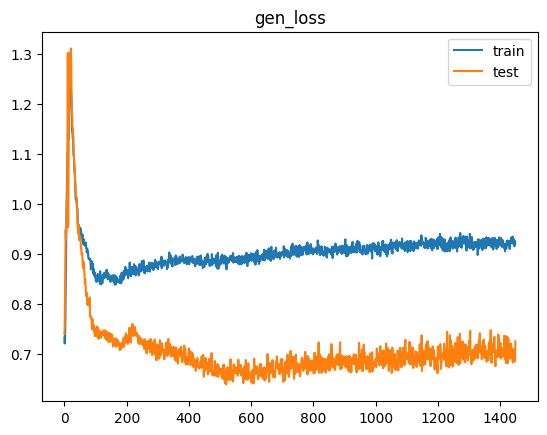

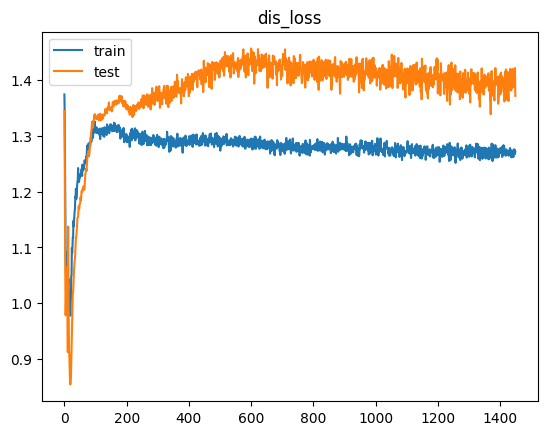

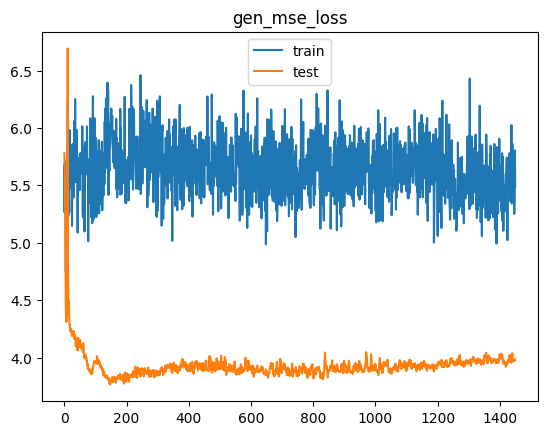

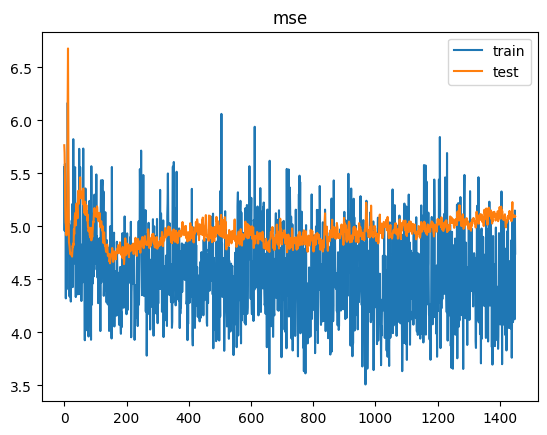

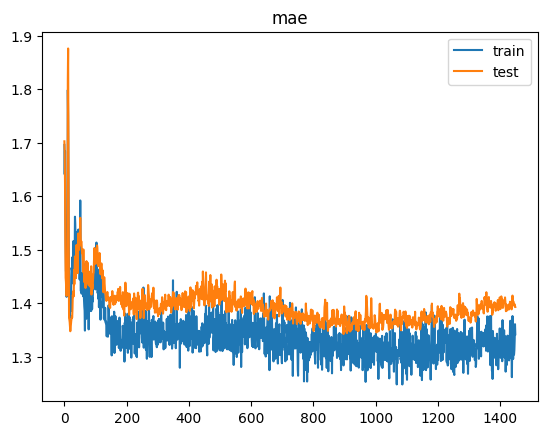

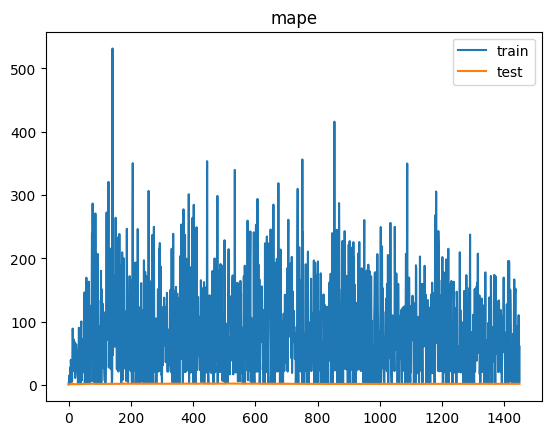

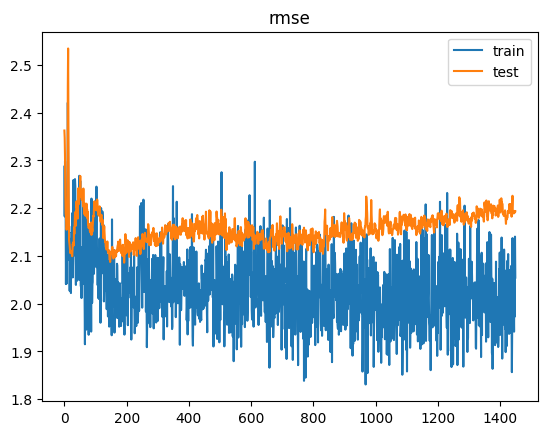

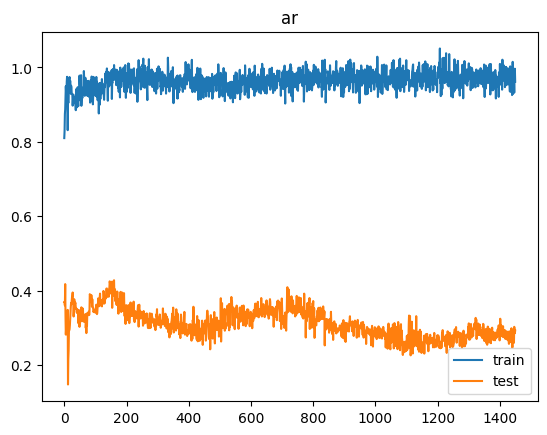

2/2 [==============================] - 0s 4ms/step


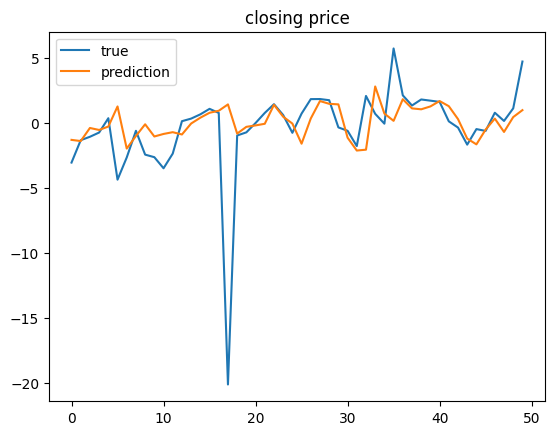

[MSE Baseline] train: 4.2119694628851745  test: 4.695498675820508
Delta time with epochs = 1450: 0:21:47.763825
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_12 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_13 (GRU)

Time for epoch 52 is 0.8641436100006104 sec Generator Loss: 0.9831773042678833,  Discriminator_loss: 1.203507661819458
Time for epoch 53 is 0.8894038200378418 sec Generator Loss: 0.9706243872642517,  Discriminator_loss: 1.232095718383789
Time for epoch 54 is 0.9630627632141113 sec Generator Loss: 0.960427463054657,  Discriminator_loss: 1.2378787994384766
Time for epoch 55 is 0.8764081001281738 sec Generator Loss: 0.9762040972709656,  Discriminator_loss: 1.2150442600250244
Time for epoch 56 is 0.8718552589416504 sec Generator Loss: 0.9565263986587524,  Discriminator_loss: 1.2347538471221924
Time for epoch 57 is 0.9403560161590576 sec Generator Loss: 0.957237958908081,  Discriminator_loss: 1.2328426837921143
Time for epoch 58 is 0.9416229724884033 sec Generator Loss: 0.943751335144043,  Discriminator_loss: 1.242238998413086
Time for epoch 59 is 0.9365098476409912 sec Generator Loss: 0.9512782692909241,  Discriminator_loss: 1.243510127067566
Time for epoch 60 is 0.9290797710418701 sec Gen

Time for epoch 121 is 1.144709587097168 sec Generator Loss: 0.8683318495750427,  Discriminator_loss: 1.302748441696167
Time for epoch 122 is 0.923029899597168 sec Generator Loss: 0.8706090450286865,  Discriminator_loss: 1.3027050495147705
Time for epoch 123 is 1.0165433883666992 sec Generator Loss: 0.8630164265632629,  Discriminator_loss: 1.295003056526184
Time for epoch 124 is 0.926224946975708 sec Generator Loss: 0.8684411644935608,  Discriminator_loss: 1.2869012355804443
Time for epoch 125 is 1.0457844734191895 sec Generator Loss: 0.8687870502471924,  Discriminator_loss: 1.2942795753479004
Time for epoch 126 is 1.056593418121338 sec Generator Loss: 0.8606591820716858,  Discriminator_loss: 1.3048094511032104
Time for epoch 127 is 0.9485445022583008 sec Generator Loss: 0.86042320728302,  Discriminator_loss: 1.3087347745895386
Time for epoch 128 is 0.9306247234344482 sec Generator Loss: 0.8633645176887512,  Discriminator_loss: 1.3012109994888306
Time for epoch 129 is 0.9843075275421143

Time for epoch 190 is 0.9369058609008789 sec Generator Loss: 0.8659724593162537,  Discriminator_loss: 1.2989418506622314
Time for epoch 191 is 1.0683062076568604 sec Generator Loss: 0.8684319257736206,  Discriminator_loss: 1.2862114906311035
Time for epoch 192 is 1.236701250076294 sec Generator Loss: 0.8545219898223877,  Discriminator_loss: 1.3042010068893433
Time for epoch 193 is 1.1723580360412598 sec Generator Loss: 0.85832679271698,  Discriminator_loss: 1.3017749786376953
Time for epoch 194 is 0.9552204608917236 sec Generator Loss: 0.856886625289917,  Discriminator_loss: 1.298604965209961
Time for epoch 195 is 0.9533615112304688 sec Generator Loss: 0.8652170300483704,  Discriminator_loss: 1.294290542602539
Time for epoch 196 is 1.1645257472991943 sec Generator Loss: 0.8603624105453491,  Discriminator_loss: 1.3087207078933716
Time for epoch 197 is 1.0867350101470947 sec Generator Loss: 0.8681226372718811,  Discriminator_loss: 1.2925589084625244
Time for epoch 198 is 1.00093626976013

Time for epoch 259 is 0.9341495037078857 sec Generator Loss: 0.8553130626678467,  Discriminator_loss: 1.3040027618408203
Time for epoch 260 is 0.9095914363861084 sec Generator Loss: 0.8706343173980713,  Discriminator_loss: 1.299609661102295
Time for epoch 261 is 0.8590042591094971 sec Generator Loss: 0.8716479539871216,  Discriminator_loss: 1.2884920835494995
Time for epoch 262 is 0.8826663494110107 sec Generator Loss: 0.8692545294761658,  Discriminator_loss: 1.2926522493362427
Time for epoch 263 is 0.8965177536010742 sec Generator Loss: 0.8724344372749329,  Discriminator_loss: 1.2967451810836792
Time for epoch 264 is 0.9487473964691162 sec Generator Loss: 0.8598209619522095,  Discriminator_loss: 1.3062419891357422
Time for epoch 265 is 0.8868365287780762 sec Generator Loss: 0.8764615058898926,  Discriminator_loss: 1.3059847354888916
Time for epoch 266 is 0.9028818607330322 sec Generator Loss: 0.8612819314002991,  Discriminator_loss: 1.30191171169281
Time for epoch 267 is 0.88594651222

Time for epoch 328 is 0.922987699508667 sec Generator Loss: 0.8736997246742249,  Discriminator_loss: 1.3008695840835571
Time for epoch 329 is 0.932917594909668 sec Generator Loss: 0.8696205615997314,  Discriminator_loss: 1.3028885126113892
Time for epoch 330 is 0.9312629699707031 sec Generator Loss: 0.8697424530982971,  Discriminator_loss: 1.2822084426879883
Time for epoch 331 is 0.926276683807373 sec Generator Loss: 0.8655015826225281,  Discriminator_loss: 1.3017081022262573
Time for epoch 332 is 0.936643123626709 sec Generator Loss: 0.8727990388870239,  Discriminator_loss: 1.3009859323501587
Time for epoch 333 is 0.9647667407989502 sec Generator Loss: 0.8778101205825806,  Discriminator_loss: 1.2903666496276855
Time for epoch 334 is 0.9202220439910889 sec Generator Loss: 0.880531907081604,  Discriminator_loss: 1.285429835319519
Time for epoch 335 is 0.9853854179382324 sec Generator Loss: 0.87349933385849,  Discriminator_loss: 1.288821816444397
Time for epoch 336 is 0.9219894409179688 

Time for epoch 397 is 0.9885852336883545 sec Generator Loss: 0.8791008591651917,  Discriminator_loss: 1.2919931411743164
Time for epoch 398 is 1.0524954795837402 sec Generator Loss: 0.8826853036880493,  Discriminator_loss: 1.2906297445297241
Time for epoch 399 is 1.0254337787628174 sec Generator Loss: 0.8764486312866211,  Discriminator_loss: 1.2974382638931274
Time for epoch 400 is 1.123061180114746 sec Generator Loss: 0.8807447552680969,  Discriminator_loss: 1.285409927368164
Time for epoch 401 is 0.954509973526001 sec Generator Loss: 0.8792768120765686,  Discriminator_loss: 1.2901431322097778
Time for epoch 402 is 0.9659430980682373 sec Generator Loss: 0.8741079568862915,  Discriminator_loss: 1.2908834218978882
Time for epoch 403 is 0.9498076438903809 sec Generator Loss: 0.8764564394950867,  Discriminator_loss: 1.2951639890670776
Time for epoch 404 is 0.9933288097381592 sec Generator Loss: 0.8736200928688049,  Discriminator_loss: 1.2952680587768555
Time for epoch 405 is 1.02714776992

Time for epoch 466 is 1.0331645011901855 sec Generator Loss: 0.8850234746932983,  Discriminator_loss: 1.286682367324829
Time for epoch 467 is 1.0410315990447998 sec Generator Loss: 0.8820224404335022,  Discriminator_loss: 1.28104829788208
Time for epoch 468 is 1.0689518451690674 sec Generator Loss: 0.875929057598114,  Discriminator_loss: 1.2839977741241455
Time for epoch 469 is 1.0146539211273193 sec Generator Loss: 0.8818793296813965,  Discriminator_loss: 1.289738655090332
Time for epoch 470 is 0.9650647640228271 sec Generator Loss: 0.8847255706787109,  Discriminator_loss: 1.2859219312667847
Time for epoch 471 is 0.9914300441741943 sec Generator Loss: 0.8895617723464966,  Discriminator_loss: 1.2850472927093506
Time for epoch 472 is 0.9940321445465088 sec Generator Loss: 0.8855801820755005,  Discriminator_loss: 1.2873271703720093
Time for epoch 473 is 1.0094683170318604 sec Generator Loss: 0.886082112789154,  Discriminator_loss: 1.2897075414657593
Time for epoch 474 is 1.01501917839050

Time for epoch 535 is 0.9924490451812744 sec Generator Loss: 0.8953447937965393,  Discriminator_loss: 1.2769302129745483
Time for epoch 536 is 1.0111761093139648 sec Generator Loss: 0.8955363631248474,  Discriminator_loss: 1.277463674545288
Time for epoch 537 is 1.0060219764709473 sec Generator Loss: 0.8922557830810547,  Discriminator_loss: 1.2870054244995117
Time for epoch 538 is 1.0341854095458984 sec Generator Loss: 0.8925170302391052,  Discriminator_loss: 1.2869657278060913
Time for epoch 539 is 1.0170392990112305 sec Generator Loss: 0.8933963775634766,  Discriminator_loss: 1.2828208208084106
Time for epoch 540 is 1.0912668704986572 sec Generator Loss: 0.8870846629142761,  Discriminator_loss: 1.2841182947158813
Time for epoch 541 is 0.9982023239135742 sec Generator Loss: 0.8886330127716064,  Discriminator_loss: 1.2831655740737915
Time for epoch 542 is 0.9977848529815674 sec Generator Loss: 0.8925641179084778,  Discriminator_loss: 1.2829961776733398
Time for epoch 543 is 1.047731876

Time for epoch 604 is 1.073991298675537 sec Generator Loss: 0.8996160626411438,  Discriminator_loss: 1.2841901779174805
Time for epoch 605 is 1.0047996044158936 sec Generator Loss: 0.9004396796226501,  Discriminator_loss: 1.284279465675354
Time for epoch 606 is 1.0216448307037354 sec Generator Loss: 0.8987637758255005,  Discriminator_loss: 1.2801542282104492
Time for epoch 607 is 0.9316706657409668 sec Generator Loss: 0.8849125504493713,  Discriminator_loss: 1.2820245027542114
Time for epoch 608 is 0.964674711227417 sec Generator Loss: 0.8952038884162903,  Discriminator_loss: 1.2775133848190308
Time for epoch 609 is 0.9914288520812988 sec Generator Loss: 0.8932569026947021,  Discriminator_loss: 1.2897058725357056
Time for epoch 610 is 1.008824348449707 sec Generator Loss: 0.8973740935325623,  Discriminator_loss: 1.2739578485488892
Time for epoch 611 is 0.914729118347168 sec Generator Loss: 0.8932417631149292,  Discriminator_loss: 1.2774550914764404
Time for epoch 612 is 0.9122240543365

Time for epoch 672 is 0.987213134765625 sec Generator Loss: 0.9031742215156555,  Discriminator_loss: 1.2763479948043823
Time for epoch 673 is 1.007270097732544 sec Generator Loss: 0.9036267995834351,  Discriminator_loss: 1.2821307182312012
Time for epoch 674 is 0.9420208930969238 sec Generator Loss: 0.9039905071258545,  Discriminator_loss: 1.2744066715240479
Time for epoch 675 is 0.9526362419128418 sec Generator Loss: 0.9025161862373352,  Discriminator_loss: 1.2810702323913574
Time for epoch 676 is 0.9479682445526123 sec Generator Loss: 0.8988268971443176,  Discriminator_loss: 1.2852697372436523
Time for epoch 677 is 1.0124220848083496 sec Generator Loss: 0.9025133848190308,  Discriminator_loss: 1.2704975605010986
Time for epoch 678 is 0.9721410274505615 sec Generator Loss: 0.8998536467552185,  Discriminator_loss: 1.2778599262237549
Time for epoch 679 is 0.9442217350006104 sec Generator Loss: 0.9067712426185608,  Discriminator_loss: 1.269789695739746
Time for epoch 680 is 0.93170309066

Time for epoch 741 is 0.9601621627807617 sec Generator Loss: 0.895073652267456,  Discriminator_loss: 1.276967167854309
Time for epoch 742 is 0.9257218837738037 sec Generator Loss: 0.9078442454338074,  Discriminator_loss: 1.2685719728469849
Time for epoch 743 is 0.9282965660095215 sec Generator Loss: 0.8993460536003113,  Discriminator_loss: 1.2836885452270508
Time for epoch 744 is 0.9363522529602051 sec Generator Loss: 0.8981130719184875,  Discriminator_loss: 1.2817013263702393
Time for epoch 745 is 0.9789776802062988 sec Generator Loss: 0.9026554822921753,  Discriminator_loss: 1.283409833908081
Time for epoch 746 is 0.9329159259796143 sec Generator Loss: 0.8979336619377136,  Discriminator_loss: 1.2898890972137451
Time for epoch 747 is 0.9300963878631592 sec Generator Loss: 0.9028014540672302,  Discriminator_loss: 1.283398985862732
Time for epoch 748 is 0.9236733913421631 sec Generator Loss: 0.899890124797821,  Discriminator_loss: 1.2808482646942139
Time for epoch 749 is 0.9137263298034

Time for epoch 810 is 0.9872646331787109 sec Generator Loss: 0.9068590402603149,  Discriminator_loss: 1.2828612327575684
Time for epoch 811 is 0.9244062900543213 sec Generator Loss: 0.9217686057090759,  Discriminator_loss: 1.2715296745300293
Time for epoch 812 is 0.9784152507781982 sec Generator Loss: 0.8977564573287964,  Discriminator_loss: 1.27784264087677
Time for epoch 813 is 0.9558734893798828 sec Generator Loss: 0.9094890356063843,  Discriminator_loss: 1.2727035284042358
Time for epoch 814 is 0.9280240535736084 sec Generator Loss: 0.9081733822822571,  Discriminator_loss: 1.2753514051437378
Time for epoch 815 is 0.9596977233886719 sec Generator Loss: 0.8985134363174438,  Discriminator_loss: 1.2808071374893188
Time for epoch 816 is 0.9417219161987305 sec Generator Loss: 0.9074463844299316,  Discriminator_loss: 1.2805733680725098
Time for epoch 817 is 0.9875931739807129 sec Generator Loss: 0.9094216227531433,  Discriminator_loss: 1.282716155052185
Time for epoch 818 is 0.98375606536

Time for epoch 878 is 0.9759109020233154 sec Generator Loss: 0.9053671956062317,  Discriminator_loss: 1.2727216482162476
Time for epoch 879 is 0.9861681461334229 sec Generator Loss: 0.9038717746734619,  Discriminator_loss: 1.2702555656433105
Time for epoch 880 is 0.9381518363952637 sec Generator Loss: 0.9067123532295227,  Discriminator_loss: 1.2794647216796875
Time for epoch 881 is 0.9862358570098877 sec Generator Loss: 0.9079298377037048,  Discriminator_loss: 1.2776521444320679
Time for epoch 882 is 0.9327657222747803 sec Generator Loss: 0.9130094647407532,  Discriminator_loss: 1.2770791053771973
Time for epoch 883 is 0.9599037170410156 sec Generator Loss: 0.9066650867462158,  Discriminator_loss: 1.2792519330978394
Time for epoch 884 is 0.9630098342895508 sec Generator Loss: 0.9115661978721619,  Discriminator_loss: 1.2746297121047974
Time for epoch 885 is 0.9306337833404541 sec Generator Loss: 0.9012275338172913,  Discriminator_loss: 1.2878398895263672
Time for epoch 886 is 0.94952821

Time for epoch 946 is 0.9609148502349854 sec Generator Loss: 0.9058802723884583,  Discriminator_loss: 1.2675784826278687
Time for epoch 947 is 1.0065901279449463 sec Generator Loss: 0.909613311290741,  Discriminator_loss: 1.2825706005096436
Time for epoch 948 is 1.0108389854431152 sec Generator Loss: 0.908360481262207,  Discriminator_loss: 1.2809162139892578
Time for epoch 949 is 1.3546090126037598 sec Generator Loss: 0.911720871925354,  Discriminator_loss: 1.276706576347351
Time for epoch 950 is 1.0772631168365479 sec Generator Loss: 0.8997302651405334,  Discriminator_loss: 1.2796738147735596
Time for epoch 951 is 1.0822958946228027 sec Generator Loss: 0.8940312266349792,  Discriminator_loss: 1.2886455059051514
Time for epoch 952 is 1.057443618774414 sec Generator Loss: 0.9134750962257385,  Discriminator_loss: 1.2756743431091309
Time for epoch 953 is 1.1152679920196533 sec Generator Loss: 0.9056587815284729,  Discriminator_loss: 1.2731741666793823
Time for epoch 954 is 1.1315429210662

Time for epoch 1014 is 1.1088240146636963 sec Generator Loss: 0.9047938585281372,  Discriminator_loss: 1.2869142293930054
Time for epoch 1015 is 1.0165202617645264 sec Generator Loss: 0.9063124656677246,  Discriminator_loss: 1.281429648399353
Time for epoch 1016 is 1.0361056327819824 sec Generator Loss: 0.9061157703399658,  Discriminator_loss: 1.2815169095993042
Time for epoch 1017 is 0.9898009300231934 sec Generator Loss: 0.9000906348228455,  Discriminator_loss: 1.2811199426651
Time for epoch 1018 is 1.0601413249969482 sec Generator Loss: 0.9110202789306641,  Discriminator_loss: 1.2717046737670898
Time for epoch 1019 is 1.0761909484863281 sec Generator Loss: 0.9030882120132446,  Discriminator_loss: 1.279704213142395
Time for epoch 1020 is 1.0162436962127686 sec Generator Loss: 0.9104040265083313,  Discriminator_loss: 1.2746171951293945
Time for epoch 1021 is 1.0126235485076904 sec Generator Loss: 0.910434901714325,  Discriminator_loss: 1.2733124494552612
Time for epoch 1022 is 0.99793

In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru (GRU)                   (None, 5, 10)             570       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                             

Time for epoch 53 is 0.8227331638336182 sec Generator Loss: 1.1170636415481567,  Discriminator_loss: 1.138290524482727
Time for epoch 54 is 0.8086593151092529 sec Generator Loss: 1.117781639099121,  Discriminator_loss: 1.1411291360855103
Time for epoch 55 is 0.8048646450042725 sec Generator Loss: 1.1101716756820679,  Discriminator_loss: 1.1590425968170166
Time for epoch 56 is 0.7891478538513184 sec Generator Loss: 1.1041102409362793,  Discriminator_loss: 1.1675039529800415
Time for epoch 57 is 0.7962760925292969 sec Generator Loss: 1.0935672521591187,  Discriminator_loss: 1.173522710800171
Time for epoch 58 is 0.8433082103729248 sec Generator Loss: 1.0970135927200317,  Discriminator_loss: 1.1727937459945679
Time for epoch 59 is 0.8292100429534912 sec Generator Loss: 1.0909463167190552,  Discriminator_loss: 1.1533534526824951
Time for epoch 60 is 0.8234117031097412 sec Generator Loss: 1.09340500831604,  Discriminator_loss: 1.1577963829040527
Time for epoch 61 is 0.8574299812316895 sec G

Time for epoch 122 is 0.809565544128418 sec Generator Loss: 0.9213086366653442,  Discriminator_loss: 1.2743953466415405
Time for epoch 123 is 0.7789456844329834 sec Generator Loss: 0.9180185794830322,  Discriminator_loss: 1.2581325769424438
Time for epoch 124 is 0.7789628505706787 sec Generator Loss: 0.9236275553703308,  Discriminator_loss: 1.2696202993392944
Time for epoch 125 is 0.788140058517456 sec Generator Loss: 0.9288741946220398,  Discriminator_loss: 1.2639706134796143
Time for epoch 126 is 0.7710146903991699 sec Generator Loss: 0.9215807318687439,  Discriminator_loss: 1.2721710205078125
Time for epoch 127 is 0.8275303840637207 sec Generator Loss: 0.9324877858161926,  Discriminator_loss: 1.2735962867736816
Time for epoch 128 is 0.7860612869262695 sec Generator Loss: 0.9207959771156311,  Discriminator_loss: 1.278069019317627
Time for epoch 129 is 0.8432838916778564 sec Generator Loss: 0.91536545753479,  Discriminator_loss: 1.2812635898590088
Time for epoch 130 is 0.7989780902862

Time for epoch 191 is 0.8010296821594238 sec Generator Loss: 0.8990611433982849,  Discriminator_loss: 1.2930151224136353
Time for epoch 192 is 0.7912437915802002 sec Generator Loss: 0.9093592762947083,  Discriminator_loss: 1.2772296667099
Time for epoch 193 is 0.7872781753540039 sec Generator Loss: 0.9016707539558411,  Discriminator_loss: 1.2886664867401123
Time for epoch 194 is 0.8089473247528076 sec Generator Loss: 0.890891432762146,  Discriminator_loss: 1.2913060188293457
Time for epoch 195 is 0.8206462860107422 sec Generator Loss: 0.8976480960845947,  Discriminator_loss: 1.2826522588729858
Time for epoch 196 is 0.8120265007019043 sec Generator Loss: 0.9098718166351318,  Discriminator_loss: 1.2668406963348389
Time for epoch 197 is 0.8074781894683838 sec Generator Loss: 0.9012444019317627,  Discriminator_loss: 1.2804675102233887
Time for epoch 198 is 0.7882380485534668 sec Generator Loss: 0.9021381139755249,  Discriminator_loss: 1.2771642208099365
Time for epoch 199 is 0.789905071258

Time for epoch 259 is 0.7368676662445068 sec Generator Loss: 0.8726662397384644,  Discriminator_loss: 1.2960807085037231
Time for epoch 260 is 0.7558090686798096 sec Generator Loss: 0.8713057041168213,  Discriminator_loss: 1.2891101837158203
Time for epoch 261 is 0.7473716735839844 sec Generator Loss: 0.8641313314437866,  Discriminator_loss: 1.3003507852554321
Time for epoch 262 is 0.9463992118835449 sec Generator Loss: 0.8828785419464111,  Discriminator_loss: 1.296531319618225
Time for epoch 263 is 0.9435875415802002 sec Generator Loss: 0.8830164074897766,  Discriminator_loss: 1.2975419759750366
Time for epoch 264 is 0.9263021945953369 sec Generator Loss: 0.8748652338981628,  Discriminator_loss: 1.2981231212615967
Time for epoch 265 is 0.8558981418609619 sec Generator Loss: 0.8785264492034912,  Discriminator_loss: 1.2949223518371582
Time for epoch 266 is 0.7987284660339355 sec Generator Loss: 0.8747670650482178,  Discriminator_loss: 1.2921881675720215
Time for epoch 267 is 0.787833929

Time for epoch 327 is 0.8005332946777344 sec Generator Loss: 0.8622263073921204,  Discriminator_loss: 1.3033734560012817
Time for epoch 328 is 0.7978634834289551 sec Generator Loss: 0.8569380044937134,  Discriminator_loss: 1.3036296367645264
Time for epoch 329 is 0.7992372512817383 sec Generator Loss: 0.8564817309379578,  Discriminator_loss: 1.3079538345336914
Time for epoch 330 is 0.7862339019775391 sec Generator Loss: 0.868865966796875,  Discriminator_loss: 1.299094796180725
Time for epoch 331 is 0.7984905242919922 sec Generator Loss: 0.8577279448509216,  Discriminator_loss: 1.2964364290237427
Time for epoch 332 is 0.8017489910125732 sec Generator Loss: 0.8633751273155212,  Discriminator_loss: 1.2991591691970825
Time for epoch 333 is 0.8013648986816406 sec Generator Loss: 0.8759211301803589,  Discriminator_loss: 1.2872234582901
Time for epoch 334 is 0.8275611400604248 sec Generator Loss: 0.8793731927871704,  Discriminator_loss: 1.2944332361221313
Time for epoch 335 is 0.7956368923187

Time for epoch 395 is 0.7848372459411621 sec Generator Loss: 0.867831289768219,  Discriminator_loss: 1.3022412061691284
Time for epoch 396 is 0.7829887866973877 sec Generator Loss: 0.8698492050170898,  Discriminator_loss: 1.3036590814590454
Time for epoch 397 is 0.7744841575622559 sec Generator Loss: 0.86493980884552,  Discriminator_loss: 1.303368091583252
Time for epoch 398 is 0.7606165409088135 sec Generator Loss: 0.8648951649665833,  Discriminator_loss: 1.3007577657699585
Time for epoch 399 is 0.7584953308105469 sec Generator Loss: 0.8637380003929138,  Discriminator_loss: 1.307698130607605
Time for epoch 400 is 0.7551896572113037 sec Generator Loss: 0.8739150166511536,  Discriminator_loss: 1.3019334077835083
Time for epoch 401 is 0.7953321933746338 sec Generator Loss: 0.8668501973152161,  Discriminator_loss: 1.3126516342163086
Time for epoch 402 is 0.8212618827819824 sec Generator Loss: 0.8698206543922424,  Discriminator_loss: 1.2998121976852417
Time for epoch 403 is 0.7641224861145

Time for epoch 464 is 0.878420352935791 sec Generator Loss: 0.8707697987556458,  Discriminator_loss: 1.2954070568084717
Time for epoch 465 is 0.9179084300994873 sec Generator Loss: 0.8904029130935669,  Discriminator_loss: 1.2911555767059326
Time for epoch 466 is 0.869818925857544 sec Generator Loss: 0.8734472990036011,  Discriminator_loss: 1.3102543354034424
Time for epoch 467 is 0.8012502193450928 sec Generator Loss: 0.8866260647773743,  Discriminator_loss: 1.2914992570877075
Time for epoch 468 is 1.0922832489013672 sec Generator Loss: 0.8761352896690369,  Discriminator_loss: 1.2991821765899658
Time for epoch 469 is 0.7911372184753418 sec Generator Loss: 0.8831556439399719,  Discriminator_loss: 1.2887022495269775
Time for epoch 470 is 0.7941570281982422 sec Generator Loss: 0.8736663460731506,  Discriminator_loss: 1.2995047569274902
Time for epoch 471 is 0.8109579086303711 sec Generator Loss: 0.8803486227989197,  Discriminator_loss: 1.2964437007904053
Time for epoch 472 is 0.8120539188

Time for epoch 532 is 0.7891433238983154 sec Generator Loss: 0.9004947543144226,  Discriminator_loss: 1.2858397960662842
Time for epoch 533 is 0.8096914291381836 sec Generator Loss: 0.8915480971336365,  Discriminator_loss: 1.2808395624160767
Time for epoch 534 is 0.8066771030426025 sec Generator Loss: 0.8818598985671997,  Discriminator_loss: 1.2953120470046997
Time for epoch 535 is 0.833632230758667 sec Generator Loss: 0.8971382975578308,  Discriminator_loss: 1.29037344455719
Time for epoch 536 is 0.7973706722259521 sec Generator Loss: 0.890840470790863,  Discriminator_loss: 1.2903265953063965
Time for epoch 537 is 0.7436096668243408 sec Generator Loss: 0.884143590927124,  Discriminator_loss: 1.2953697443008423
Time for epoch 538 is 0.7589874267578125 sec Generator Loss: 0.8906236886978149,  Discriminator_loss: 1.2835513353347778
Time for epoch 539 is 0.7590610980987549 sec Generator Loss: 0.8690764307975769,  Discriminator_loss: 1.3074487447738647
Time for epoch 540 is 0.7659294605255

Time for epoch 600 is 0.8159477710723877 sec Generator Loss: 0.8837290406227112,  Discriminator_loss: 1.2956384420394897
Time for epoch 601 is 0.794266939163208 sec Generator Loss: 0.8838140368461609,  Discriminator_loss: 1.294846773147583
Time for epoch 602 is 0.794766902923584 sec Generator Loss: 0.9039645791053772,  Discriminator_loss: 1.278183102607727
Time for epoch 603 is 0.8212904930114746 sec Generator Loss: 0.8931463956832886,  Discriminator_loss: 1.2830135822296143
Time for epoch 604 is 0.7921178340911865 sec Generator Loss: 0.9062580466270447,  Discriminator_loss: 1.2740356922149658
Time for epoch 605 is 0.7976281642913818 sec Generator Loss: 0.8997232913970947,  Discriminator_loss: 1.2863820791244507
Time for epoch 606 is 0.7990820407867432 sec Generator Loss: 0.8892087340354919,  Discriminator_loss: 1.297676920890808
Time for epoch 607 is 0.7724599838256836 sec Generator Loss: 0.9040783047676086,  Discriminator_loss: 1.2741011381149292
Time for epoch 608 is 0.7937974929809

Time for epoch 668 is 0.8204078674316406 sec Generator Loss: 0.9122412800788879,  Discriminator_loss: 1.281924843788147
Time for epoch 669 is 0.8138575553894043 sec Generator Loss: 0.9054248929023743,  Discriminator_loss: 1.2803813219070435
Time for epoch 670 is 0.7834315299987793 sec Generator Loss: 0.9014053344726562,  Discriminator_loss: 1.2773162126541138
Time for epoch 671 is 0.7888808250427246 sec Generator Loss: 0.8942300081253052,  Discriminator_loss: 1.2787507772445679
Time for epoch 672 is 0.7873411178588867 sec Generator Loss: 0.9185495972633362,  Discriminator_loss: 1.2816822528839111
Time for epoch 673 is 0.7994048595428467 sec Generator Loss: 0.9103221893310547,  Discriminator_loss: 1.2814642190933228
Time for epoch 674 is 0.8026289939880371 sec Generator Loss: 0.8957141041755676,  Discriminator_loss: 1.2801605463027954
Time for epoch 675 is 0.7769336700439453 sec Generator Loss: 0.8941200375556946,  Discriminator_loss: 1.2911916971206665
Time for epoch 676 is 0.810212850

Time for epoch 736 is 0.8786721229553223 sec Generator Loss: 0.9188157916069031,  Discriminator_loss: 1.2719656229019165
Time for epoch 737 is 0.8523280620574951 sec Generator Loss: 0.91805499792099,  Discriminator_loss: 1.2770849466323853
Time for epoch 738 is 0.7605326175689697 sec Generator Loss: 0.9173564910888672,  Discriminator_loss: 1.2695930004119873
Time for epoch 739 is 0.739431619644165 sec Generator Loss: 0.9129836559295654,  Discriminator_loss: 1.2694216966629028
Time for epoch 740 is 0.7562105655670166 sec Generator Loss: 0.9030576348304749,  Discriminator_loss: 1.2797666788101196
Time for epoch 741 is 0.7693555355072021 sec Generator Loss: 0.9113049507141113,  Discriminator_loss: 1.2715801000595093
Time for epoch 742 is 0.7660624980926514 sec Generator Loss: 0.9248982667922974,  Discriminator_loss: 1.2668166160583496
Time for epoch 743 is 0.7702062129974365 sec Generator Loss: 0.9155771136283875,  Discriminator_loss: 1.276258945465088
Time for epoch 744 is 0.753310203552

Time for epoch 805 is 0.7470335960388184 sec Generator Loss: 0.910987138748169,  Discriminator_loss: 1.2736756801605225
Time for epoch 806 is 0.7567958831787109 sec Generator Loss: 0.9108672738075256,  Discriminator_loss: 1.2757233381271362
Time for epoch 807 is 0.7487359046936035 sec Generator Loss: 0.9017349481582642,  Discriminator_loss: 1.2749677896499634
Time for epoch 808 is 0.7614052295684814 sec Generator Loss: 0.9148106575012207,  Discriminator_loss: 1.2754143476486206
Time for epoch 809 is 0.7508862018585205 sec Generator Loss: 0.9110660552978516,  Discriminator_loss: 1.2849682569503784
Time for epoch 810 is 0.7496423721313477 sec Generator Loss: 0.9072983264923096,  Discriminator_loss: 1.2735135555267334
Time for epoch 811 is 0.7611496448516846 sec Generator Loss: 0.9040051698684692,  Discriminator_loss: 1.2810018062591553
Time for epoch 812 is 0.7507331371307373 sec Generator Loss: 0.9188923239707947,  Discriminator_loss: 1.2639812231063843
Time for epoch 813 is 0.764935255

Time for epoch 873 is 0.7533583641052246 sec Generator Loss: 0.9169699549674988,  Discriminator_loss: 1.2709306478500366
Time for epoch 874 is 0.7554893493652344 sec Generator Loss: 0.9225022792816162,  Discriminator_loss: 1.2698071002960205
Time for epoch 875 is 0.7490510940551758 sec Generator Loss: 0.9295083284378052,  Discriminator_loss: 1.2675457000732422
Time for epoch 876 is 0.7418386936187744 sec Generator Loss: 0.9273667931556702,  Discriminator_loss: 1.2697457075119019
Time for epoch 877 is 0.8202128410339355 sec Generator Loss: 0.9164776802062988,  Discriminator_loss: 1.2734036445617676
Time for epoch 878 is 0.8528957366943359 sec Generator Loss: 0.9402763247489929,  Discriminator_loss: 1.2559876441955566
Time for epoch 879 is 0.7734062671661377 sec Generator Loss: 0.9355740547180176,  Discriminator_loss: 1.263796091079712
Time for epoch 880 is 0.7958393096923828 sec Generator Loss: 0.922002911567688,  Discriminator_loss: 1.261945366859436
Time for epoch 881 is 0.75197219848

Time for epoch 941 is 0.7711679935455322 sec Generator Loss: 0.9235936403274536,  Discriminator_loss: 1.2779405117034912
Time for epoch 942 is 0.8425724506378174 sec Generator Loss: 0.9117861390113831,  Discriminator_loss: 1.2668626308441162
Time for epoch 943 is 0.8257532119750977 sec Generator Loss: 0.9279170632362366,  Discriminator_loss: 1.2620457410812378
Time for epoch 944 is 0.8394992351531982 sec Generator Loss: 0.924912691116333,  Discriminator_loss: 1.2634347677230835
Time for epoch 945 is 0.806978702545166 sec Generator Loss: 0.9256894588470459,  Discriminator_loss: 1.2680107355117798
Time for epoch 946 is 0.8149728775024414 sec Generator Loss: 0.9251384139060974,  Discriminator_loss: 1.2602205276489258
Time for epoch 947 is 0.8798682689666748 sec Generator Loss: 0.9211844205856323,  Discriminator_loss: 1.2684907913208008
Time for epoch 948 is 0.8533275127410889 sec Generator Loss: 0.9351249933242798,  Discriminator_loss: 1.2574816942214966
Time for epoch 949 is 0.8300385475

Time for epoch 1009 is 0.8076050281524658 sec Generator Loss: 0.9318193197250366,  Discriminator_loss: 1.273078203201294
Time for epoch 1010 is 0.7701845169067383 sec Generator Loss: 0.9432379007339478,  Discriminator_loss: 1.253304362297058
Time for epoch 1011 is 0.7740952968597412 sec Generator Loss: 0.934355616569519,  Discriminator_loss: 1.2608122825622559
Time for epoch 1012 is 0.9510369300842285 sec Generator Loss: 0.9303481578826904,  Discriminator_loss: 1.2717969417572021
Time for epoch 1013 is 0.8154387474060059 sec Generator Loss: 0.9199066162109375,  Discriminator_loss: 1.2684011459350586
Time for epoch 1014 is 0.7838973999023438 sec Generator Loss: 0.931406557559967,  Discriminator_loss: 1.2681469917297363
Time for epoch 1015 is 0.7540135383605957 sec Generator Loss: 0.9332013130187988,  Discriminator_loss: 1.2622355222702026
Time for epoch 1016 is 0.7612273693084717 sec Generator Loss: 0.9171353578567505,  Discriminator_loss: 1.2740334272384644
Time for epoch 1017 is 0.765

Time for epoch 1077 is 0.7543094158172607 sec Generator Loss: 0.934634804725647,  Discriminator_loss: 1.2682607173919678
Time for epoch 1078 is 0.7530927658081055 sec Generator Loss: 0.9360159039497375,  Discriminator_loss: 1.256160855293274
Time for epoch 1079 is 0.7761051654815674 sec Generator Loss: 0.9303432703018188,  Discriminator_loss: 1.2505019903182983
Time for epoch 1080 is 0.7583954334259033 sec Generator Loss: 0.9247711300849915,  Discriminator_loss: 1.2638236284255981
Time for epoch 1081 is 0.7581131458282471 sec Generator Loss: 0.9224986433982849,  Discriminator_loss: 1.2693259716033936
Time for epoch 1082 is 0.7685606479644775 sec Generator Loss: 0.9264849424362183,  Discriminator_loss: 1.2684215307235718
Time for epoch 1083 is 0.7680478096008301 sec Generator Loss: 0.935997486114502,  Discriminator_loss: 1.2570817470550537
Time for epoch 1084 is 0.8613152503967285 sec Generator Loss: 0.920677900314331,  Discriminator_loss: 1.2697731256484985
Time for epoch 1085 is 0.917

Time for epoch 1145 is 0.7933917045593262 sec Generator Loss: 0.9413838386535645,  Discriminator_loss: 1.251251220703125
Time for epoch 1146 is 0.8031260967254639 sec Generator Loss: 0.9340957403182983,  Discriminator_loss: 1.2570216655731201
Time for epoch 1147 is 0.8196284770965576 sec Generator Loss: 0.9489926695823669,  Discriminator_loss: 1.2505996227264404
Time for epoch 1148 is 0.7921092510223389 sec Generator Loss: 0.937447190284729,  Discriminator_loss: 1.2492485046386719
Time for epoch 1149 is 0.8041143417358398 sec Generator Loss: 0.9293379783630371,  Discriminator_loss: 1.2634059190750122
Time for epoch 1150 is 0.7980494499206543 sec Generator Loss: 0.9273534417152405,  Discriminator_loss: 1.2631901502609253
Time for epoch 1151 is 0.7996549606323242 sec Generator Loss: 0.9244719743728638,  Discriminator_loss: 1.2656234502792358
Time for epoch 1152 is 0.799776554107666 sec Generator Loss: 0.9450668692588806,  Discriminator_loss: 1.2577755451202393
Time for epoch 1153 is 0.78

Time for epoch 1213 is 0.7828872203826904 sec Generator Loss: 0.9403376579284668,  Discriminator_loss: 1.2537912130355835
Time for epoch 1214 is 0.7900993824005127 sec Generator Loss: 0.9290249943733215,  Discriminator_loss: 1.2605129480361938
Time for epoch 1215 is 0.8127789497375488 sec Generator Loss: 0.944564700126648,  Discriminator_loss: 1.2459330558776855
Time for epoch 1216 is 0.7843248844146729 sec Generator Loss: 0.958622395992279,  Discriminator_loss: 1.2464942932128906
Time for epoch 1217 is 0.8122684955596924 sec Generator Loss: 0.9308242797851562,  Discriminator_loss: 1.2574173212051392
Time for epoch 1218 is 0.7926595211029053 sec Generator Loss: 0.9518881440162659,  Discriminator_loss: 1.2469724416732788
Time for epoch 1219 is 0.7904961109161377 sec Generator Loss: 0.9448937773704529,  Discriminator_loss: 1.2562743425369263
Time for epoch 1220 is 0.8117055892944336 sec Generator Loss: 0.9263496994972229,  Discriminator_loss: 1.259982705116272
Time for epoch 1221 is 0.79

Time for epoch 1281 is 0.8427751064300537 sec Generator Loss: 0.9480950832366943,  Discriminator_loss: 1.2525273561477661
Time for epoch 1282 is 0.840768575668335 sec Generator Loss: 0.943539559841156,  Discriminator_loss: 1.2564959526062012
Time for epoch 1283 is 0.8438766002655029 sec Generator Loss: 0.9463577270507812,  Discriminator_loss: 1.2441015243530273
Time for epoch 1284 is 0.7847187519073486 sec Generator Loss: 0.9395030736923218,  Discriminator_loss: 1.256285548210144
Time for epoch 1285 is 0.794438362121582 sec Generator Loss: 0.9379103779792786,  Discriminator_loss: 1.2566757202148438
Time for epoch 1286 is 0.7758998870849609 sec Generator Loss: 0.954365074634552,  Discriminator_loss: 1.2530142068862915
Time for epoch 1287 is 0.7934341430664062 sec Generator Loss: 0.9308569431304932,  Discriminator_loss: 1.2516909837722778
Time for epoch 1288 is 0.798454999923706 sec Generator Loss: 0.9253891706466675,  Discriminator_loss: 1.262863039970398
Time for epoch 1289 is 0.794433

Time for epoch 1349 is 0.7933132648468018 sec Generator Loss: 0.9336846470832825,  Discriminator_loss: 1.2560721635818481
Time for epoch 1350 is 0.767805814743042 sec Generator Loss: 0.9360325336456299,  Discriminator_loss: 1.2521085739135742
Time for epoch 1351 is 0.7989795207977295 sec Generator Loss: 0.9420324563980103,  Discriminator_loss: 1.2455403804779053
Time for epoch 1352 is 0.8148472309112549 sec Generator Loss: 0.940504789352417,  Discriminator_loss: 1.2550510168075562
Time for epoch 1353 is 0.8026494979858398 sec Generator Loss: 0.9510881900787354,  Discriminator_loss: 1.2487506866455078
Time for epoch 1354 is 0.7886414527893066 sec Generator Loss: 0.9372826814651489,  Discriminator_loss: 1.2589998245239258
Time for epoch 1355 is 0.7781667709350586 sec Generator Loss: 0.953447163105011,  Discriminator_loss: 1.238290786743164
Time for epoch 1356 is 0.7945187091827393 sec Generator Loss: 0.9607800245285034,  Discriminator_loss: 1.251312017440796
Time for epoch 1357 is 0.8082

Time for epoch 1417 is 0.8019545078277588 sec Generator Loss: 0.9537656307220459,  Discriminator_loss: 1.246422290802002
Time for epoch 1418 is 0.8002610206604004 sec Generator Loss: 0.9535764455795288,  Discriminator_loss: 1.2428582906723022
Time for epoch 1419 is 0.8503706455230713 sec Generator Loss: 0.9317496418952942,  Discriminator_loss: 1.2623851299285889
Time for epoch 1420 is 0.8178834915161133 sec Generator Loss: 0.9542737603187561,  Discriminator_loss: 1.2472134828567505
Time for epoch 1421 is 0.8570911884307861 sec Generator Loss: 0.9536595940589905,  Discriminator_loss: 1.2445796728134155
Time for epoch 1422 is 0.828951358795166 sec Generator Loss: 0.9477713108062744,  Discriminator_loss: 1.2504384517669678
Time for epoch 1423 is 0.8464701175689697 sec Generator Loss: 0.9624215364456177,  Discriminator_loss: 1.2339234352111816
Time for epoch 1424 is 0.8689167499542236 sec Generator Loss: 0.957129716873169,  Discriminator_loss: 1.2476110458374023
Time for epoch 1425 is 0.81

Time for epoch 1485 is 0.7963981628417969 sec Generator Loss: 0.9405865669250488,  Discriminator_loss: 1.2493741512298584
Time for epoch 1486 is 0.8020973205566406 sec Generator Loss: 0.9346516132354736,  Discriminator_loss: 1.2563055753707886
Time for epoch 1487 is 0.8087964057922363 sec Generator Loss: 0.9444634914398193,  Discriminator_loss: 1.2529737949371338
Time for epoch 1488 is 0.8039045333862305 sec Generator Loss: 0.9479531645774841,  Discriminator_loss: 1.2488442659378052
Time for epoch 1489 is 0.8448636531829834 sec Generator Loss: 0.9418403506278992,  Discriminator_loss: 1.2561715841293335
Time for epoch 1490 is 0.8326060771942139 sec Generator Loss: 0.9350382089614868,  Discriminator_loss: 1.2599643468856812
Time for epoch 1491 is 0.8539860248565674 sec Generator Loss: 0.9565256237983704,  Discriminator_loss: 1.2504547834396362
Time for epoch 1492 is 0.8224382400512695 sec Generator Loss: 0.9424702525138855,  Discriminator_loss: 1.2514522075653076
Time for epoch 1493 is 0

Time for epoch 1553 is 0.7993392944335938 sec Generator Loss: 0.9529987573623657,  Discriminator_loss: 1.2404937744140625
Time for epoch 1554 is 0.7906990051269531 sec Generator Loss: 0.9336110949516296,  Discriminator_loss: 1.2682980298995972
Time for epoch 1555 is 0.8064572811126709 sec Generator Loss: 0.9454886317253113,  Discriminator_loss: 1.2566516399383545
Time for epoch 1556 is 0.8519227504730225 sec Generator Loss: 0.9523726105690002,  Discriminator_loss: 1.2529032230377197
Time for epoch 1557 is 0.7871215343475342 sec Generator Loss: 0.9571672081947327,  Discriminator_loss: 1.2448010444641113
Time for epoch 1558 is 0.7574577331542969 sec Generator Loss: 0.9485437870025635,  Discriminator_loss: 1.2491602897644043
Time for epoch 1559 is 0.7485013008117676 sec Generator Loss: 0.9647980332374573,  Discriminator_loss: 1.2514145374298096
Time for epoch 1560 is 0.7596545219421387 sec Generator Loss: 0.9567098617553711,  Discriminator_loss: 1.2520196437835693
Time for epoch 1561 is 0

Time for epoch 1621 is 0.7592971324920654 sec Generator Loss: 0.9492533206939697,  Discriminator_loss: 1.2502784729003906
Time for epoch 1622 is 0.7761037349700928 sec Generator Loss: 0.9462983012199402,  Discriminator_loss: 1.2496026754379272
Time for epoch 1623 is 0.7868452072143555 sec Generator Loss: 0.9605298042297363,  Discriminator_loss: 1.2376909255981445
Time for epoch 1624 is 0.7636079788208008 sec Generator Loss: 0.9518271684646606,  Discriminator_loss: 1.2472901344299316
Time for epoch 1625 is 0.7706389427185059 sec Generator Loss: 0.9499831795692444,  Discriminator_loss: 1.2476736307144165
Time for epoch 1626 is 0.7556178569793701 sec Generator Loss: 0.9431760907173157,  Discriminator_loss: 1.2595651149749756
Time for epoch 1627 is 0.7728414535522461 sec Generator Loss: 0.9457345604896545,  Discriminator_loss: 1.244238018989563
Time for epoch 1628 is 0.7997050285339355 sec Generator Loss: 0.9437538981437683,  Discriminator_loss: 1.262314796447754
Time for epoch 1629 is 0.7

Time for epoch 1689 is 0.7664496898651123 sec Generator Loss: 0.9511188268661499,  Discriminator_loss: 1.2436009645462036
Time for epoch 1690 is 0.7789998054504395 sec Generator Loss: 0.9475295543670654,  Discriminator_loss: 1.263000249862671
Time for epoch 1691 is 0.7895116806030273 sec Generator Loss: 0.9388992786407471,  Discriminator_loss: 1.2615684270858765
Time for epoch 1692 is 0.7867283821105957 sec Generator Loss: 0.9431750774383545,  Discriminator_loss: 1.260768175125122
Time for epoch 1693 is 0.7918000221252441 sec Generator Loss: 0.9361774921417236,  Discriminator_loss: 1.2588064670562744
Time for epoch 1694 is 0.7651512622833252 sec Generator Loss: 0.93312668800354,  Discriminator_loss: 1.2654424905776978
Time for epoch 1695 is 0.7675197124481201 sec Generator Loss: 0.9341380000114441,  Discriminator_loss: 1.2636444568634033
Time for epoch 1696 is 0.7700033187866211 sec Generator Loss: 0.9452540278434753,  Discriminator_loss: 1.2462141513824463
Time for epoch 1697 is 0.790

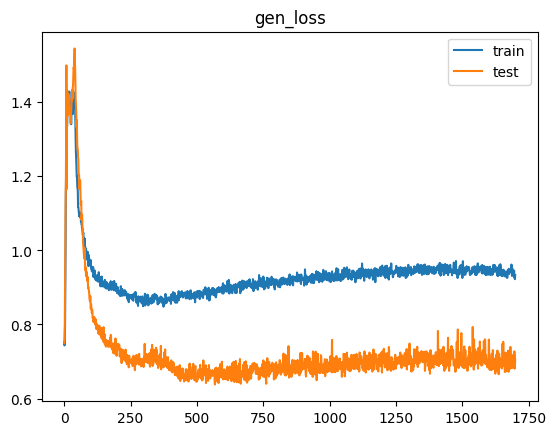

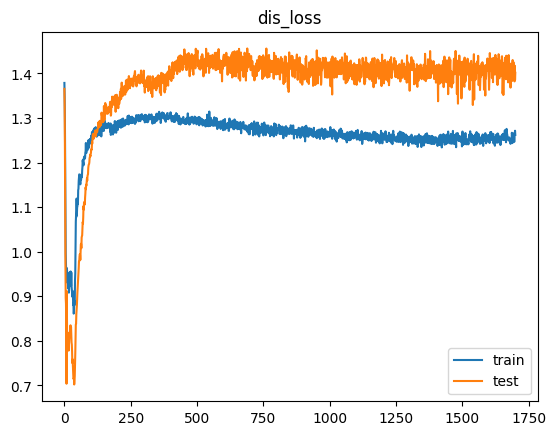

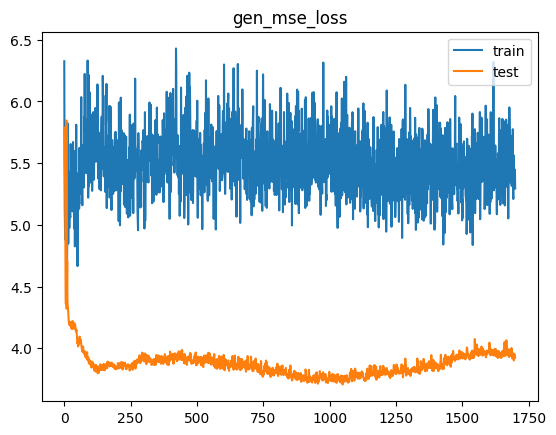

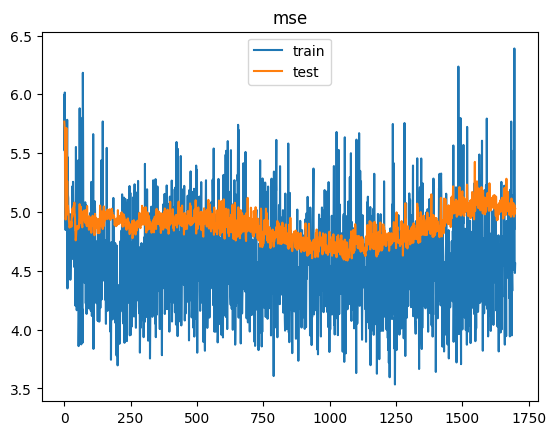

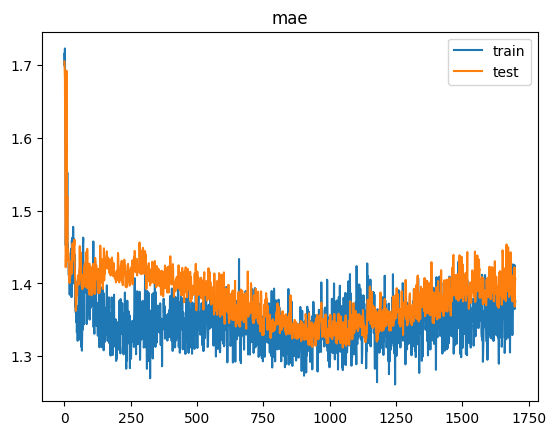

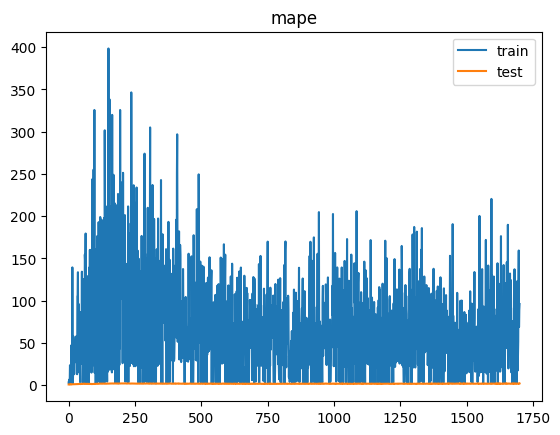

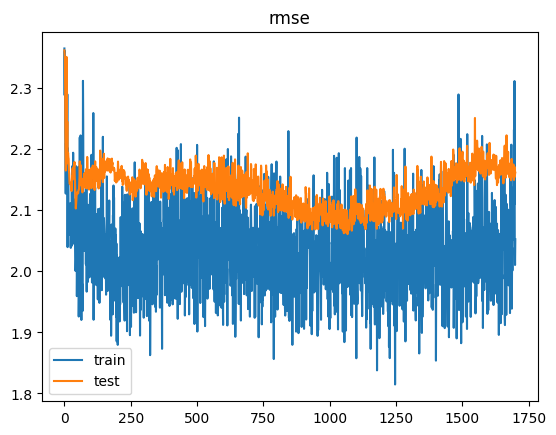

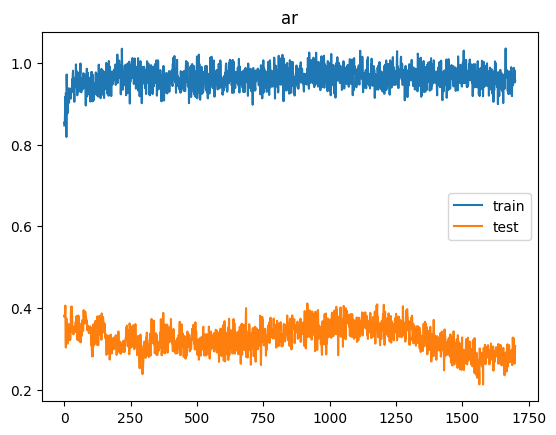

2/2 [==============================] - 0s 5ms/step


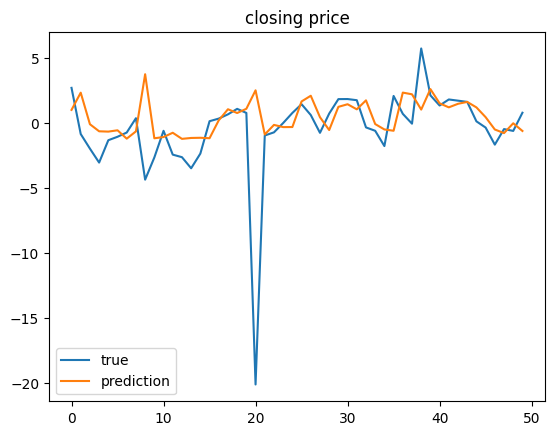

[MSE Baseline] train: 4.678133391013299  test: 4.679867713895856
Delta time with epochs = 1700: 0:23:19.276466
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 gru_3 (GRU)  

Time for epoch 52 is 0.7928602695465088 sec Generator Loss: 0.9734657406806946,  Discriminator_loss: 1.2434296607971191
Time for epoch 53 is 0.7878141403198242 sec Generator Loss: 0.9623386859893799,  Discriminator_loss: 1.250152349472046
Time for epoch 54 is 0.7976701259613037 sec Generator Loss: 0.980348527431488,  Discriminator_loss: 1.2429604530334473
Time for epoch 55 is 0.8425836563110352 sec Generator Loss: 0.9559097290039062,  Discriminator_loss: 1.2539142370224
Time for epoch 56 is 0.8009829521179199 sec Generator Loss: 0.9512307047843933,  Discriminator_loss: 1.2466505765914917
Time for epoch 57 is 0.7830963134765625 sec Generator Loss: 0.9463804960250854,  Discriminator_loss: 1.2642371654510498
Time for epoch 58 is 0.7751657962799072 sec Generator Loss: 0.9292151927947998,  Discriminator_loss: 1.2700238227844238
Time for epoch 59 is 0.785510778427124 sec Generator Loss: 0.929997444152832,  Discriminator_loss: 1.2689813375473022
Time for epoch 60 is 0.8415374755859375 sec Gen

Time for epoch 121 is 0.7779173851013184 sec Generator Loss: 0.859038233757019,  Discriminator_loss: 1.3116780519485474
Time for epoch 122 is 0.7771544456481934 sec Generator Loss: 0.8654869794845581,  Discriminator_loss: 1.3138604164123535
Time for epoch 123 is 0.7740616798400879 sec Generator Loss: 0.8466450572013855,  Discriminator_loss: 1.3151730298995972
Time for epoch 124 is 0.7765641212463379 sec Generator Loss: 0.8494046926498413,  Discriminator_loss: 1.3227882385253906
Time for epoch 125 is 0.763035774230957 sec Generator Loss: 0.8541145324707031,  Discriminator_loss: 1.3078862428665161
Time for epoch 126 is 0.7721564769744873 sec Generator Loss: 0.8578985333442688,  Discriminator_loss: 1.315422773361206
Time for epoch 127 is 0.7737629413604736 sec Generator Loss: 0.8548842668533325,  Discriminator_loss: 1.318134069442749
Time for epoch 128 is 0.7772445678710938 sec Generator Loss: 0.860174298286438,  Discriminator_loss: 1.3093181848526
Time for epoch 129 is 0.7725498676300049

Time for epoch 190 is 0.794043779373169 sec Generator Loss: 0.8436871767044067,  Discriminator_loss: 1.3144768476486206
Time for epoch 191 is 0.800936222076416 sec Generator Loss: 0.8395078182220459,  Discriminator_loss: 1.3184864521026611
Time for epoch 192 is 0.7885844707489014 sec Generator Loss: 0.838742733001709,  Discriminator_loss: 1.3238041400909424
Time for epoch 193 is 0.7875485420227051 sec Generator Loss: 0.8392981886863708,  Discriminator_loss: 1.3202521800994873
Time for epoch 194 is 0.8049819469451904 sec Generator Loss: 0.8375560641288757,  Discriminator_loss: 1.3231161832809448
Time for epoch 195 is 0.7852175235748291 sec Generator Loss: 0.8365211486816406,  Discriminator_loss: 1.323239803314209
Time for epoch 196 is 0.8208906650543213 sec Generator Loss: 0.8408887982368469,  Discriminator_loss: 1.318524956703186
Time for epoch 197 is 0.8242607116699219 sec Generator Loss: 0.8476210236549377,  Discriminator_loss: 1.3179515600204468
Time for epoch 198 is 0.7811746597290

Time for epoch 259 is 0.8738353252410889 sec Generator Loss: 0.8333819508552551,  Discriminator_loss: 1.3227978944778442
Time for epoch 260 is 0.8805086612701416 sec Generator Loss: 0.8360546827316284,  Discriminator_loss: 1.3140851259231567
Time for epoch 261 is 0.924555778503418 sec Generator Loss: 0.8361129760742188,  Discriminator_loss: 1.3218607902526855
Time for epoch 262 is 0.8965089321136475 sec Generator Loss: 0.839361846446991,  Discriminator_loss: 1.3160666227340698
Time for epoch 263 is 0.8685464859008789 sec Generator Loss: 0.8438295722007751,  Discriminator_loss: 1.3156338930130005
Time for epoch 264 is 0.8769512176513672 sec Generator Loss: 0.837841272354126,  Discriminator_loss: 1.3227382898330688
Time for epoch 265 is 0.8668808937072754 sec Generator Loss: 0.8453127145767212,  Discriminator_loss: 1.3193950653076172
Time for epoch 266 is 0.8707919120788574 sec Generator Loss: 0.847706139087677,  Discriminator_loss: 1.3109679222106934
Time for epoch 267 is 0.898571014404

Time for epoch 328 is 0.8948314189910889 sec Generator Loss: 0.8556398749351501,  Discriminator_loss: 1.3070815801620483
Time for epoch 329 is 0.9131379127502441 sec Generator Loss: 0.8557162880897522,  Discriminator_loss: 1.294400691986084
Time for epoch 330 is 0.8802468776702881 sec Generator Loss: 0.8555981516838074,  Discriminator_loss: 1.309104084968567
Time for epoch 331 is 0.8515257835388184 sec Generator Loss: 0.8580676913261414,  Discriminator_loss: 1.3070515394210815
Time for epoch 332 is 0.8985354900360107 sec Generator Loss: 0.8514876365661621,  Discriminator_loss: 1.3104443550109863
Time for epoch 333 is 1.0096800327301025 sec Generator Loss: 0.8569543957710266,  Discriminator_loss: 1.307324767112732
Time for epoch 334 is 0.9476325511932373 sec Generator Loss: 0.8559954166412354,  Discriminator_loss: 1.306602954864502
Time for epoch 335 is 0.9217112064361572 sec Generator Loss: 0.849581241607666,  Discriminator_loss: 1.3098174333572388
Time for epoch 336 is 0.8934953212738

Time for epoch 396 is 0.8906171321868896 sec Generator Loss: 0.8554344177246094,  Discriminator_loss: 1.3068898916244507
Time for epoch 397 is 0.8693068027496338 sec Generator Loss: 0.8517782688140869,  Discriminator_loss: 1.3077540397644043
Time for epoch 398 is 0.8641510009765625 sec Generator Loss: 0.8715404868125916,  Discriminator_loss: 1.293067455291748
Time for epoch 399 is 0.8496525287628174 sec Generator Loss: 0.8693627715110779,  Discriminator_loss: 1.2942472696304321
Time for epoch 400 is 0.8699781894683838 sec Generator Loss: 0.8799216747283936,  Discriminator_loss: 1.3005725145339966
Time for epoch 401 is 0.879331111907959 sec Generator Loss: 0.8706697821617126,  Discriminator_loss: 1.295967936515808
Time for epoch 402 is 0.9104177951812744 sec Generator Loss: 0.865317165851593,  Discriminator_loss: 1.2967904806137085
Time for epoch 403 is 0.8594388961791992 sec Generator Loss: 0.8626935482025146,  Discriminator_loss: 1.3001188039779663
Time for epoch 404 is 0.896151065826

Time for epoch 465 is 0.9188213348388672 sec Generator Loss: 0.865486204624176,  Discriminator_loss: 1.2996739149093628
Time for epoch 466 is 0.8819456100463867 sec Generator Loss: 0.8750869631767273,  Discriminator_loss: 1.2815552949905396
Time for epoch 467 is 0.9042608737945557 sec Generator Loss: 0.8682466745376587,  Discriminator_loss: 1.2939231395721436
Time for epoch 468 is 0.8712611198425293 sec Generator Loss: 0.8677161335945129,  Discriminator_loss: 1.2973370552062988
Time for epoch 469 is 0.8729231357574463 sec Generator Loss: 0.858802318572998,  Discriminator_loss: 1.3063395023345947
Time for epoch 470 is 0.8636033535003662 sec Generator Loss: 0.8753277063369751,  Discriminator_loss: 1.2925009727478027
Time for epoch 471 is 0.8758668899536133 sec Generator Loss: 0.8748252391815186,  Discriminator_loss: 1.2946856021881104
Time for epoch 472 is 0.8713767528533936 sec Generator Loss: 0.8651130199432373,  Discriminator_loss: 1.297830581665039
Time for epoch 473 is 0.87092852592

Time for epoch 534 is 1.095280408859253 sec Generator Loss: 0.8958404660224915,  Discriminator_loss: 1.2786155939102173
Time for epoch 535 is 0.8675012588500977 sec Generator Loss: 0.8865880966186523,  Discriminator_loss: 1.301173448562622
Time for epoch 536 is 0.8331928253173828 sec Generator Loss: 0.879988431930542,  Discriminator_loss: 1.3035293817520142
Time for epoch 537 is 0.8529374599456787 sec Generator Loss: 0.8822044730186462,  Discriminator_loss: 1.2890713214874268
Time for epoch 538 is 0.9607985019683838 sec Generator Loss: 0.8729356527328491,  Discriminator_loss: 1.2995543479919434
Time for epoch 539 is 0.8845946788787842 sec Generator Loss: 0.8801900148391724,  Discriminator_loss: 1.3013768196105957
Time for epoch 540 is 1.0156993865966797 sec Generator Loss: 0.8872931003570557,  Discriminator_loss: 1.2870569229125977
Time for epoch 541 is 0.8504025936126709 sec Generator Loss: 0.8799390196800232,  Discriminator_loss: 1.288025975227356
Time for epoch 542 is 0.828342676162

Time for epoch 603 is 0.7852268218994141 sec Generator Loss: 0.8899301290512085,  Discriminator_loss: 1.286074161529541
Time for epoch 604 is 0.7935101985931396 sec Generator Loss: 0.8826391696929932,  Discriminator_loss: 1.2867786884307861
Time for epoch 605 is 0.8067319393157959 sec Generator Loss: 0.8838583827018738,  Discriminator_loss: 1.2923617362976074
Time for epoch 606 is 0.8020858764648438 sec Generator Loss: 0.8890575766563416,  Discriminator_loss: 1.2863187789916992
Time for epoch 607 is 0.8530974388122559 sec Generator Loss: 0.879971444606781,  Discriminator_loss: 1.2965764999389648
Time for epoch 608 is 0.8095054626464844 sec Generator Loss: 0.8758609294891357,  Discriminator_loss: 1.2901166677474976
Time for epoch 609 is 0.8642516136169434 sec Generator Loss: 0.8799118399620056,  Discriminator_loss: 1.3006834983825684
Time for epoch 610 is 0.8111569881439209 sec Generator Loss: 0.8867632150650024,  Discriminator_loss: 1.2837878465652466
Time for epoch 611 is 0.7885851860

Time for epoch 671 is 0.7753527164459229 sec Generator Loss: 0.9021421670913696,  Discriminator_loss: 1.278909683227539
Time for epoch 672 is 0.7929816246032715 sec Generator Loss: 0.8957890868186951,  Discriminator_loss: 1.2892791032791138
Time for epoch 673 is 0.8043785095214844 sec Generator Loss: 0.8919727206230164,  Discriminator_loss: 1.287114143371582
Time for epoch 674 is 0.8154952526092529 sec Generator Loss: 0.9058358073234558,  Discriminator_loss: 1.2659673690795898
Time for epoch 675 is 0.7999892234802246 sec Generator Loss: 0.9052548408508301,  Discriminator_loss: 1.2803966999053955
Time for epoch 676 is 0.7861068248748779 sec Generator Loss: 0.8930089473724365,  Discriminator_loss: 1.2826862335205078
Time for epoch 677 is 0.7937850952148438 sec Generator Loss: 0.8997186422348022,  Discriminator_loss: 1.2879199981689453
Time for epoch 678 is 0.7838244438171387 sec Generator Loss: 0.9143289923667908,  Discriminator_loss: 1.2739763259887695
Time for epoch 679 is 0.7902824878

Time for epoch 740 is 0.7821445465087891 sec Generator Loss: 0.9081582427024841,  Discriminator_loss: 1.2760525941848755
Time for epoch 741 is 0.7985472679138184 sec Generator Loss: 0.8970126509666443,  Discriminator_loss: 1.2789026498794556
Time for epoch 742 is 0.7986340522766113 sec Generator Loss: 0.894651472568512,  Discriminator_loss: 1.2784196138381958
Time for epoch 743 is 0.8443717956542969 sec Generator Loss: 0.8931557536125183,  Discriminator_loss: 1.2900331020355225
Time for epoch 744 is 0.792586088180542 sec Generator Loss: 0.898234486579895,  Discriminator_loss: 1.283432960510254
Time for epoch 745 is 1.871516227722168 sec Generator Loss: 0.9043998718261719,  Discriminator_loss: 1.2748560905456543
Time for epoch 746 is 0.8258919715881348 sec Generator Loss: 0.9035789370536804,  Discriminator_loss: 1.278882384300232
Time for epoch 747 is 0.8491353988647461 sec Generator Loss: 0.8941289782524109,  Discriminator_loss: 1.2773929834365845
Time for epoch 748 is 0.78559637069702

Time for epoch 809 is 0.810070276260376 sec Generator Loss: 0.9043929576873779,  Discriminator_loss: 1.2785911560058594
Time for epoch 810 is 0.8045034408569336 sec Generator Loss: 0.9090031981468201,  Discriminator_loss: 1.2838279008865356
Time for epoch 811 is 0.8079359531402588 sec Generator Loss: 0.9154265522956848,  Discriminator_loss: 1.2640376091003418
Time for epoch 812 is 0.819159746170044 sec Generator Loss: 0.9129220247268677,  Discriminator_loss: 1.2676687240600586
Time for epoch 813 is 0.7714459896087646 sec Generator Loss: 0.916857123374939,  Discriminator_loss: 1.27459716796875
Time for epoch 814 is 0.7540340423583984 sec Generator Loss: 0.9138248562812805,  Discriminator_loss: 1.2700741291046143
Time for epoch 815 is 0.7572972774505615 sec Generator Loss: 0.9085013270378113,  Discriminator_loss: 1.2684887647628784
Time for epoch 816 is 0.7689778804779053 sec Generator Loss: 0.910825788974762,  Discriminator_loss: 1.2712228298187256
Time for epoch 817 is 0.76707220077514

Time for epoch 878 is 0.8035449981689453 sec Generator Loss: 0.897696316242218,  Discriminator_loss: 1.28741455078125
Time for epoch 879 is 0.8536679744720459 sec Generator Loss: 0.9121828675270081,  Discriminator_loss: 1.2731595039367676
Time for epoch 880 is 0.9669971466064453 sec Generator Loss: 0.9252281188964844,  Discriminator_loss: 1.2571909427642822
Time for epoch 881 is 0.8891754150390625 sec Generator Loss: 0.9176463484764099,  Discriminator_loss: 1.265128254890442
Time for epoch 882 is 0.9045493602752686 sec Generator Loss: 0.9123291373252869,  Discriminator_loss: 1.2554110288619995
Time for epoch 883 is 0.8776061534881592 sec Generator Loss: 0.914262056350708,  Discriminator_loss: 1.2759472131729126
Time for epoch 884 is 1.094212293624878 sec Generator Loss: 0.9295206069946289,  Discriminator_loss: 1.2615010738372803
Time for epoch 885 is 0.956092119216919 sec Generator Loss: 0.9322848916053772,  Discriminator_loss: 1.2641009092330933
Time for epoch 886 is 0.957666158676147

Time for epoch 947 is 0.7649145126342773 sec Generator Loss: 0.9251011610031128,  Discriminator_loss: 1.2607698440551758
Time for epoch 948 is 0.783684253692627 sec Generator Loss: 0.9372316002845764,  Discriminator_loss: 1.2565548419952393
Time for epoch 949 is 0.7740800380706787 sec Generator Loss: 0.9151588082313538,  Discriminator_loss: 1.270588755607605
Time for epoch 950 is 0.7823796272277832 sec Generator Loss: 0.9212847352027893,  Discriminator_loss: 1.2596644163131714
Time for epoch 951 is 0.9010968208312988 sec Generator Loss: 0.916532576084137,  Discriminator_loss: 1.2720553874969482
Time for epoch 952 is 0.8235569000244141 sec Generator Loss: 0.9239412546157837,  Discriminator_loss: 1.263091802597046
Time for epoch 953 is 0.7871458530426025 sec Generator Loss: 0.9168360829353333,  Discriminator_loss: 1.2732672691345215
Time for epoch 954 is 0.7746565341949463 sec Generator Loss: 0.9195023775100708,  Discriminator_loss: 1.27113938331604
Time for epoch 955 is 0.76236987113952

Time for epoch 1015 is 0.7767910957336426 sec Generator Loss: 0.9227532148361206,  Discriminator_loss: 1.2661546468734741
Time for epoch 1016 is 0.7633082866668701 sec Generator Loss: 0.9185242652893066,  Discriminator_loss: 1.272081971168518
Time for epoch 1017 is 0.7655737400054932 sec Generator Loss: 0.9175161719322205,  Discriminator_loss: 1.2703732252120972
Time for epoch 1018 is 0.7807865142822266 sec Generator Loss: 0.9202173948287964,  Discriminator_loss: 1.2764092683792114
Time for epoch 1019 is 0.7754538059234619 sec Generator Loss: 0.9185746908187866,  Discriminator_loss: 1.2738264799118042
Time for epoch 1020 is 0.7920002937316895 sec Generator Loss: 0.9281945824623108,  Discriminator_loss: 1.2676736116409302
Time for epoch 1021 is 0.7739818096160889 sec Generator Loss: 0.9226422309875488,  Discriminator_loss: 1.274247169494629
Time for epoch 1022 is 0.7816977500915527 sec Generator Loss: 0.9120862483978271,  Discriminator_loss: 1.2729185819625854
Time for epoch 1023 is 0.7

Time for epoch 1083 is 0.7816267013549805 sec Generator Loss: 0.9256263375282288,  Discriminator_loss: 1.2719440460205078
Time for epoch 1084 is 0.7653651237487793 sec Generator Loss: 0.9195426106452942,  Discriminator_loss: 1.263633370399475
Time for epoch 1085 is 0.7524573802947998 sec Generator Loss: 0.9185234904289246,  Discriminator_loss: 1.2653752565383911
Time for epoch 1086 is 0.7653155326843262 sec Generator Loss: 0.9393230676651001,  Discriminator_loss: 1.2502527236938477
Time for epoch 1087 is 0.7588667869567871 sec Generator Loss: 0.9260113835334778,  Discriminator_loss: 1.257889747619629
Time for epoch 1088 is 0.7949790954589844 sec Generator Loss: 0.9310043454170227,  Discriminator_loss: 1.2715919017791748
Time for epoch 1089 is 0.784247636795044 sec Generator Loss: 0.9236261248588562,  Discriminator_loss: 1.2740634679794312
Time for epoch 1090 is 0.7623867988586426 sec Generator Loss: 0.9224318861961365,  Discriminator_loss: 1.2765216827392578
Time for epoch 1091 is 0.74

Time for epoch 1151 is 0.8222451210021973 sec Generator Loss: 0.9296079874038696,  Discriminator_loss: 1.2618255615234375
Time for epoch 1152 is 0.8546862602233887 sec Generator Loss: 0.9144147038459778,  Discriminator_loss: 1.2725486755371094
Time for epoch 1153 is 0.8344357013702393 sec Generator Loss: 0.9148932695388794,  Discriminator_loss: 1.2626560926437378
Time for epoch 1154 is 0.8279557228088379 sec Generator Loss: 0.9292910099029541,  Discriminator_loss: 1.2585216760635376
Time for epoch 1155 is 0.8043224811553955 sec Generator Loss: 0.9225502014160156,  Discriminator_loss: 1.2662279605865479
Time for epoch 1156 is 0.761749267578125 sec Generator Loss: 0.9224856495857239,  Discriminator_loss: 1.2753334045410156
Time for epoch 1157 is 0.8320040702819824 sec Generator Loss: 0.9266498684883118,  Discriminator_loss: 1.2609915733337402
Time for epoch 1158 is 0.8603012561798096 sec Generator Loss: 0.9273694753646851,  Discriminator_loss: 1.2645002603530884
Time for epoch 1159 is 0.

Time for epoch 1219 is 0.9677939414978027 sec Generator Loss: 0.9190549254417419,  Discriminator_loss: 1.2771843671798706
Time for epoch 1220 is 0.9034130573272705 sec Generator Loss: 0.9240968227386475,  Discriminator_loss: 1.2722043991088867
Time for epoch 1221 is 0.8285694122314453 sec Generator Loss: 0.9202798008918762,  Discriminator_loss: 1.2714805603027344
Time for epoch 1222 is 0.9292540550231934 sec Generator Loss: 0.9268894791603088,  Discriminator_loss: 1.278464913368225
Time for epoch 1223 is 0.830773115158081 sec Generator Loss: 0.9256787300109863,  Discriminator_loss: 1.2640864849090576
Time for epoch 1224 is 0.844228982925415 sec Generator Loss: 0.9213965535163879,  Discriminator_loss: 1.2583361864089966
Time for epoch 1225 is 0.7898294925689697 sec Generator Loss: 0.9285621047019958,  Discriminator_loss: 1.2726385593414307
Time for epoch 1226 is 0.7883462905883789 sec Generator Loss: 0.9142633080482483,  Discriminator_loss: 1.284697413444519
Time for epoch 1227 is 0.828

Time for epoch 1287 is 0.8734097480773926 sec Generator Loss: 0.9231831431388855,  Discriminator_loss: 1.2734349966049194
Time for epoch 1288 is 1.0426011085510254 sec Generator Loss: 0.922117292881012,  Discriminator_loss: 1.280044674873352
Time for epoch 1289 is 0.9141597747802734 sec Generator Loss: 0.9203215837478638,  Discriminator_loss: 1.2697277069091797
Time for epoch 1290 is 0.920996904373169 sec Generator Loss: 0.9243959784507751,  Discriminator_loss: 1.2742319107055664
Time for epoch 1291 is 0.8536381721496582 sec Generator Loss: 0.9309128522872925,  Discriminator_loss: 1.2626091241836548
Time for epoch 1292 is 0.9104535579681396 sec Generator Loss: 0.9212620854377747,  Discriminator_loss: 1.268237829208374
Time for epoch 1293 is 0.8458576202392578 sec Generator Loss: 0.918217122554779,  Discriminator_loss: 1.2738451957702637
Time for epoch 1294 is 0.8142895698547363 sec Generator Loss: 0.912987470626831,  Discriminator_loss: 1.274604320526123
Time for epoch 1295 is 0.801810

Time for epoch 1355 is 0.9667482376098633 sec Generator Loss: 0.9267996549606323,  Discriminator_loss: 1.2635239362716675
Time for epoch 1356 is 1.0848934650421143 sec Generator Loss: 0.9198479056358337,  Discriminator_loss: 1.2824747562408447
Time for epoch 1357 is 1.1228439807891846 sec Generator Loss: 0.9164522886276245,  Discriminator_loss: 1.2788069248199463
Time for epoch 1358 is 1.1243922710418701 sec Generator Loss: 0.910918116569519,  Discriminator_loss: 1.27169668674469
Time for epoch 1359 is 0.9899022579193115 sec Generator Loss: 0.9073694944381714,  Discriminator_loss: 1.2737692594528198
Time for epoch 1360 is 0.9551146030426025 sec Generator Loss: 0.9307361841201782,  Discriminator_loss: 1.2562353610992432
Time for epoch 1361 is 0.8448266983032227 sec Generator Loss: 0.9241836667060852,  Discriminator_loss: 1.2671414613723755
Time for epoch 1362 is 0.8617968559265137 sec Generator Loss: 0.9305546879768372,  Discriminator_loss: 1.2645413875579834
Time for epoch 1363 is 1.12

Time for epoch 1423 is 0.9297068119049072 sec Generator Loss: 0.9173430800437927,  Discriminator_loss: 1.263366460800171
Time for epoch 1424 is 0.985248327255249 sec Generator Loss: 0.9123188853263855,  Discriminator_loss: 1.282150387763977
Time for epoch 1425 is 0.9154610633850098 sec Generator Loss: 0.9155189394950867,  Discriminator_loss: 1.2629441022872925
Time for epoch 1426 is 0.9465022087097168 sec Generator Loss: 0.9181247353553772,  Discriminator_loss: 1.2773500680923462
Time for epoch 1427 is 0.9230759143829346 sec Generator Loss: 0.91759192943573,  Discriminator_loss: 1.2786569595336914
Time for epoch 1428 is 0.952951192855835 sec Generator Loss: 0.9225047826766968,  Discriminator_loss: 1.2632224559783936
Time for epoch 1429 is 0.9218440055847168 sec Generator Loss: 0.9235979914665222,  Discriminator_loss: 1.2646416425704956
Time for epoch 1430 is 0.9326374530792236 sec Generator Loss: 0.9115015864372253,  Discriminator_loss: 1.2725937366485596
Time for epoch 1431 is 0.93234

Time for epoch 1491 is 1.017242193222046 sec Generator Loss: 0.9238371253013611,  Discriminator_loss: 1.2644790410995483
Time for epoch 1492 is 1.1382794380187988 sec Generator Loss: 0.9252936840057373,  Discriminator_loss: 1.2720186710357666
Time for epoch 1493 is 1.1316490173339844 sec Generator Loss: 0.917056143283844,  Discriminator_loss: 1.266822338104248
Time for epoch 1494 is 1.138242244720459 sec Generator Loss: 0.9154301881790161,  Discriminator_loss: 1.2779959440231323
Time for epoch 1495 is 0.9752380847930908 sec Generator Loss: 0.9255130290985107,  Discriminator_loss: 1.2643811702728271
Time for epoch 1496 is 0.9838058948516846 sec Generator Loss: 0.9359619617462158,  Discriminator_loss: 1.263879656791687
Time for epoch 1497 is 0.9629514217376709 sec Generator Loss: 0.9091856479644775,  Discriminator_loss: 1.2744637727737427
Time for epoch 1498 is 1.024522066116333 sec Generator Loss: 0.9329965710639954,  Discriminator_loss: 1.264229416847229
Time for epoch 1499 is 0.963232

Time for epoch 1559 is 1.1905434131622314 sec Generator Loss: 0.9266216158866882,  Discriminator_loss: 1.2615753412246704
Time for epoch 1560 is 1.2707831859588623 sec Generator Loss: 0.9189168810844421,  Discriminator_loss: 1.2614718675613403
Time for epoch 1561 is 1.2546517848968506 sec Generator Loss: 0.9193716049194336,  Discriminator_loss: 1.2749042510986328
Time for epoch 1562 is 1.208923578262329 sec Generator Loss: 0.9185785055160522,  Discriminator_loss: 1.2674812078475952
Time for epoch 1563 is 1.1261851787567139 sec Generator Loss: 0.9190332293510437,  Discriminator_loss: 1.2648788690567017
Time for epoch 1564 is 1.2447948455810547 sec Generator Loss: 0.9312559962272644,  Discriminator_loss: 1.260369062423706
Time for epoch 1565 is 1.2578952312469482 sec Generator Loss: 0.9241777062416077,  Discriminator_loss: 1.269911766052246
Time for epoch 1566 is 1.1820545196533203 sec Generator Loss: 0.9221425652503967,  Discriminator_loss: 1.268294095993042
Time for epoch 1567 is 1.180

Time for epoch 1627 is 0.9303898811340332 sec Generator Loss: 0.9360973834991455,  Discriminator_loss: 1.264906644821167
Time for epoch 1628 is 0.8956208229064941 sec Generator Loss: 0.92803555727005,  Discriminator_loss: 1.2629224061965942
Time for epoch 1629 is 0.9383211135864258 sec Generator Loss: 0.9468259811401367,  Discriminator_loss: 1.2564417123794556
Time for epoch 1630 is 0.9582946300506592 sec Generator Loss: 0.9215564131736755,  Discriminator_loss: 1.2715476751327515
Time for epoch 1631 is 0.9209296703338623 sec Generator Loss: 0.9254801869392395,  Discriminator_loss: 1.2661594152450562
Time for epoch 1632 is 0.8851203918457031 sec Generator Loss: 0.9295746684074402,  Discriminator_loss: 1.2646011114120483
Time for epoch 1633 is 0.892831563949585 sec Generator Loss: 0.9190457463264465,  Discriminator_loss: 1.278953194618225
Time for epoch 1634 is 0.9115149974822998 sec Generator Loss: 0.9288584589958191,  Discriminator_loss: 1.2735275030136108
Time for epoch 1635 is 0.8900

Time for epoch 1695 is 0.8017528057098389 sec Generator Loss: 0.9254754781723022,  Discriminator_loss: 1.2534464597702026
Time for epoch 1696 is 0.7968716621398926 sec Generator Loss: 0.9282236099243164,  Discriminator_loss: 1.2570559978485107
Time for epoch 1697 is 0.8224930763244629 sec Generator Loss: 0.9229908585548401,  Discriminator_loss: 1.2630757093429565
Time for epoch 1698 is 0.7908890247344971 sec Generator Loss: 0.9395589232444763,  Discriminator_loss: 1.2622604370117188
Time for epoch 1699 is 0.7864601612091064 sec Generator Loss: 0.9436354041099548,  Discriminator_loss: 1.2618317604064941
Time for epoch 1700 is 0.8015537261962891 sec Generator Loss: 0.9366645216941833,  Discriminator_loss: 1.2621513605117798
Time for epoch 1701 is 0.8036007881164551 sec Generator Loss: 0.9249037504196167,  Discriminator_loss: 1.2689582109451294
Time for epoch 1702 is 0.8128342628479004 sec Generator Loss: 0.941439151763916,  Discriminator_loss: 1.2503268718719482
Time for epoch 1703 is 0.

Time for epoch 1763 is 0.8116631507873535 sec Generator Loss: 0.920295774936676,  Discriminator_loss: 1.2692912817001343
Time for epoch 1764 is 0.823859453201294 sec Generator Loss: 0.9238010048866272,  Discriminator_loss: 1.2560912370681763
Time for epoch 1765 is 0.7820546627044678 sec Generator Loss: 0.9320969581604004,  Discriminator_loss: 1.270819067955017
Time for epoch 1766 is 0.7616667747497559 sec Generator Loss: 0.9245160222053528,  Discriminator_loss: 1.270361065864563
Time for epoch 1767 is 0.7799293994903564 sec Generator Loss: 0.9242717027664185,  Discriminator_loss: 1.2683337926864624
Time for epoch 1768 is 0.7891638278961182 sec Generator Loss: 0.9192054271697998,  Discriminator_loss: 1.2670165300369263
Time for epoch 1769 is 0.8367919921875 sec Generator Loss: 0.9421605467796326,  Discriminator_loss: 1.2513102293014526
Time for epoch 1770 is 0.7763206958770752 sec Generator Loss: 0.9412128329277039,  Discriminator_loss: 1.255934715270996
Time for epoch 1771 is 0.8262379

Time for epoch 1831 is 0.8953731060028076 sec Generator Loss: 0.9250848889350891,  Discriminator_loss: 1.2765408754348755
Time for epoch 1832 is 0.8991599082946777 sec Generator Loss: 0.9276523590087891,  Discriminator_loss: 1.2650946378707886
Time for epoch 1833 is 0.8888430595397949 sec Generator Loss: 0.9310795068740845,  Discriminator_loss: 1.2559459209442139
Time for epoch 1834 is 0.889643669128418 sec Generator Loss: 0.9255857467651367,  Discriminator_loss: 1.2712197303771973
Time for epoch 1835 is 0.8862264156341553 sec Generator Loss: 0.9390578866004944,  Discriminator_loss: 1.2534942626953125
Time for epoch 1836 is 0.9959990978240967 sec Generator Loss: 0.9407421946525574,  Discriminator_loss: 1.2519224882125854
Time for epoch 1837 is 0.9719622135162354 sec Generator Loss: 0.9282853603363037,  Discriminator_loss: 1.2671555280685425
Time for epoch 1838 is 0.8270184993743896 sec Generator Loss: 0.9500664472579956,  Discriminator_loss: 1.2612920999526978
Time for epoch 1839 is 0.

Time for epoch 1899 is 0.9029154777526855 sec Generator Loss: 0.9296923279762268,  Discriminator_loss: 1.2622430324554443
Time for epoch 1900 is 0.9241161346435547 sec Generator Loss: 0.9422696232795715,  Discriminator_loss: 1.2580699920654297
Time for epoch 1901 is 0.898390531539917 sec Generator Loss: 0.9295251369476318,  Discriminator_loss: 1.2563034296035767
Time for epoch 1902 is 0.9502501487731934 sec Generator Loss: 0.9312280416488647,  Discriminator_loss: 1.263000249862671
Time for epoch 1903 is 0.8849117755889893 sec Generator Loss: 0.9417662024497986,  Discriminator_loss: 1.2649539709091187
Time for epoch 1904 is 0.9106724262237549 sec Generator Loss: 0.9267826080322266,  Discriminator_loss: 1.2694542407989502
Time for epoch 1905 is 0.9043869972229004 sec Generator Loss: 0.9255248308181763,  Discriminator_loss: 1.2699341773986816
Time for epoch 1906 is 0.900200605392456 sec Generator Loss: 0.9295793771743774,  Discriminator_loss: 1.265902042388916
Time for epoch 1907 is 0.921

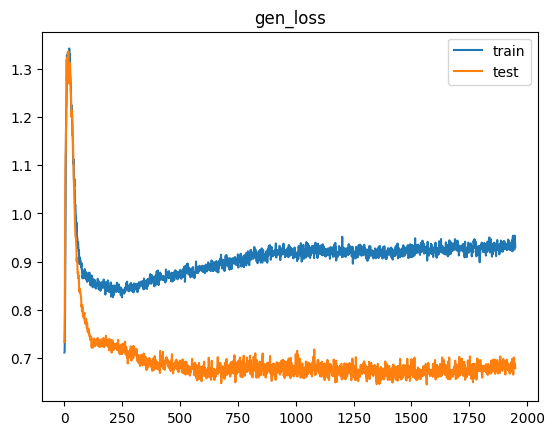

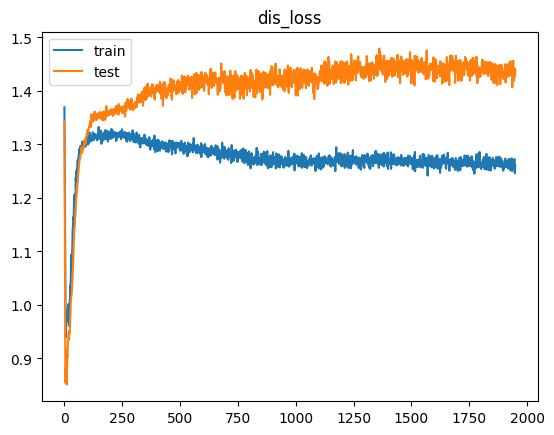

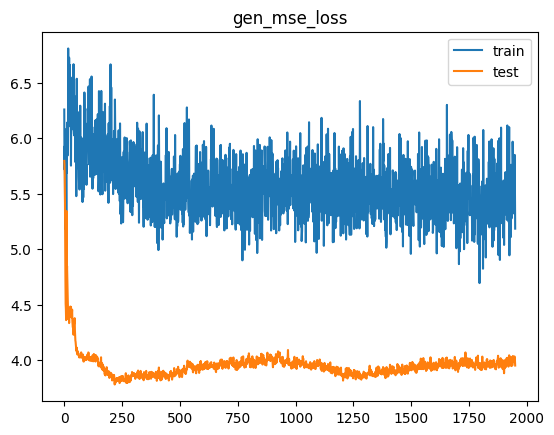

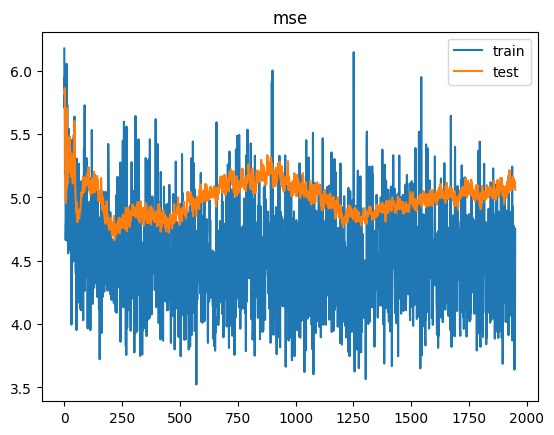

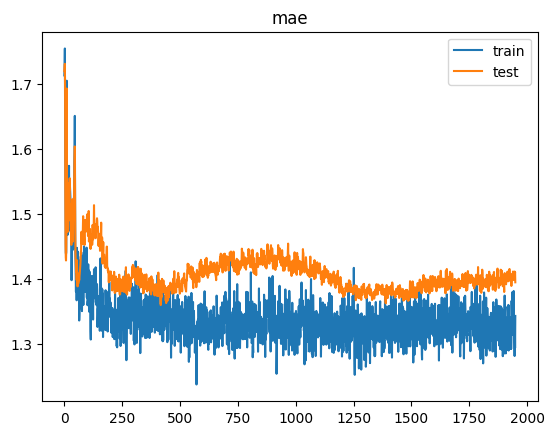

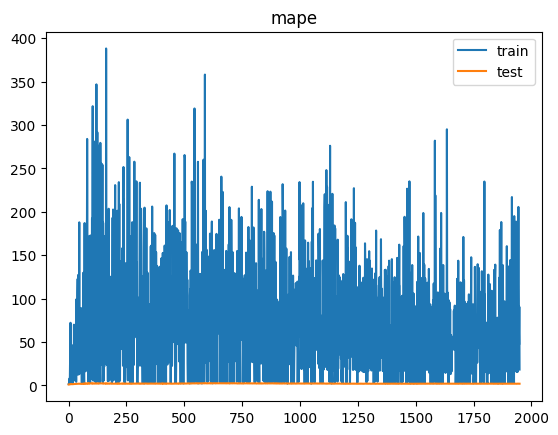

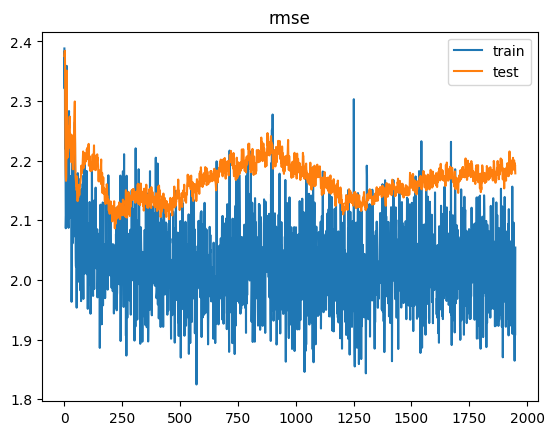

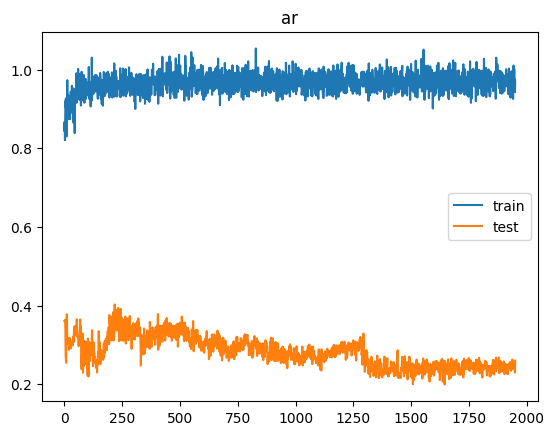

2/2 [==============================] - 0s 4ms/step


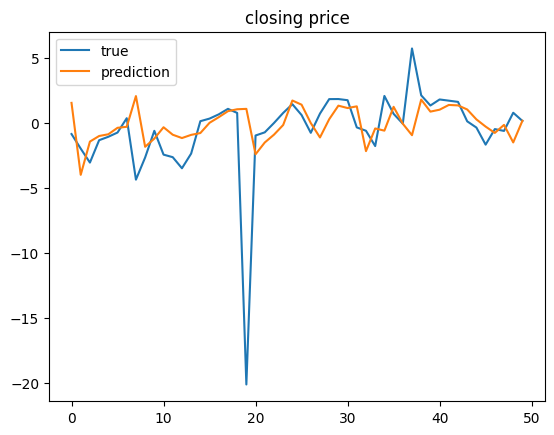

[MSE Baseline] train: 4.285625936410025  test: 4.6881765064049805
Delta time with epochs = 1950: 0:28:25.187241


In [20]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))